In [1]:
from __future__ import print_function, division
from collections import defaultdict, OrderedDict
import gzip
import pickle
import json
import os
import uproot
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from coffea import hist, processor 
from coffea.hist import plot
from coffea.util import load

In [2]:
hists = load('hists/darkhiggs2017.scaled')

In [3]:
hists['recoil'].identifiers('process')

[<StringBin (Hbb_merged) instance at 0x7f74905b5438>,
 <StringBin (Hbb_unmerged) instance at 0x7f74905b5860>,
 <StringBin (DYJetsHF) instance at 0x7f74905b5b70>,
 <StringBin (DYJetsLF) instance at 0x7f74905b5780>,
 <StringBin (VV) instance at 0x7f74905b5a58>,
 <StringBin (VVbb) instance at 0x7f749054cb38>,
 <StringBin (ST_merged) instance at 0x7f749054cac8>,
 <StringBin (ST_unmerged) instance at 0x7f745ed74b70>,
 <StringBin (TT_merged) instance at 0x7f745ed744a8>,
 <StringBin (TT_unmerged) instance at 0x7f745ed56be0>,
 <StringBin (WJetsHF) instance at 0x7f744fc05748>,
 <StringBin (WJetsLF) instance at 0x7f745ecf6898>,
 <StringBin (ZJetsHF) instance at 0x7f745ecf6908>,
 <StringBin (ZJetsLF) instance at 0x7f744ff6b0b8>,
 <StringBin (GJetsHF) instance at 0x7f744ff6b208>,
 <StringBin (GJetsLF) instance at 0x7f744ff6b278>,
 <StringBin (MET) instance at 0x7f744ff6b588>,
 <StringBin (SingleElectron) instance at 0x7f744ff6b5c0>,
 <StringBin (SinglePhoton) instance at 0x7f744ff6b5f8>]

In [4]:
process = hist.Cat("process", "Process", sorting='placement')
cats = ("process",)

signal_hists = {}
bkg_hists = {}
data_hists = {}

bkg_map = OrderedDict()
bkg_map["Hbb_merged"] = ("Hbb_merged*",)
bkg_map["Hbb_unmerged"] = ("Hbb_unmerged*",)
bkg_map["DYJetsHF"] = ("DYJetsHF*",)
bkg_map["DYJetsLF"] = ("DYJetsLF*",)
bkg_map["VV"] = ("VV",)
bkg_map["VVbb"] = ("VVbb*",)
bkg_map["STmerged"] = ("ST_merged*",)
bkg_map["STunmerged"] = ("ST_unmerged*",)
bkg_map["TTmerged"] = ("TT_merged*",)
bkg_map["TTunmerged"] = ("TT_unmerged*",)
bkg_map["WJetsHF"] = ("WJetsHF*",)
bkg_map["WJetsLF"] = ("WJetsLF*",)
bkg_map["ZJetsHF"] = ("ZJetsHF*",)
bkg_map["ZJetsLF"] = ("ZJetsLF*",)
bkg_map["GJetsHF"] = ("GJetsHF*",)
bkg_map["GJetsLF"] = ("GJetsLF*",)

signal_map = OrderedDict()
signal_map["Mhs_50_merged"] = ("Mhs_50_merged*",)  ## signals
signal_map["Mhs_50_unmerged"] = ("Mhs_50_unmerged*",)  ## signals   
signal_map["Mhs_70_merged"] = ("Mhs_70_merged*",)
signal_map["Mhs_70_unmerged"] = ("Mhs_70_unmerged*",)
signal_map["Mhs_90_merged"] = ("Mhs_90_merged*",)
signal_map["Mhs_90_unmerged"] = ("Mhs_90_unmerged*",)
signal_map["MonoJet"] = ("MonoJet*",)  ## signals                                                                                                                                                              
signal_map["MonoW"] = ("MonoW*",)    ## signals                                                                                                                                                                
signal_map["MonoZ"] = ("MonoZ*",)    ## signals    

data_map = OrderedDict()
data_map["MET"] = ("MET*", )
data_map["SingleElectron"] = ("SingleElectron*", )
data_map["SinglePhoton"] = ("SinglePhoton*", )


for key in hists.keys():                                                                                                                            
    bkg_hists[key] = hists[key].group(cats, process, bkg_map)  
    signal_hists[key] = hists[key].group(cats, process, signal_map)
    data_hists[key] = hists[key].group(cats, process, data_map)

In [6]:
exp = 0
region = 'wecr'
sys = 'nominal'
data={}
data['sr'] = 'MET'
data['wmcr'] = 'MET'
data['tmcr'] = 'MET'
data['wecr'] = 'SingleElectron'
data['tecr'] = 'SingleElectron'
data['zmcr'] = 'MET'
data['zecr'] = 'SingleElectron'
data['gcr'] = 'SinglePhoton'

variable = 'recoil'
cut_bin = 0
cut_value_array = bkg_hists[variable].integrate('systematic',sys).integrate('region','sr').integrate('process', 'Mhs_50').axis(variable).edges(overflow='all')

print('------------------------')
print('------------------------')
print('Category:', region)
print('Systematic:', sys)
#print('------------------------')
if cut_bin!=0: print(variable,'> %.2f' % cut_value_array[()][cut_bin])
print('------------------------')
print('------------------------')
for p in bkg_hists[variable].identifiers('process'):
    yld_array = bkg_hists[variable].integrate('systematic',sys).integrate('region',region).integrate('process', p).values(overflow='all')
    if () in yld_array:
        yld = np.cumsum(yld_array[()])[16] - np.cumsum(yld_array[()])[cut_bin]
        exp += yld
        print(p, '%.1f' % yld)

print('------------------------')
print('Total expected:', '%.1f' % exp)
print('------------------------')

for p in signal_hists[variable].identifiers('process'):
    yld_array = signal_hists[variable].integrate('systematic',sys).integrate('region',region).integrate('process', p).values(overflow='all')
    if () in yld_array:
        yld = np.cumsum(yld_array[()])[16] - np.cumsum(yld_array[()])[cut_bin]
        print(p, '%.1f' % yld)
        print(p,'S/B %.3f' % (yld/exp))
        print(p,'S/sqrt(B) %.1f' % (yld/np.sqrt(exp)))
        #print(p,'Fraction %.2f' % (yld/np.cumsum(yld_array[()])[16]))
        print('------------------------')

if not region == 'sr':
    yld_array = data_hists[variable].integrate('systematic',sys).integrate('region',region).integrate('process', data[region]).values(overflow='all')
    if () in yld_array and 'iszeroL' not in region:
        yld = np.cumsum(yld_array[()])[16] - np.cumsum(yld_array[()])[cut_bin]
        print('Total observed:', '%.1f' % yld)   
print('------------------------')
print()

------------------------
------------------------
Category: wecr
Systematic: nominal
------------------------
------------------------
Hbb_merged 36.0
Hbb_unmerged 11.3
DYJetsHF 299.0
DYJetsLF 3056.7
VV 3488.7
VVbb 70.3
STmerged 1394.9
STunmerged 3221.7
TTmerged 5429.8
TTunmerged 6731.2
WJetsHF 23288.8
WJetsLF 112457.0
------------------------
Total expected: 159485.4
------------------------
Total observed: 169649.0
------------------------



/home/jongho/Physics/LPC-DM/coffea/lib/python3.6/site-packages/mplhep/__init__.py:49: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  font_list = fm.createFontList(font_files)
/home/jongho/Physics/LPC-DM/coffea/lib/python3.6/site-packages/coffea/hist/plot.py:359: RuntimeWarning: invalid value encountered in true_divide
  rsumw = sumw_num / sumw_denom
/home/jongho/Physics/LPC-DM/coffea/lib/python3.6/site-packages/coffea/hist/plot.py:366: RuntimeWarning: invalid value encountered in true_divide
  rsumw_err = np.abs(poisson_interval(rsumw, sumw2_num / sumw_denom**2) - rsumw)
/home/jongho/Physics/LPC-DM/coffea/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:873: RuntimeWarning: invalid value encountered in greater
  cond = logical_and(cond, (asarray(arg) > 0))
/home/jongho/Physics/LPC-DM/coffea/lib/python3.6/site-packages/coffea/hist/plot.py:380: Run

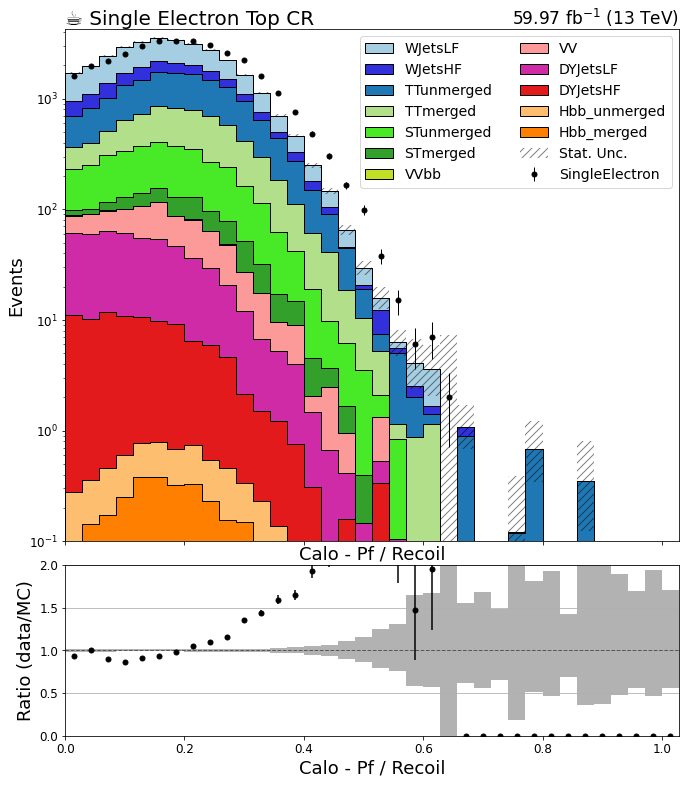

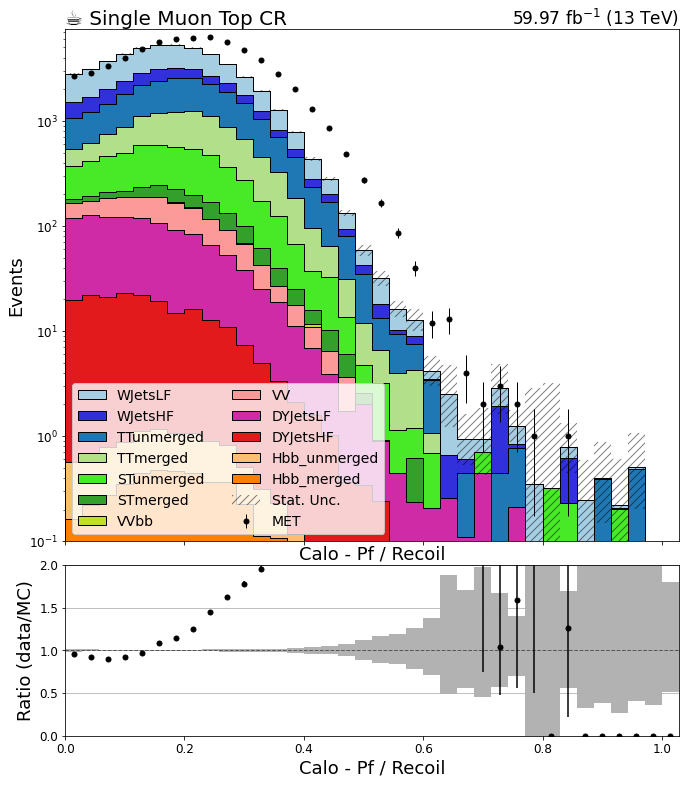

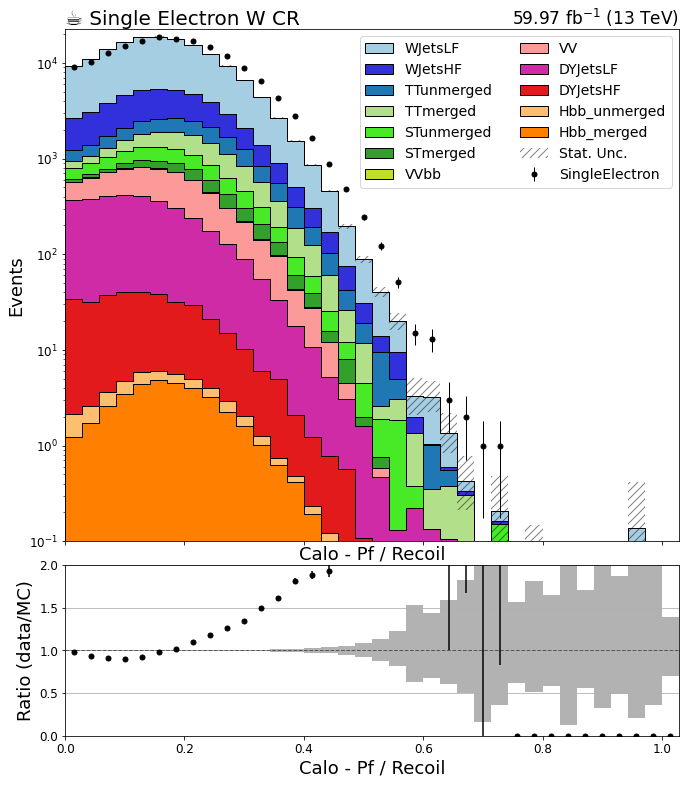

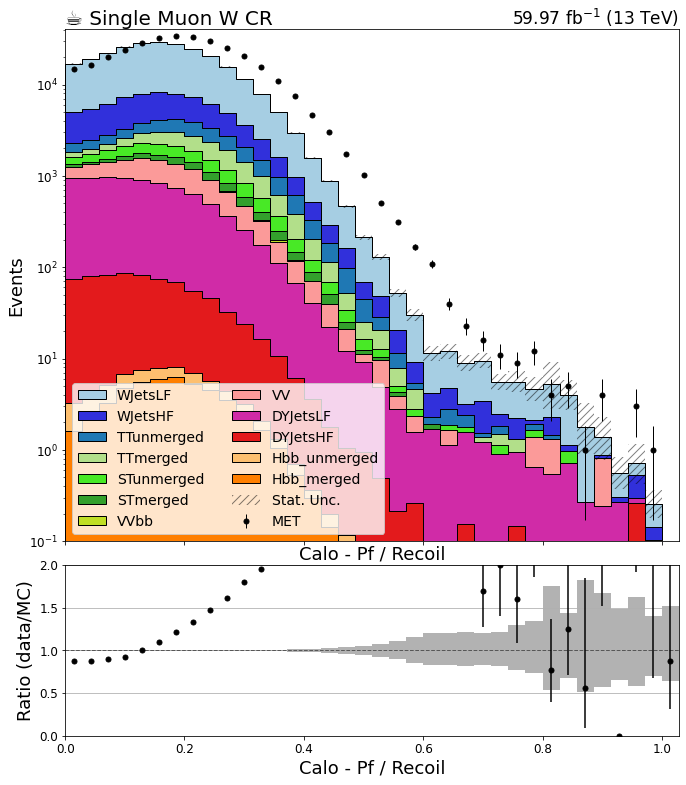

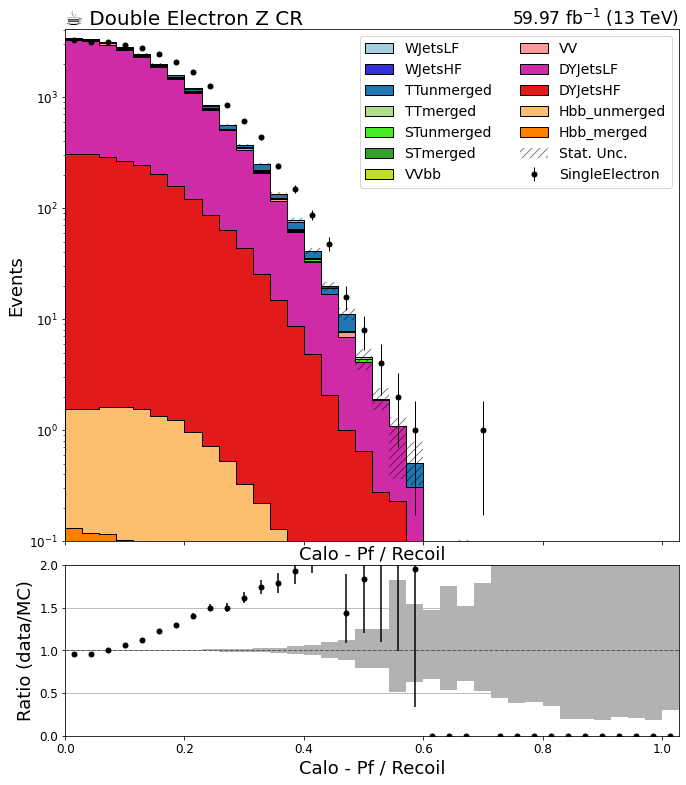

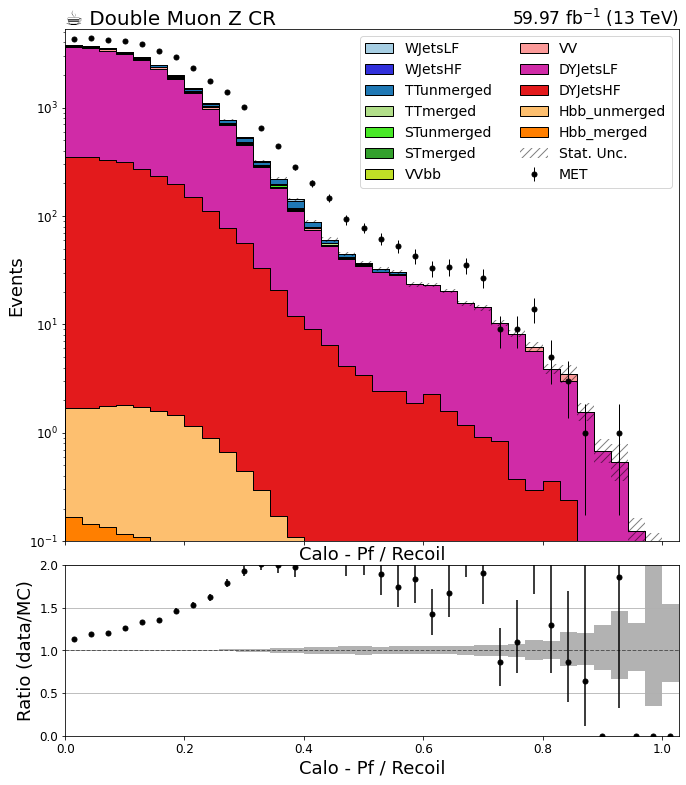

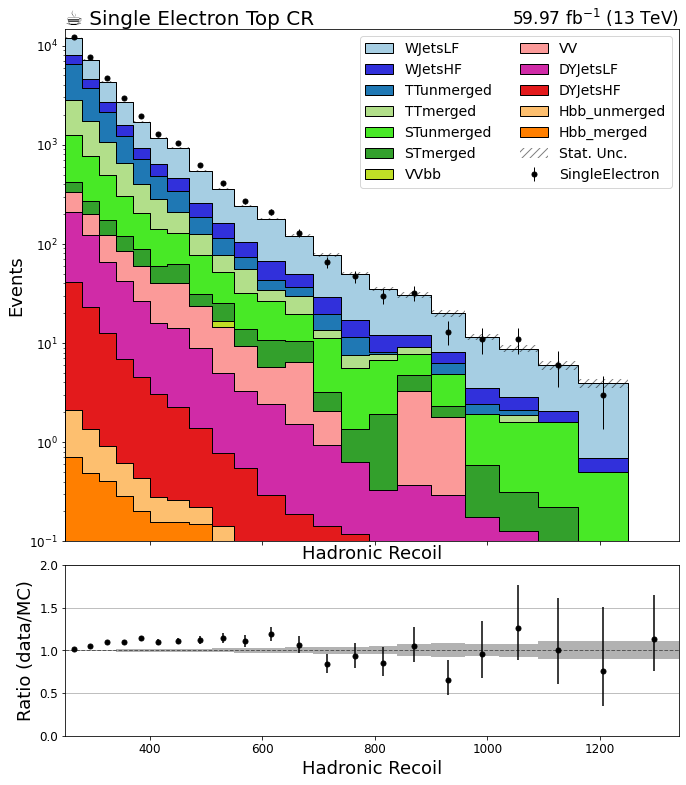

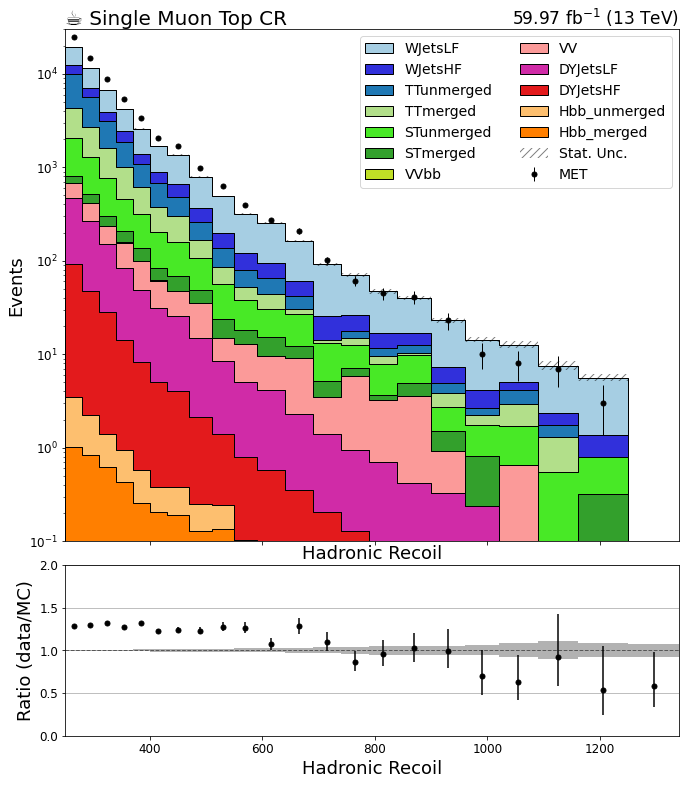

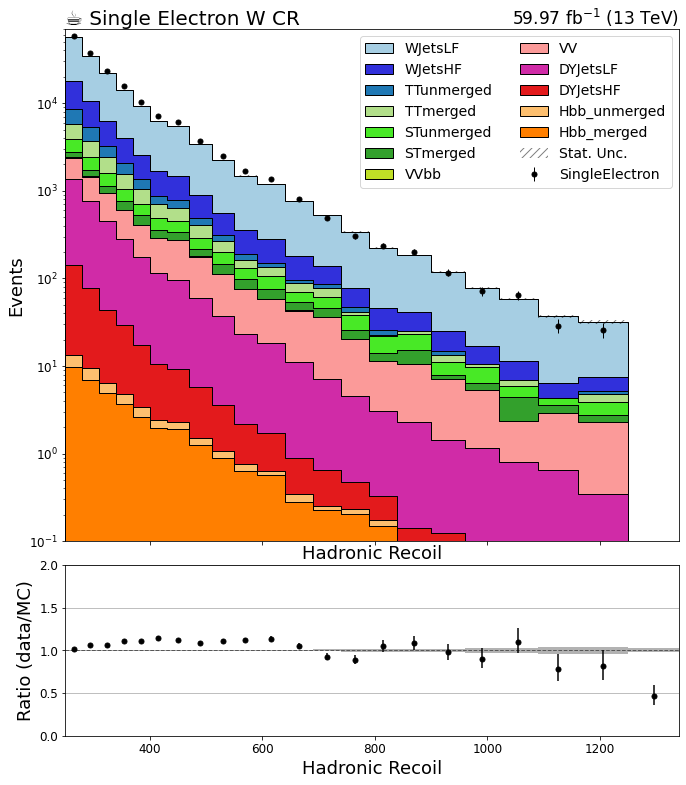

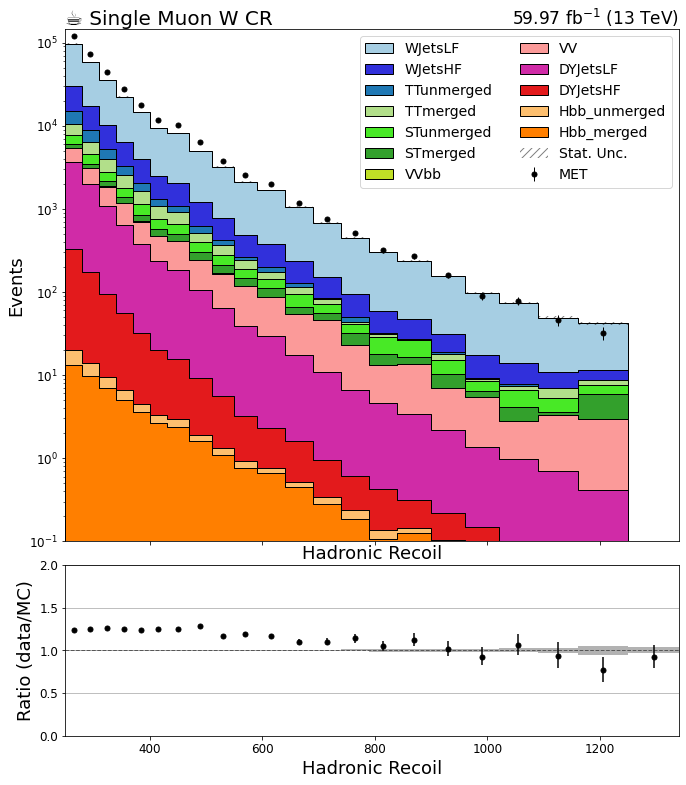

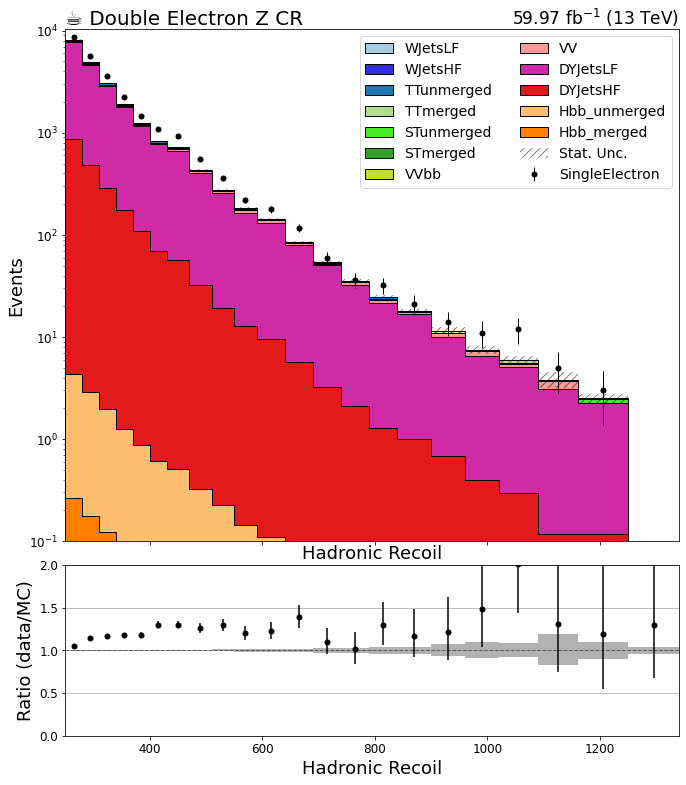

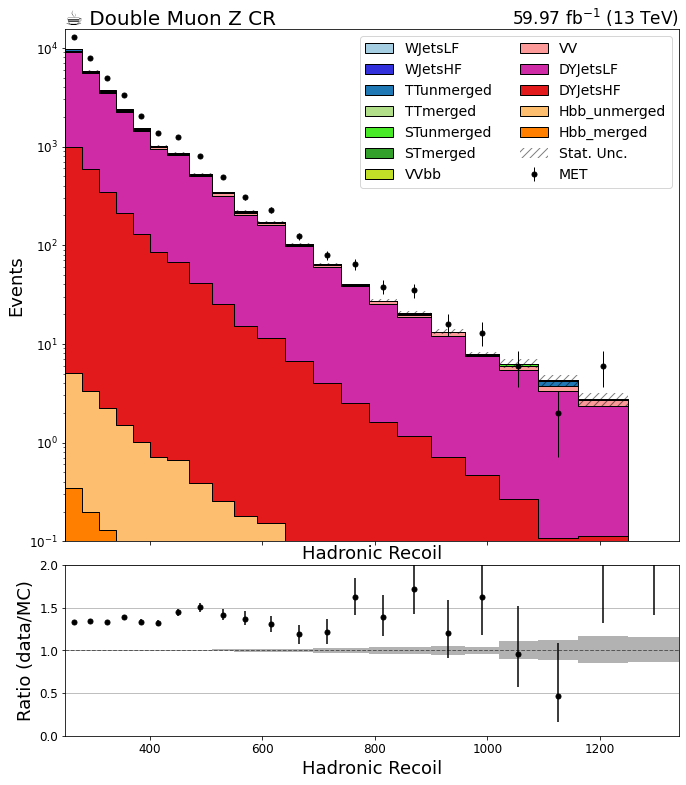

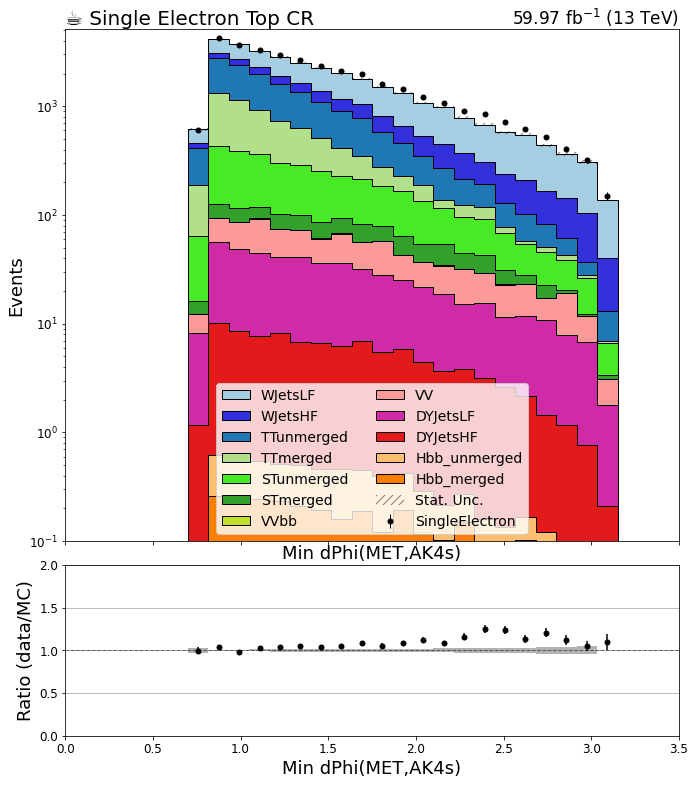

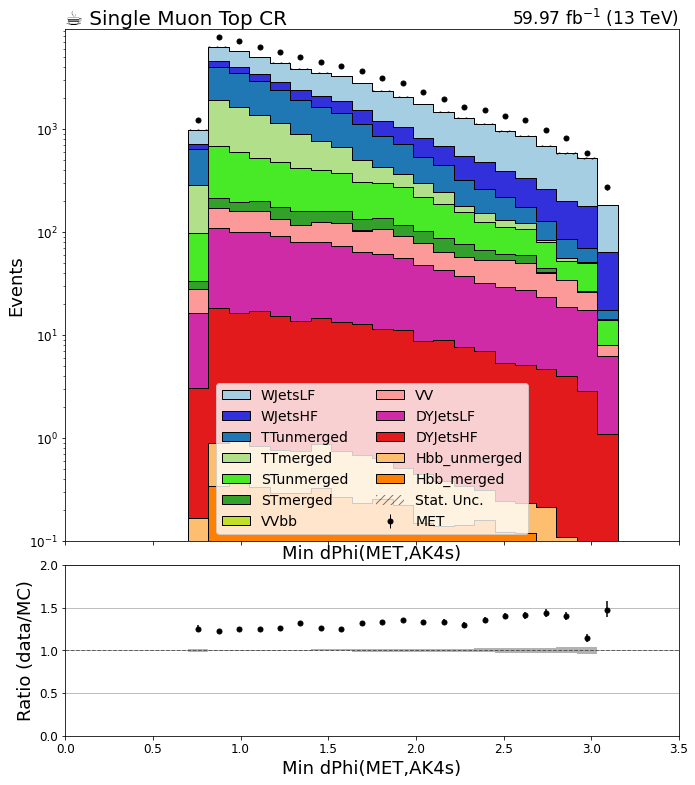

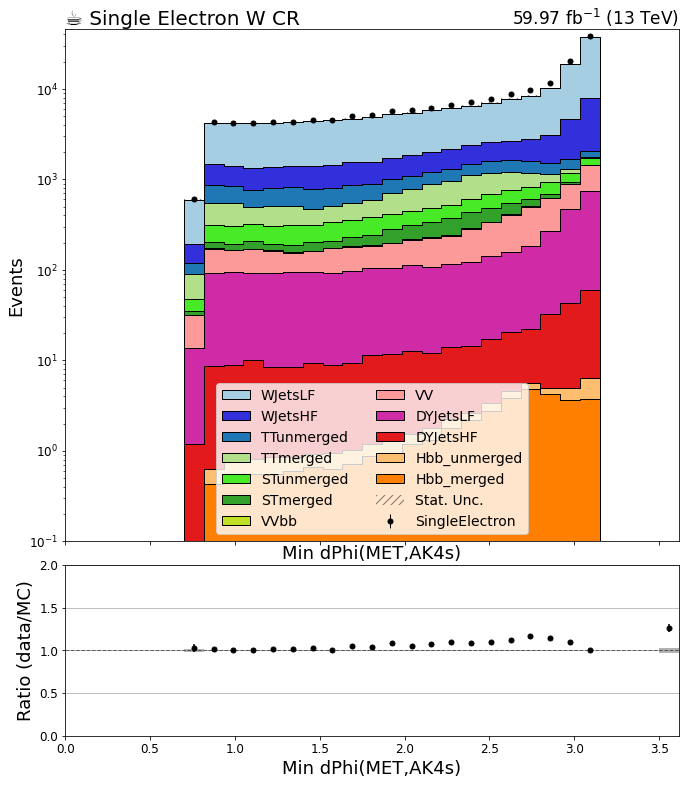

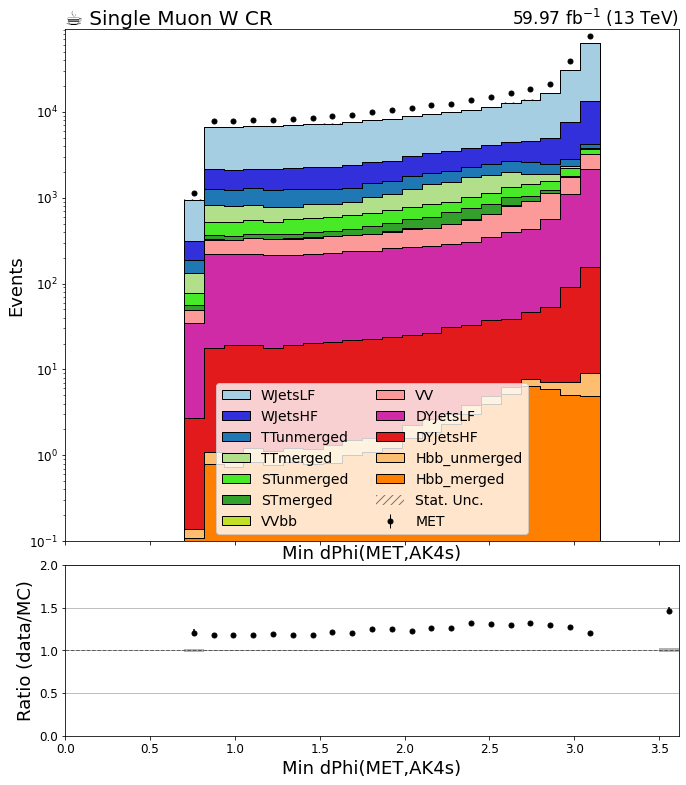

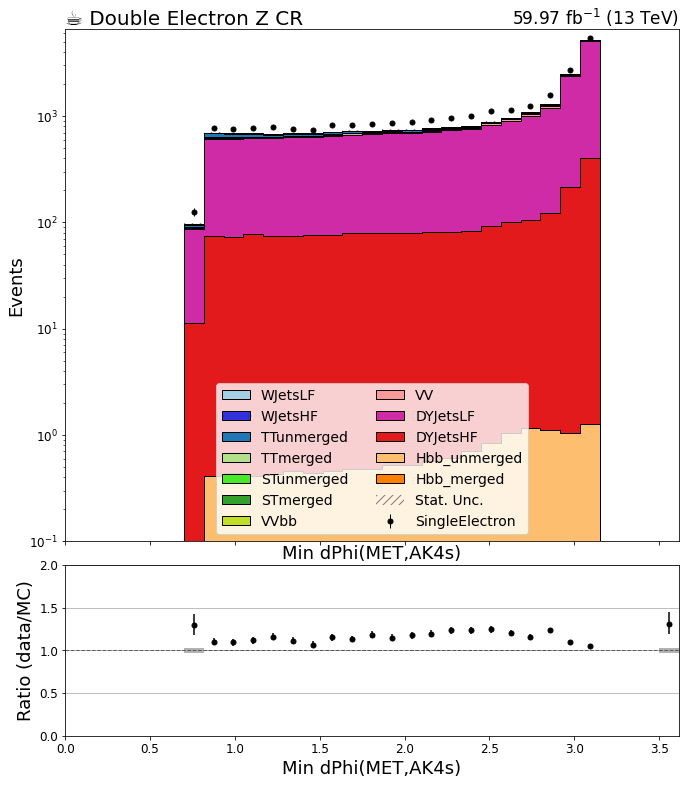

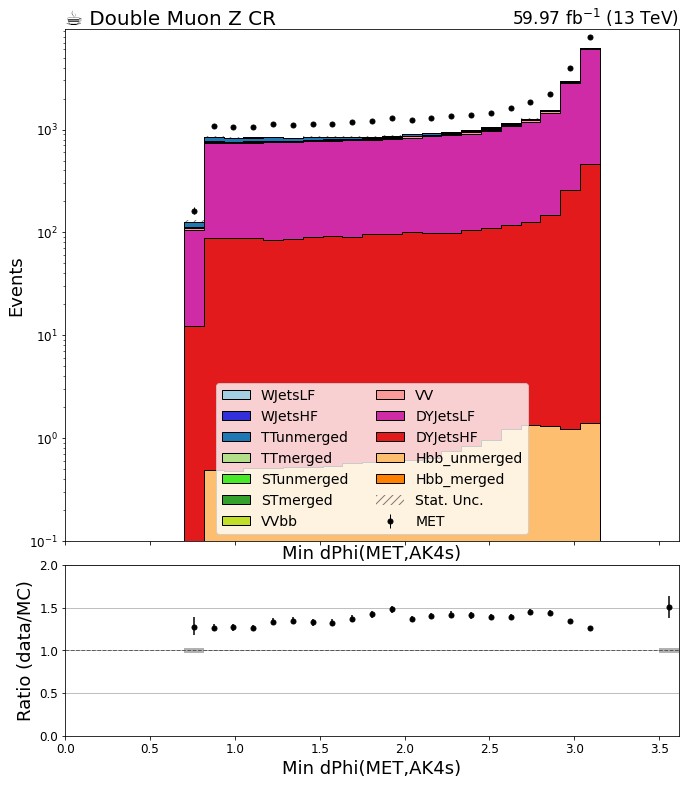

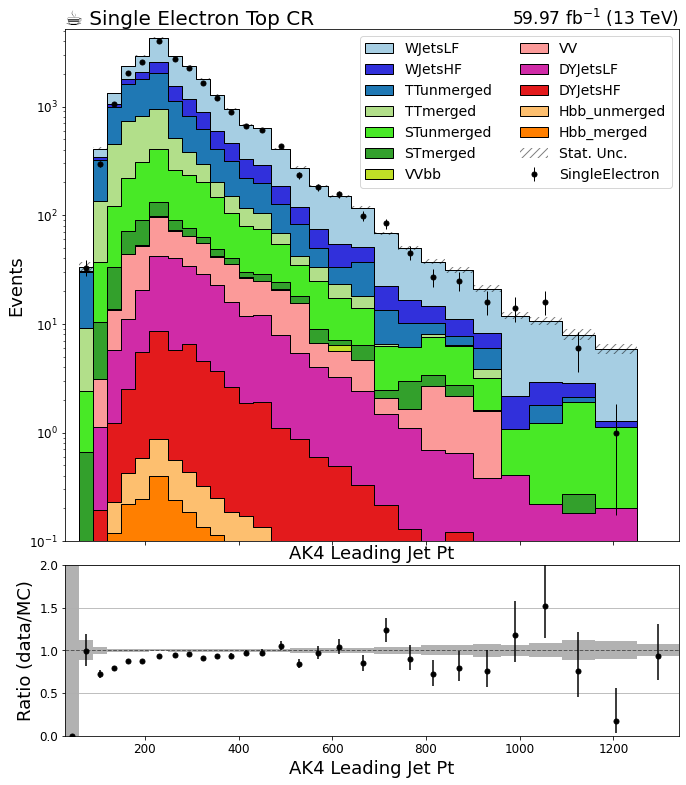

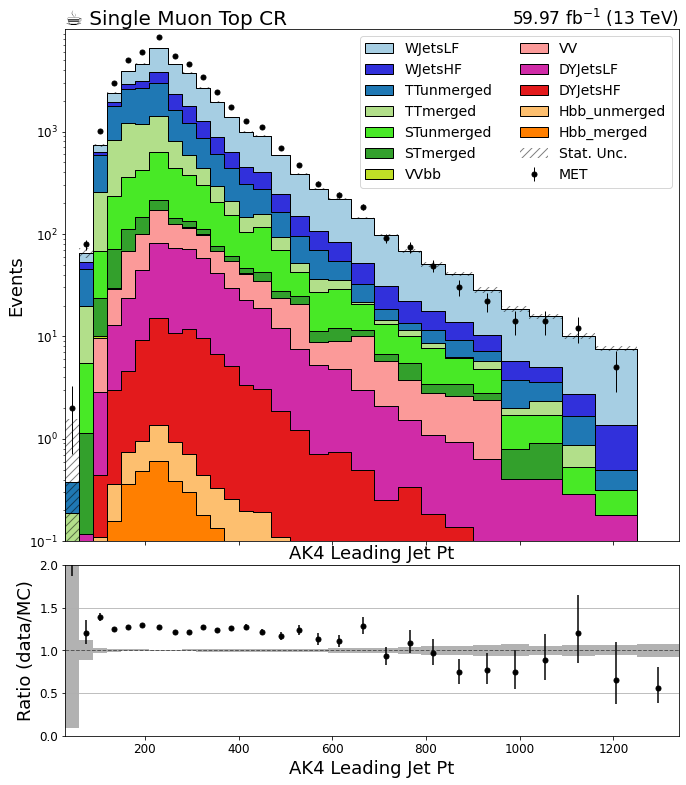

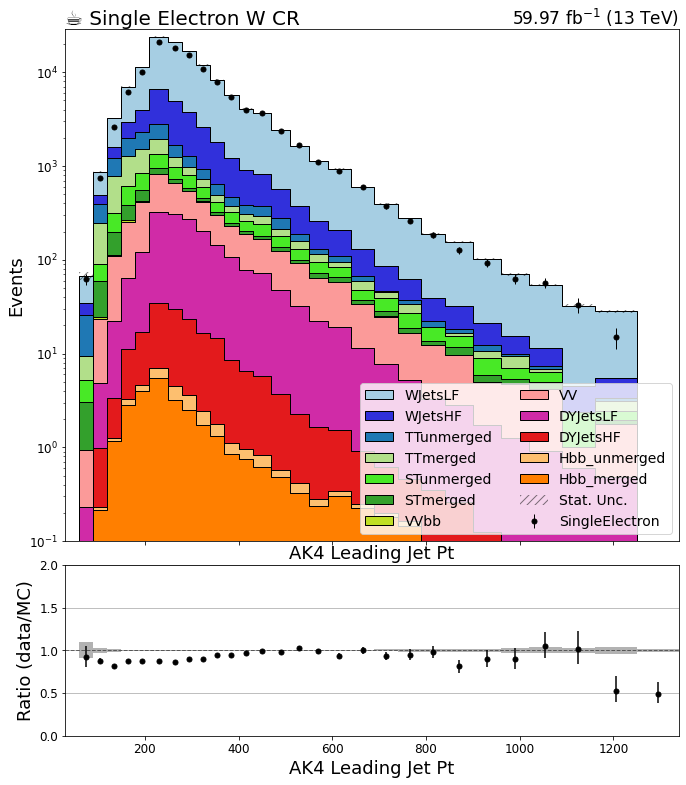

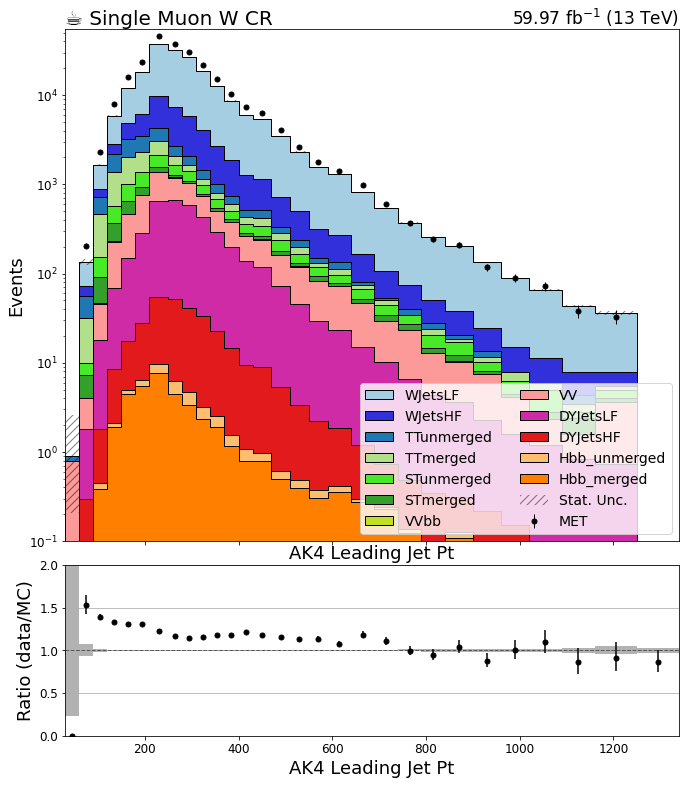

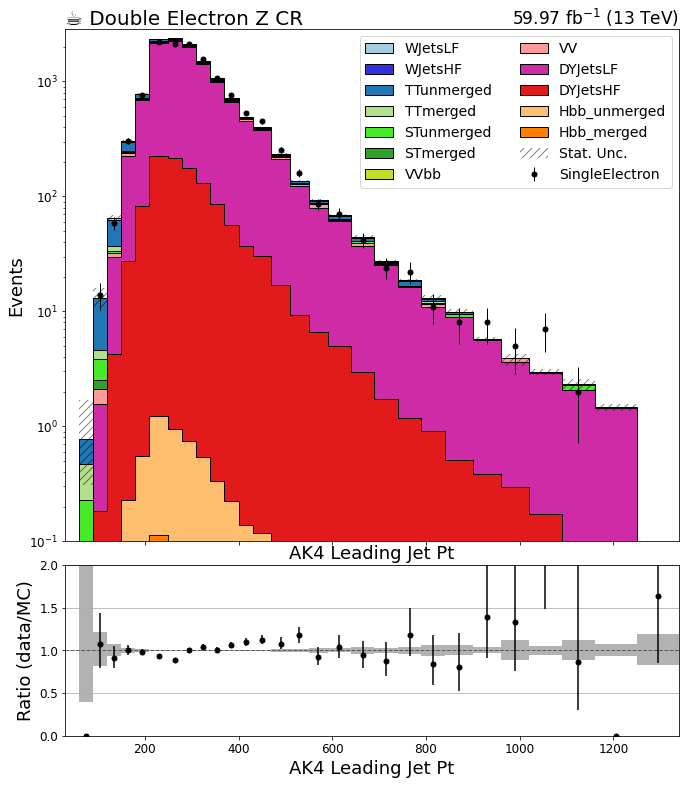

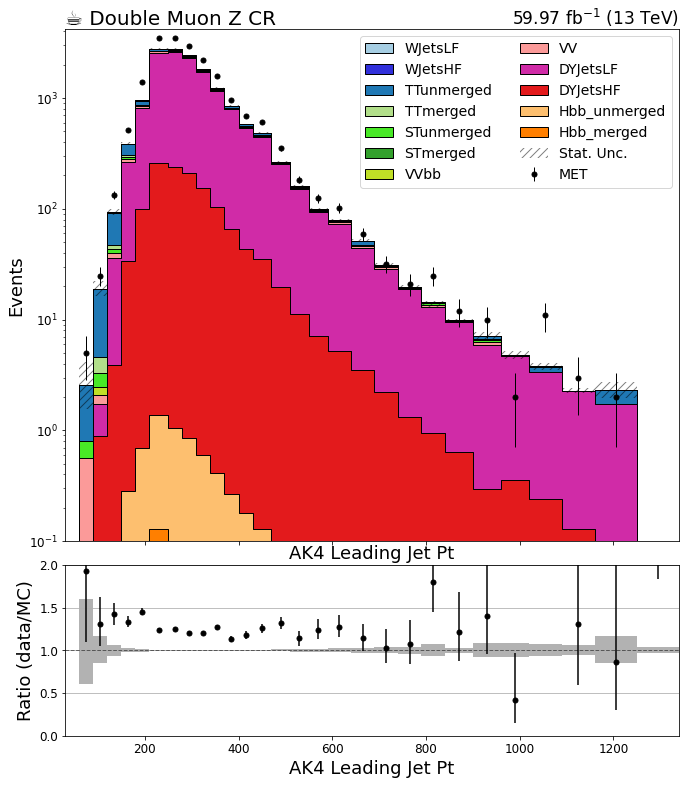

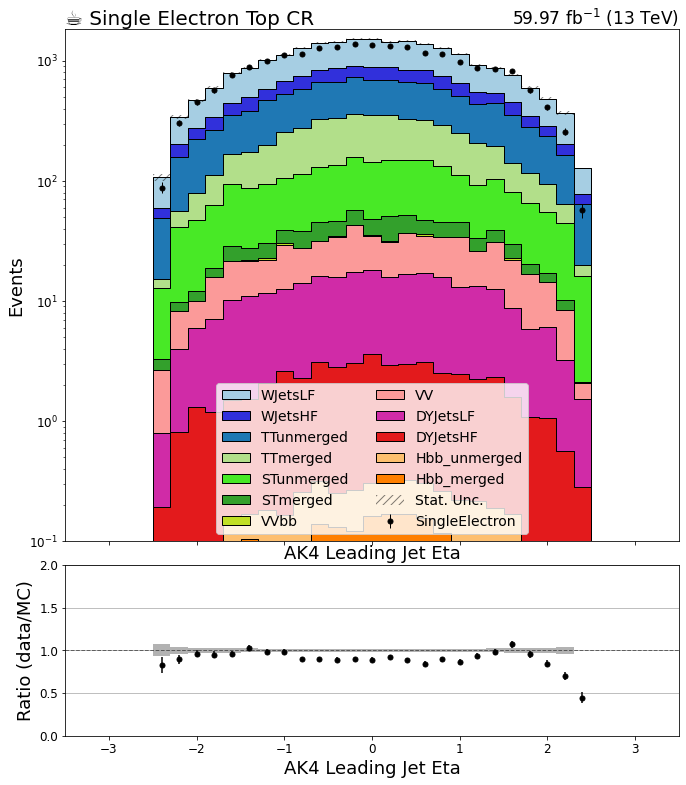

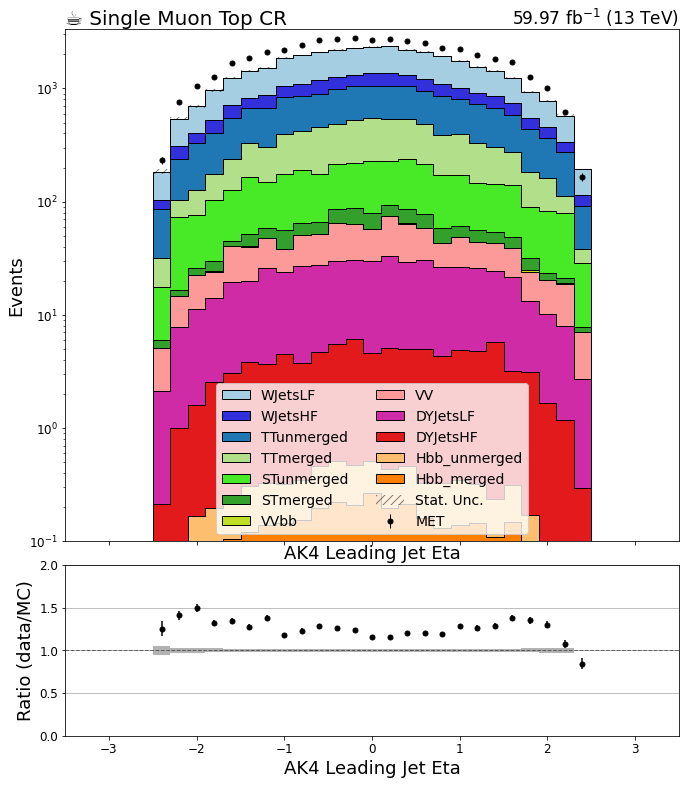

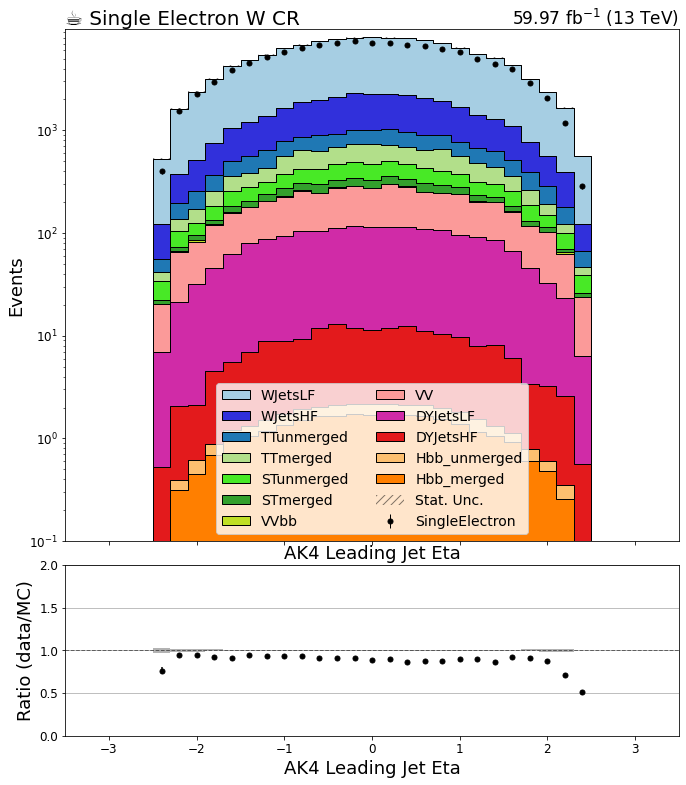

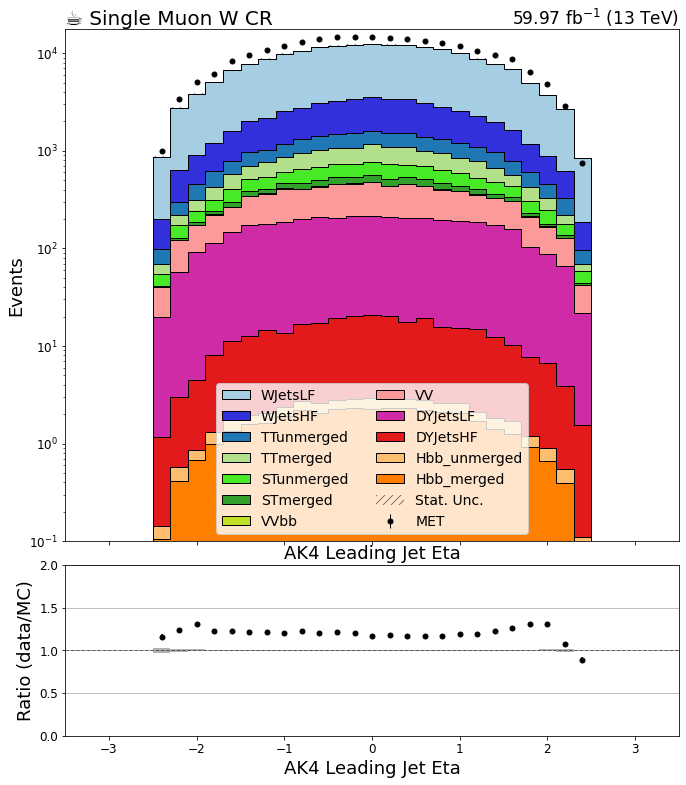

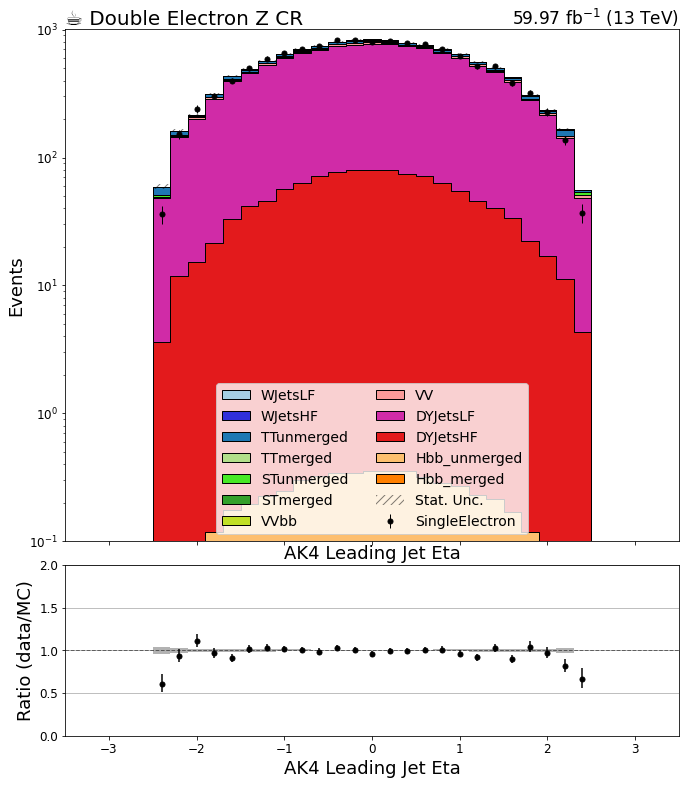

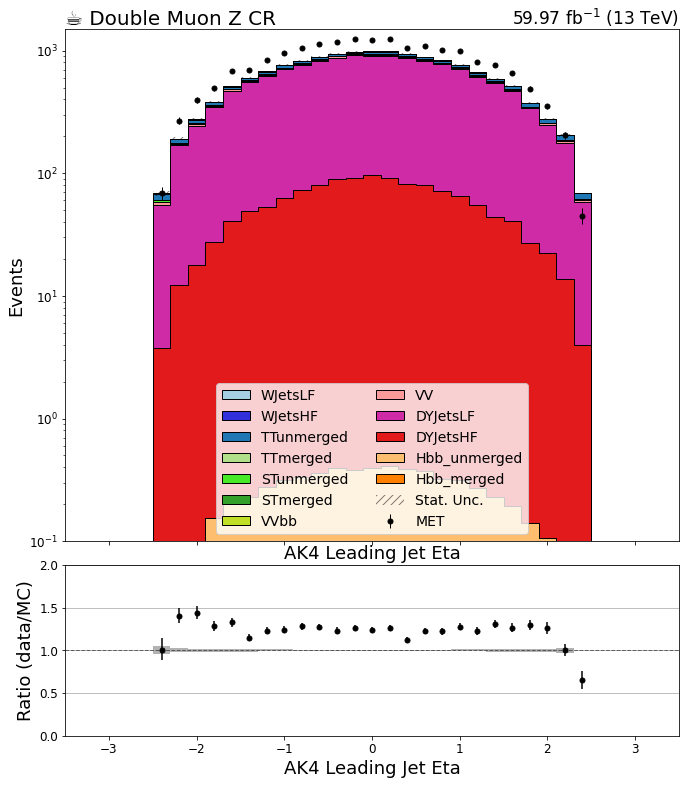

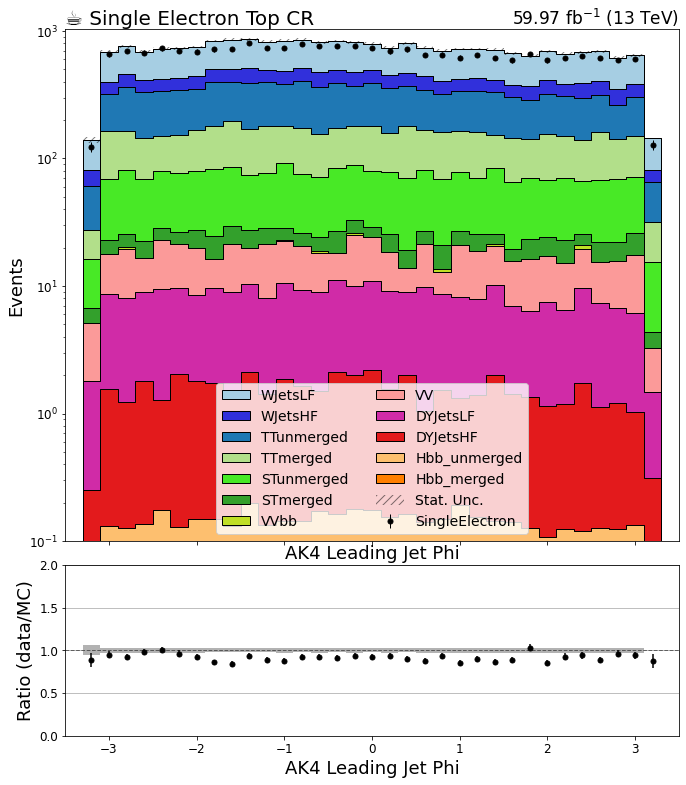

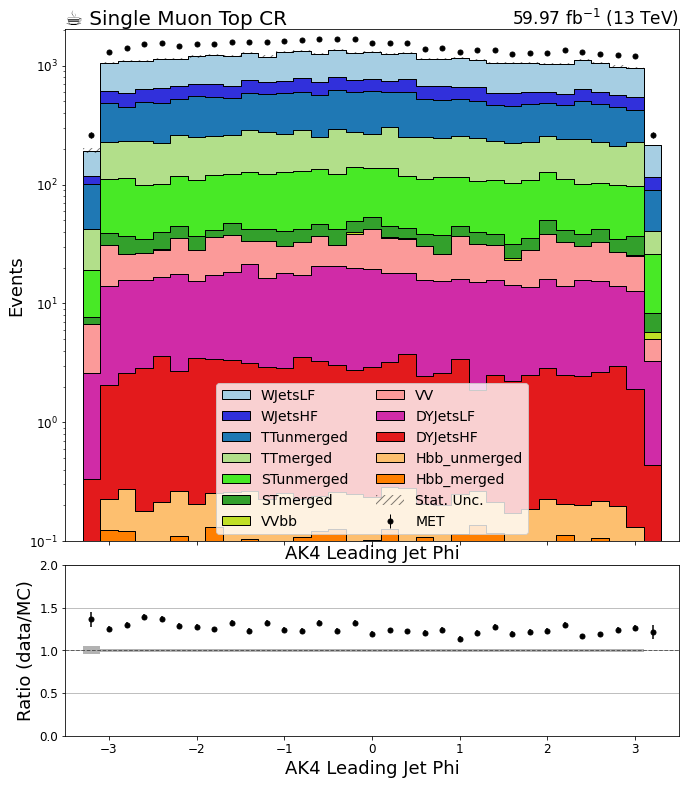

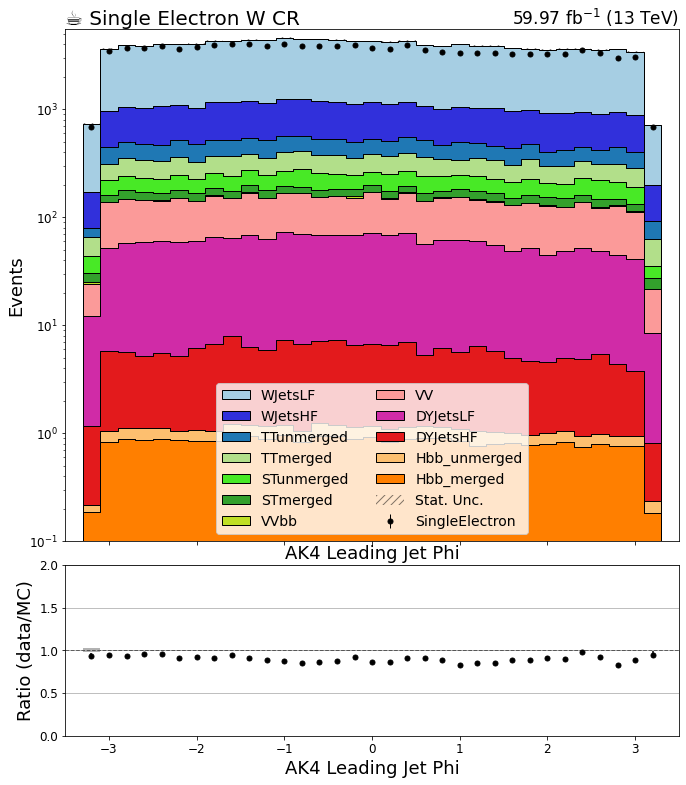

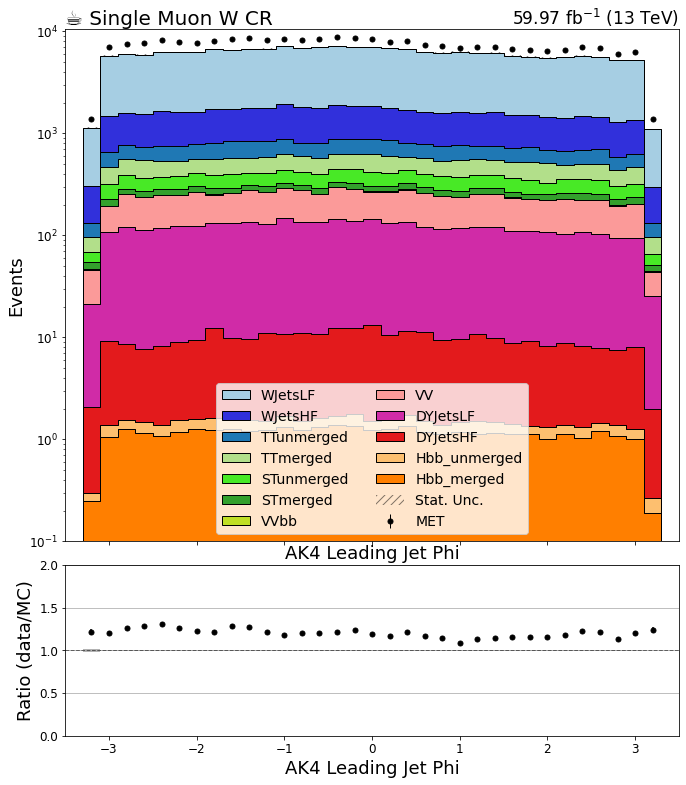

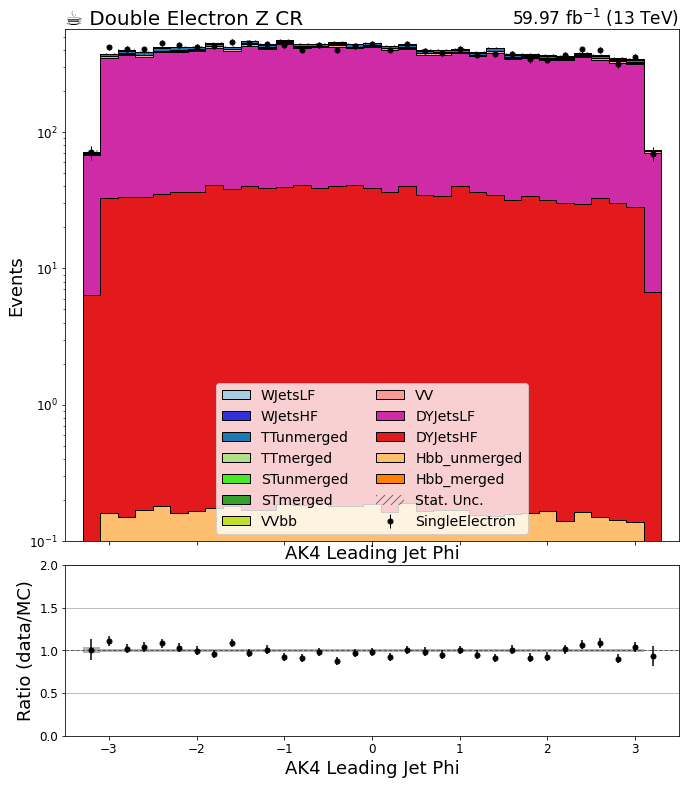

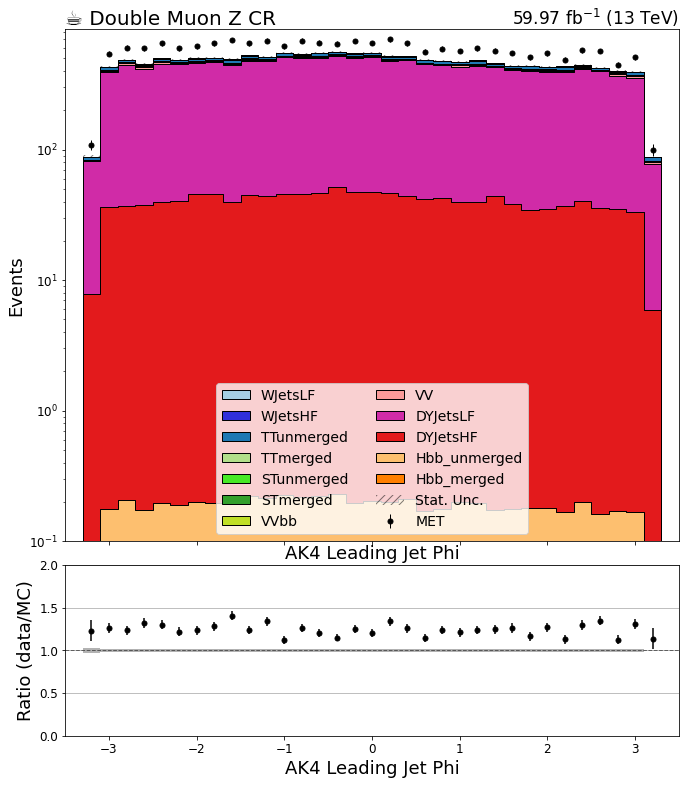

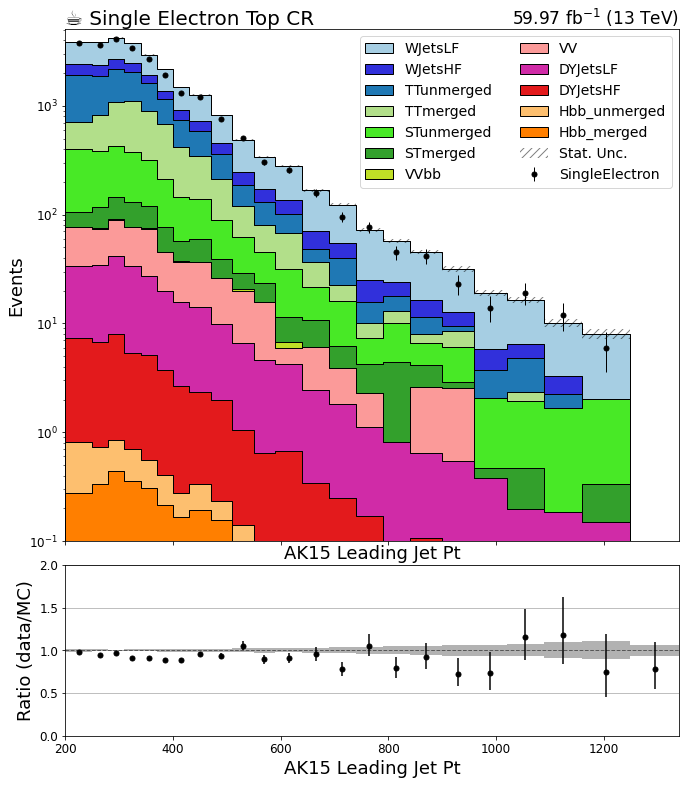

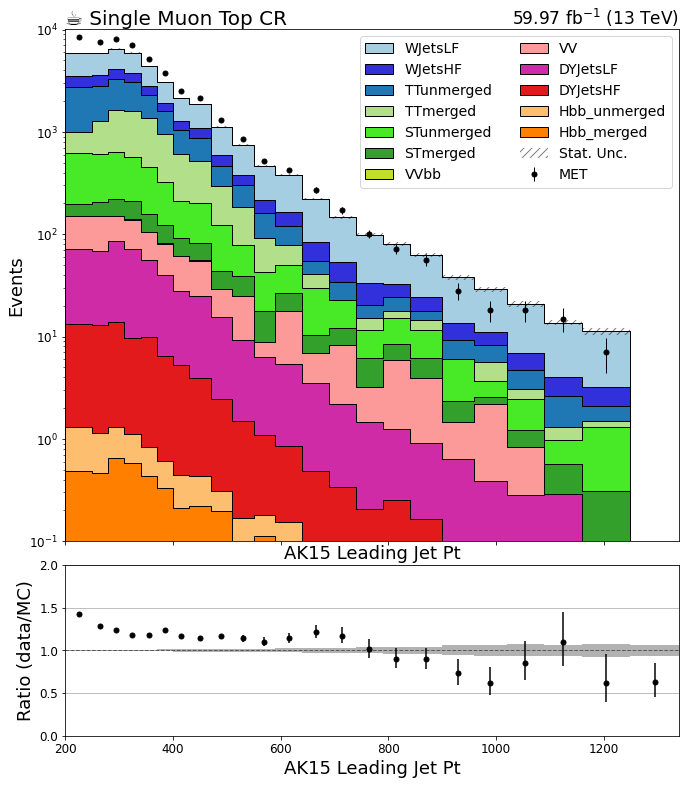

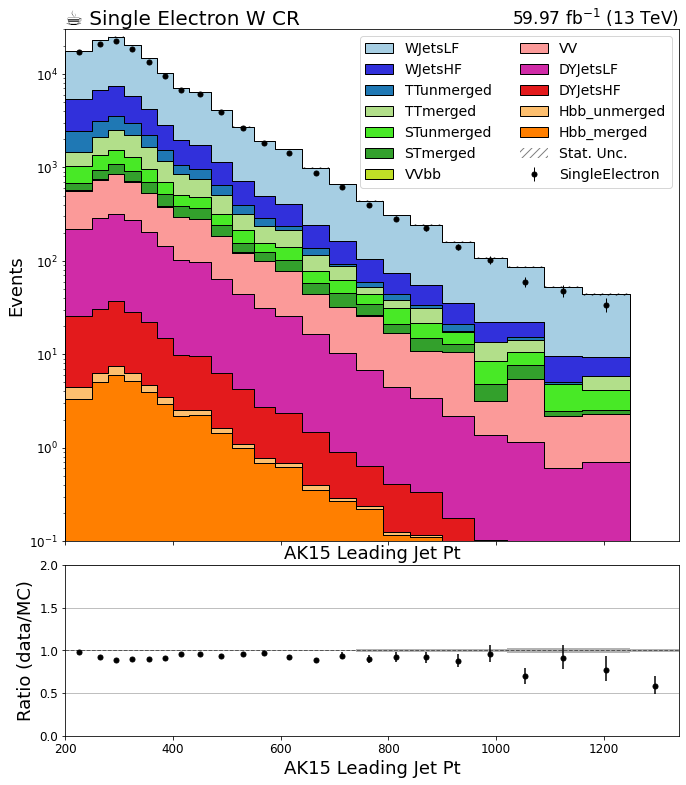

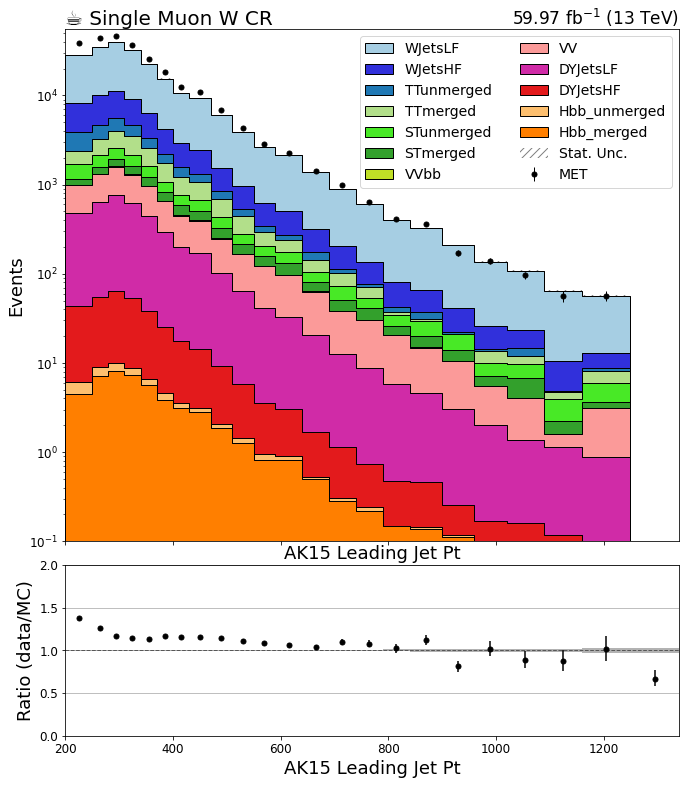

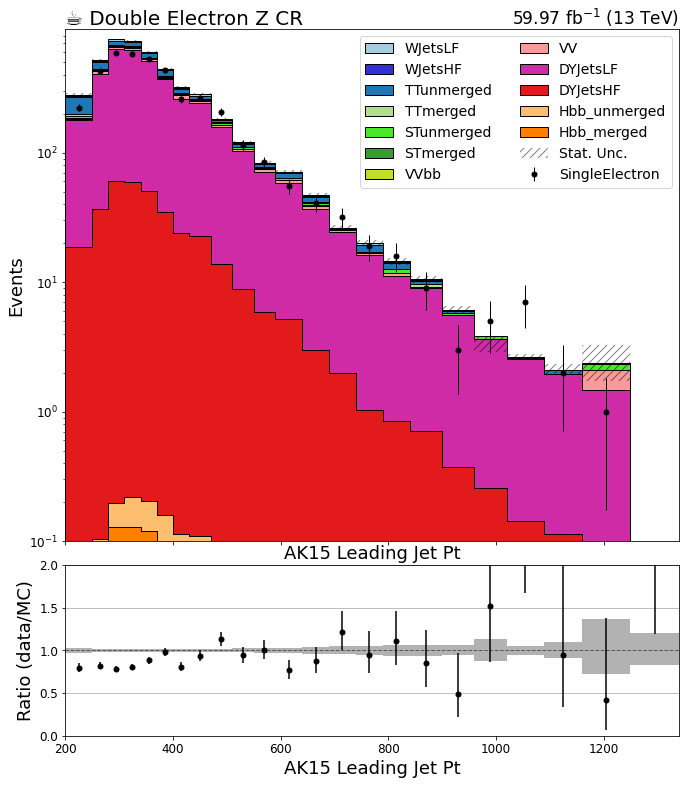

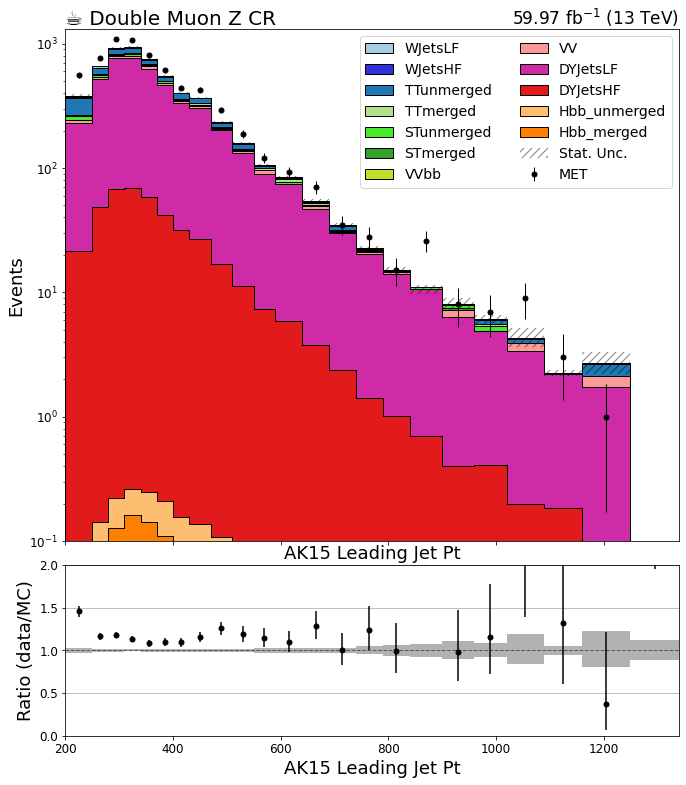

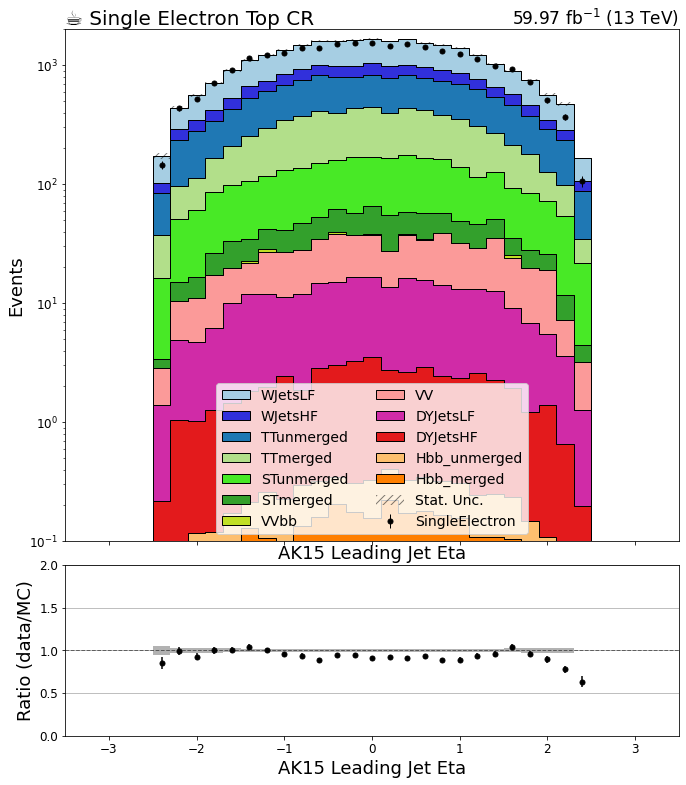

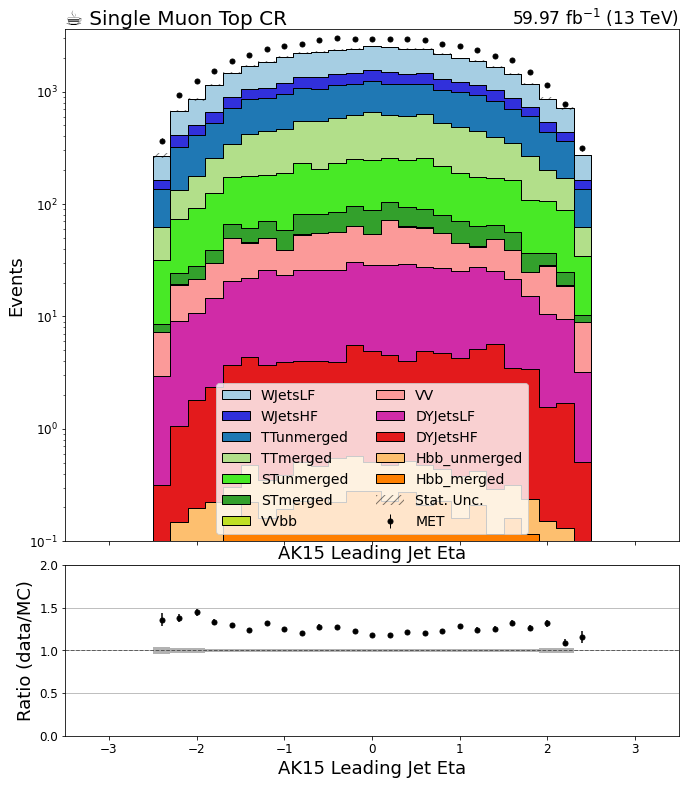

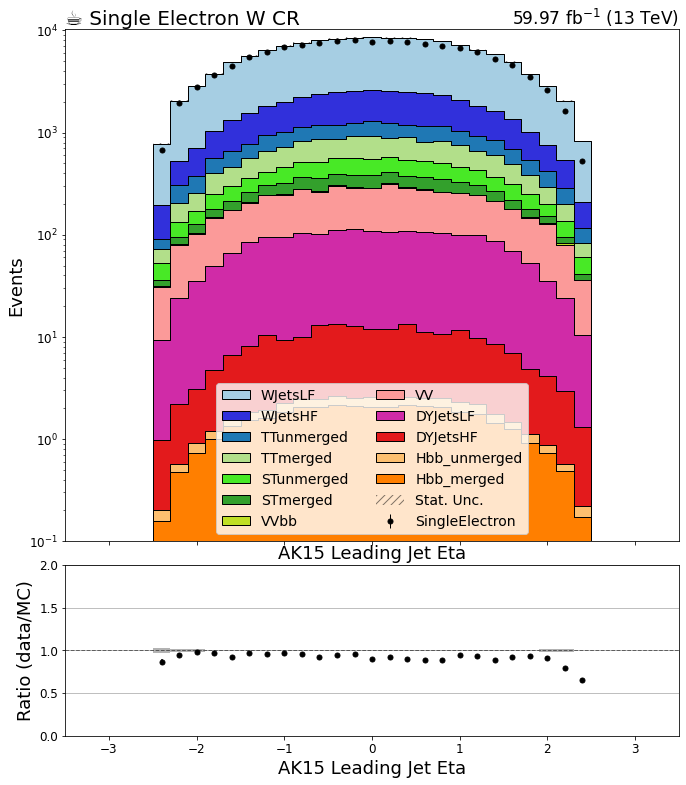

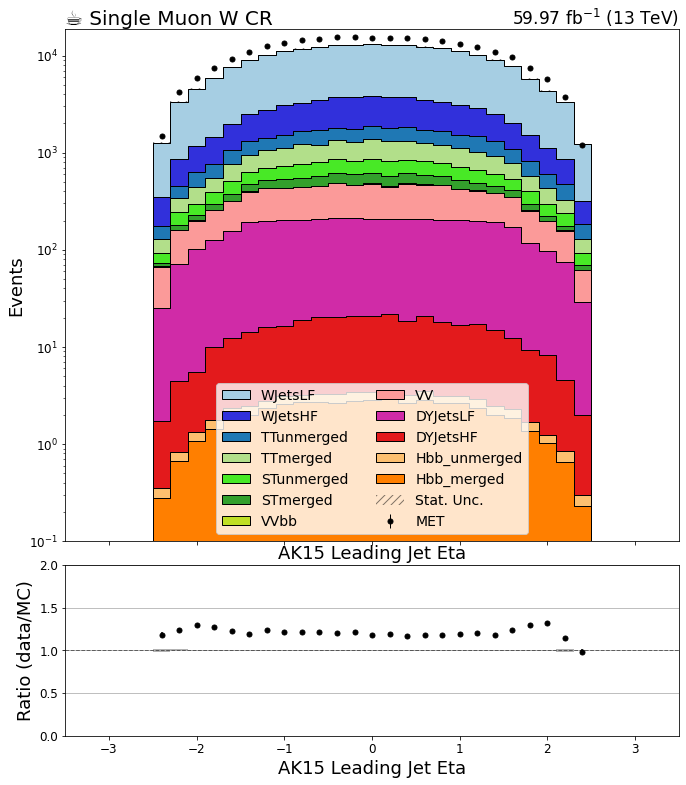

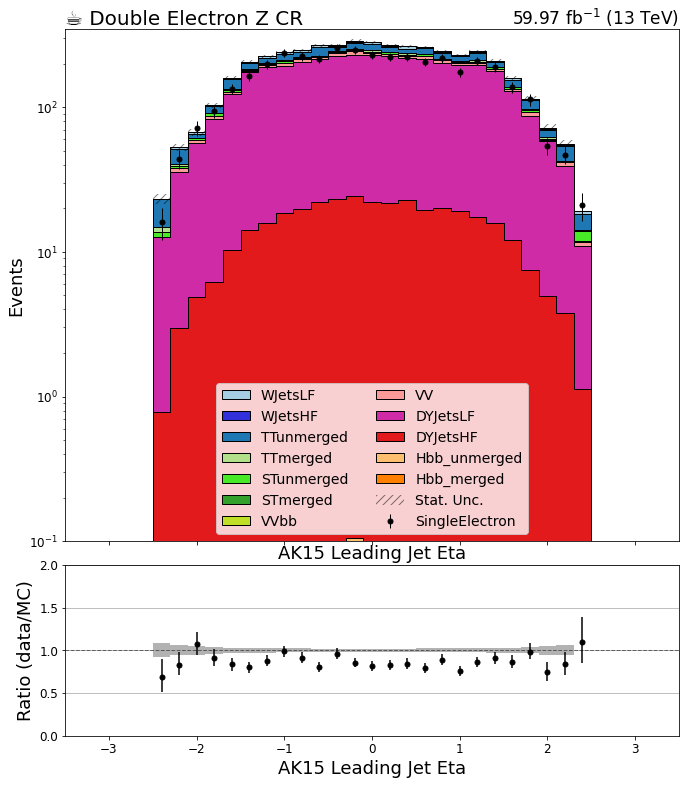

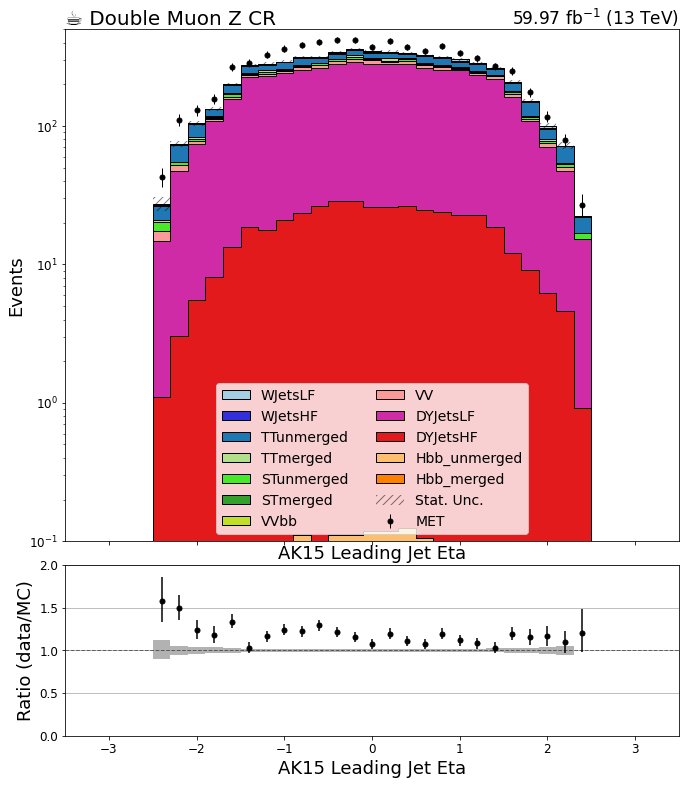

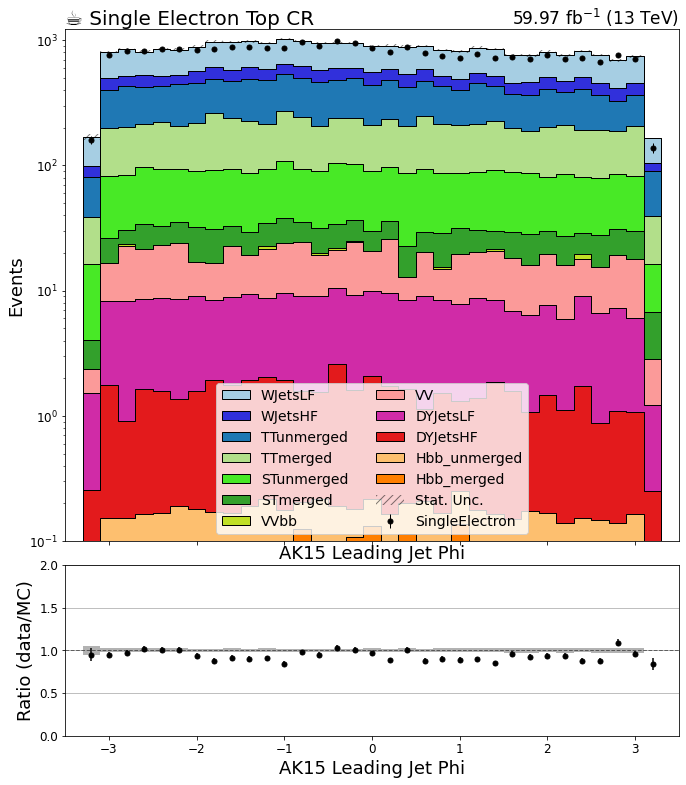

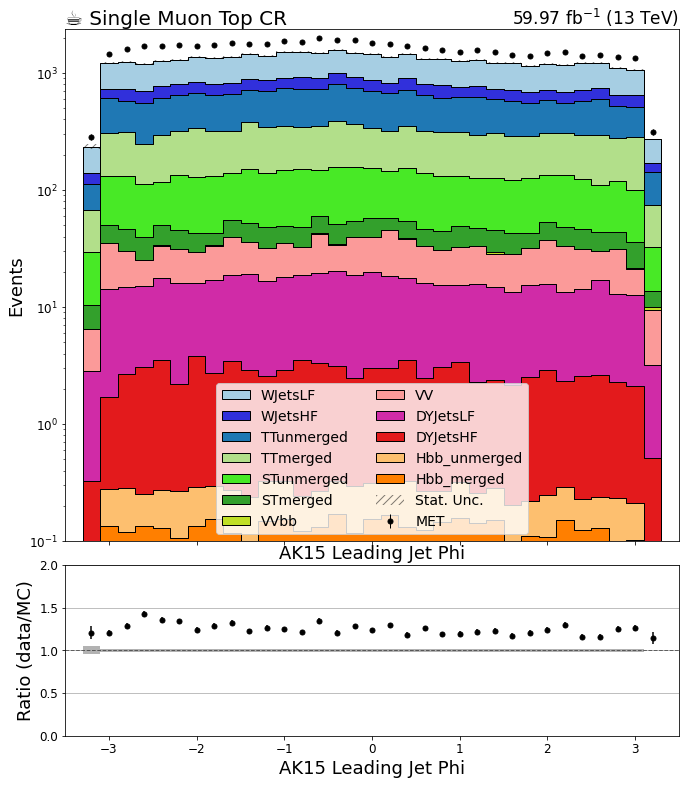

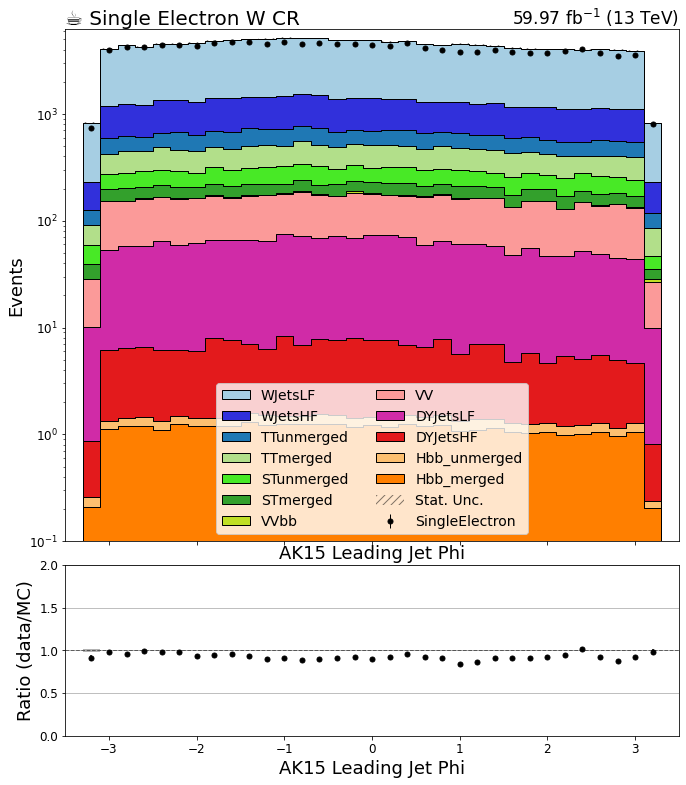

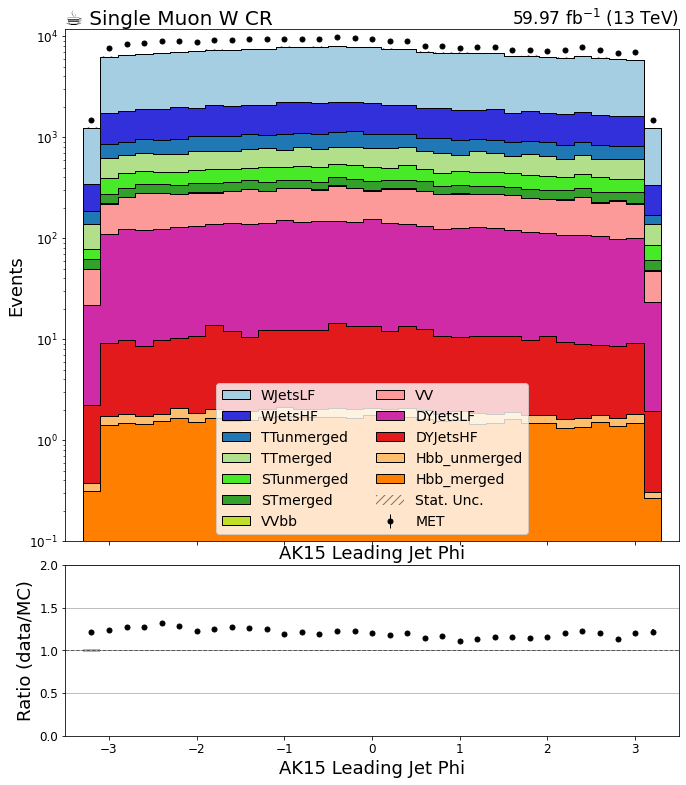

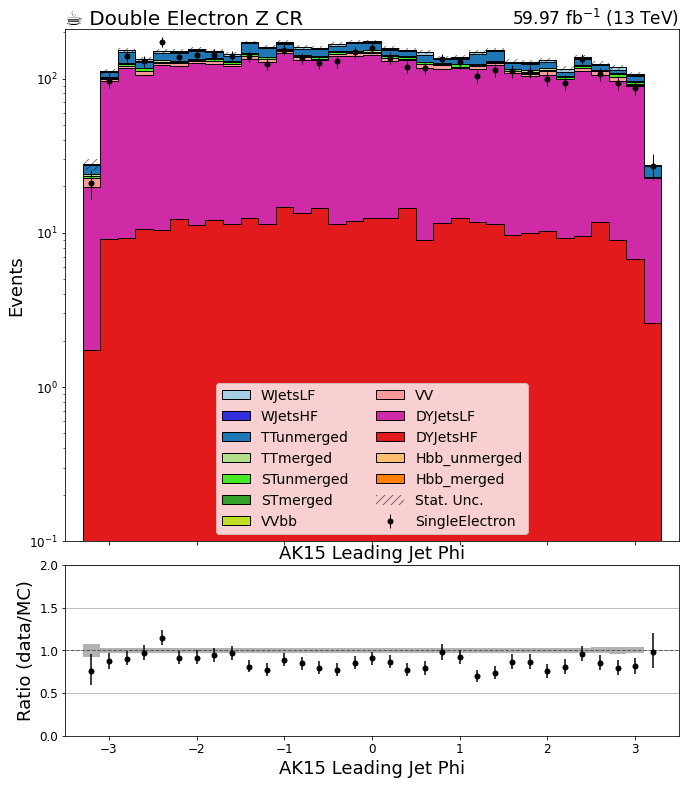

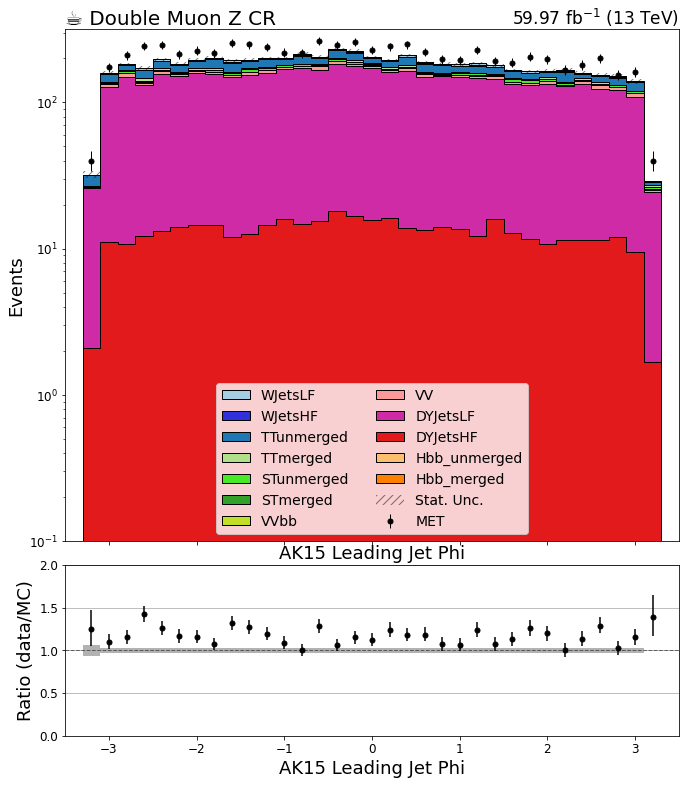

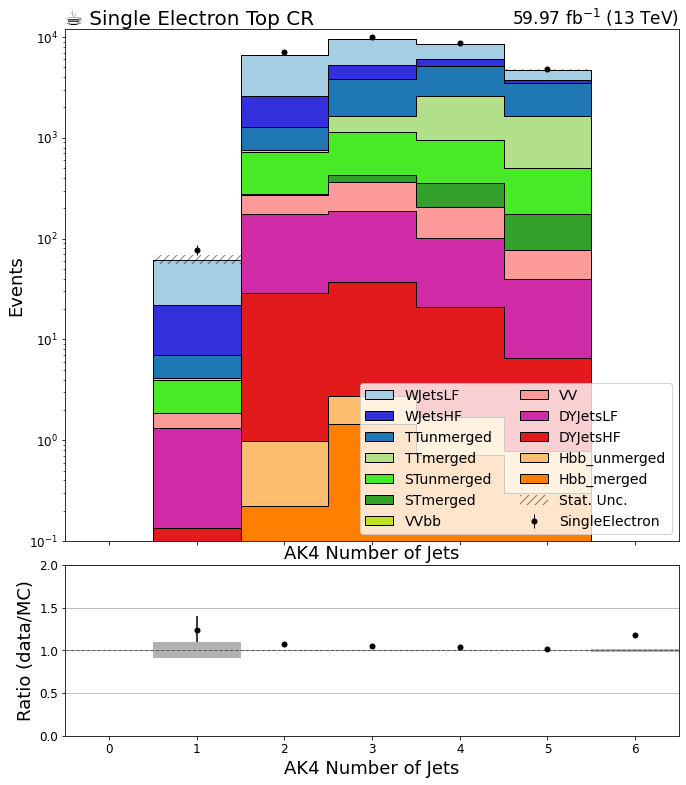

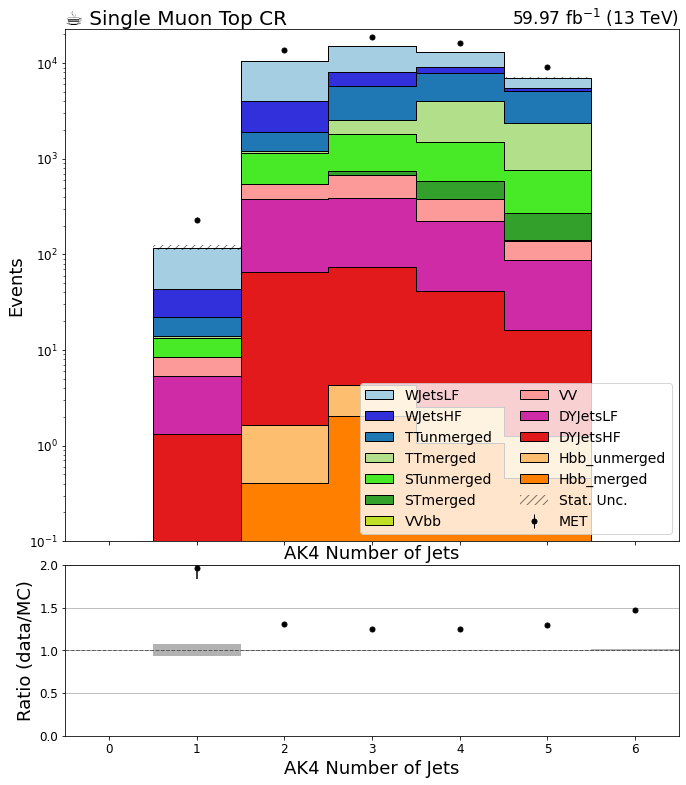

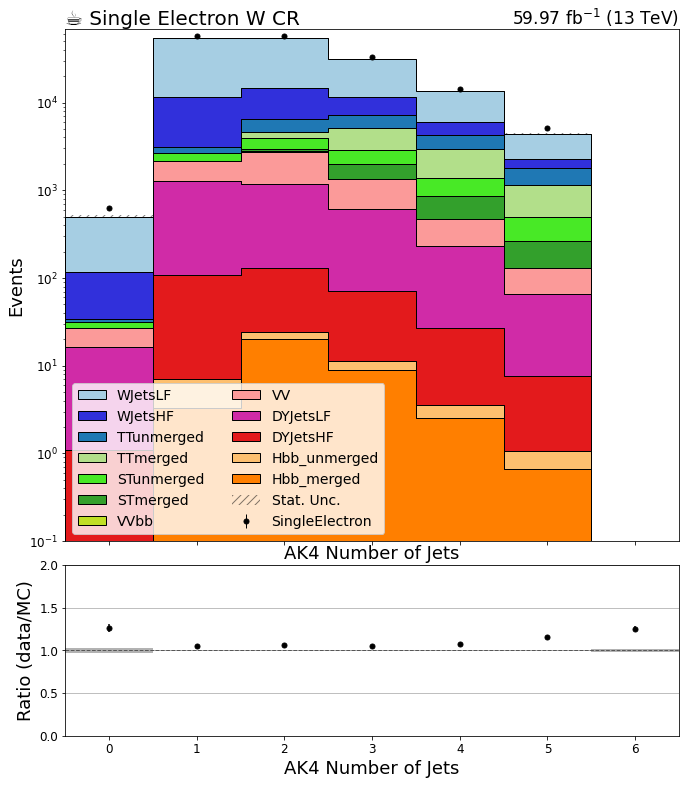

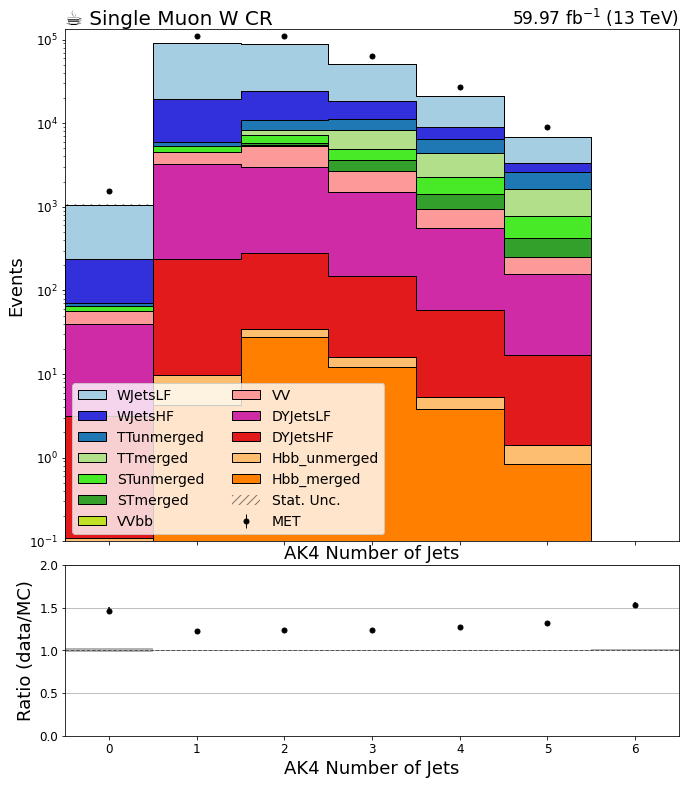

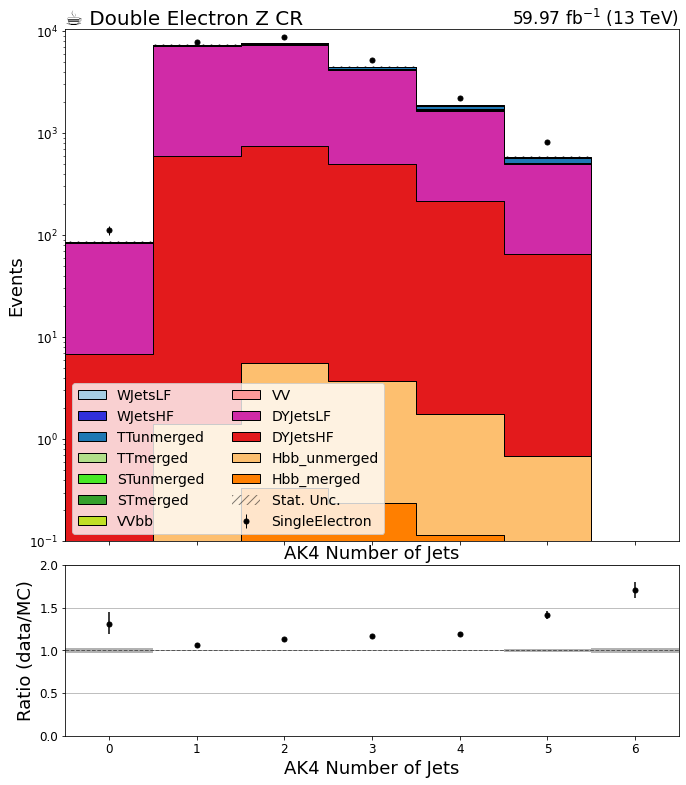

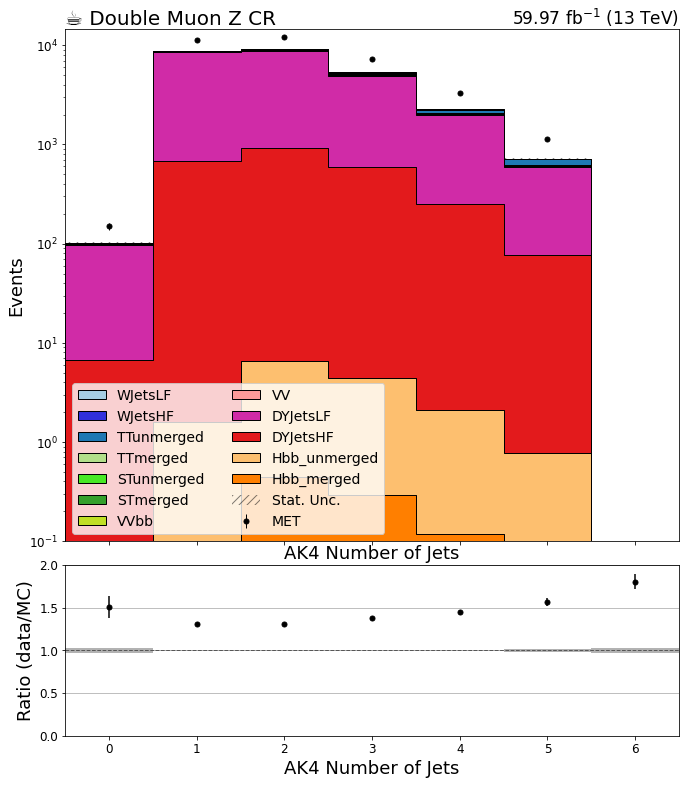

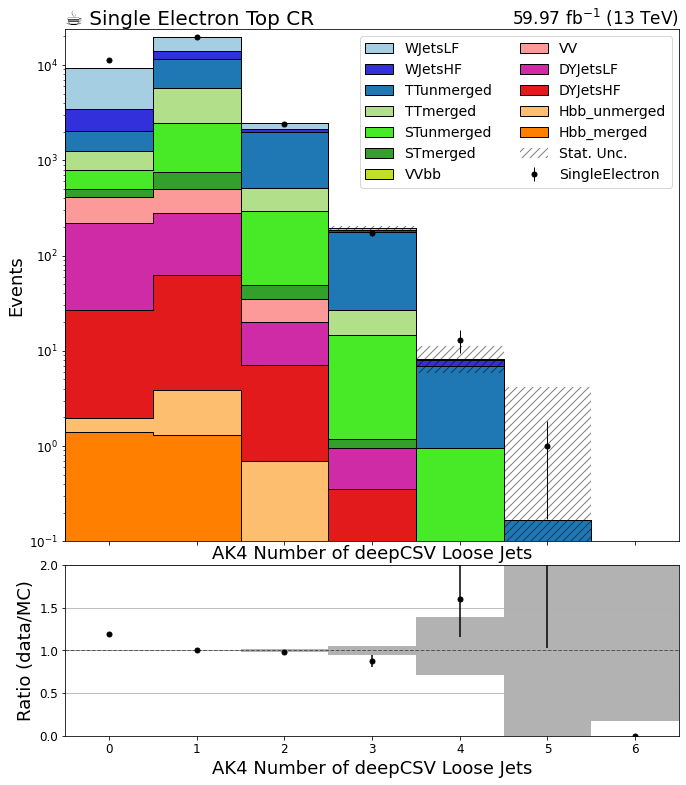

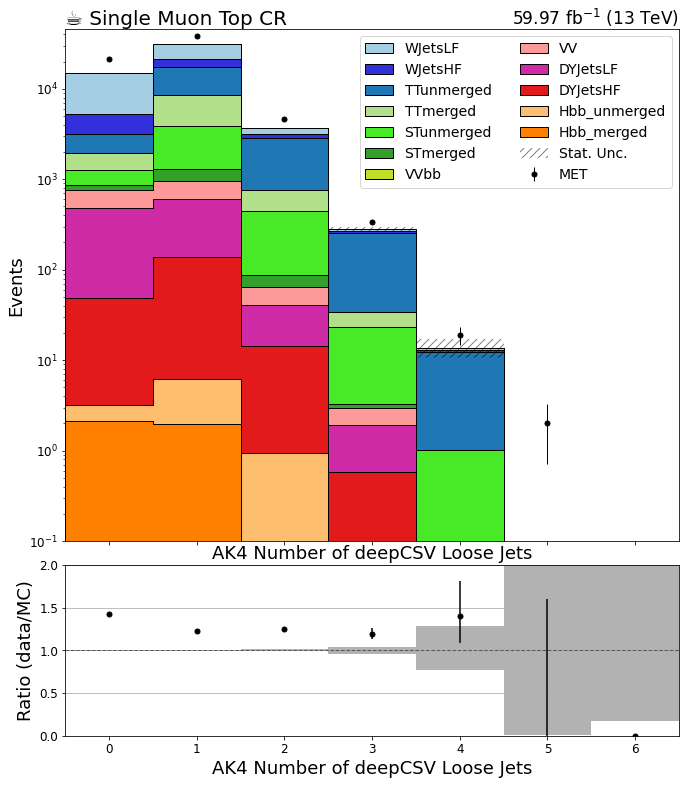

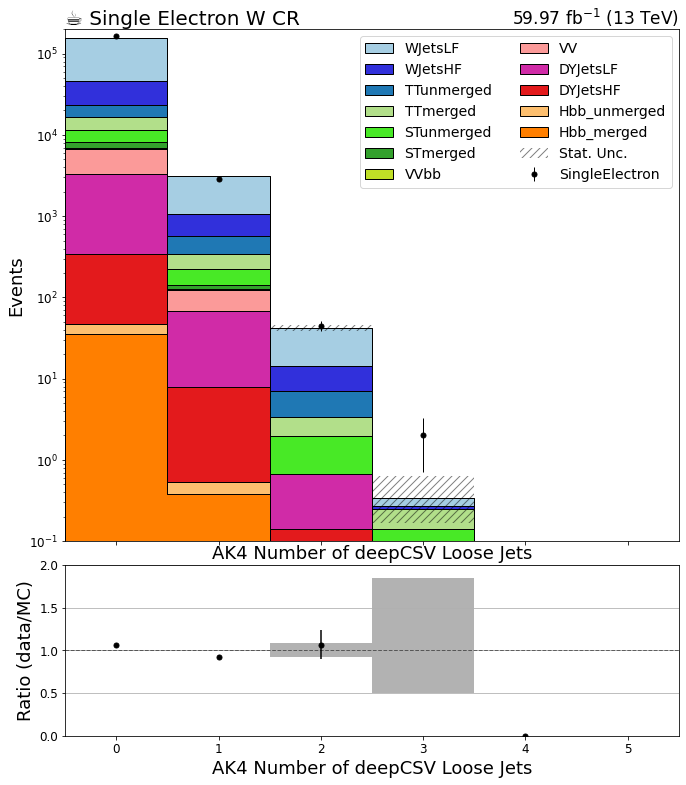

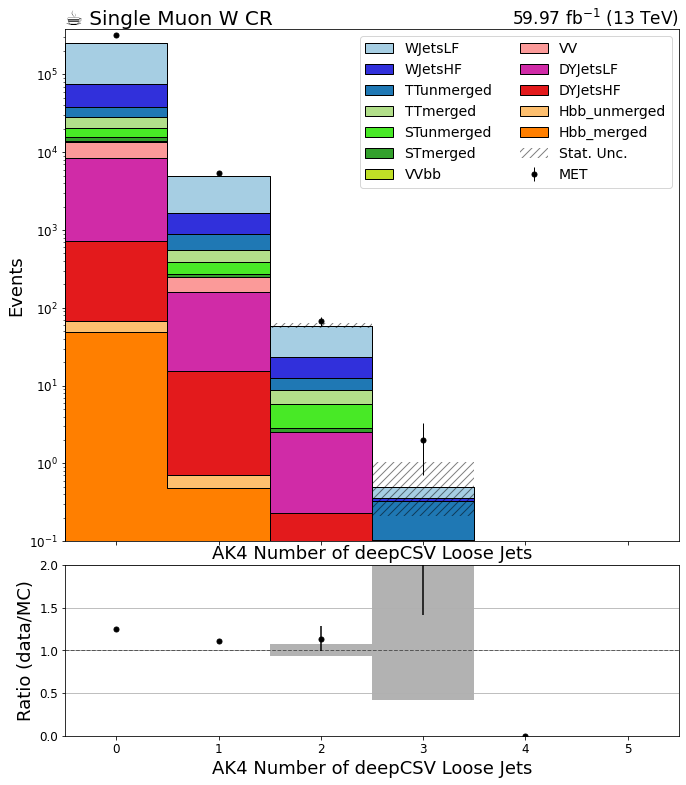

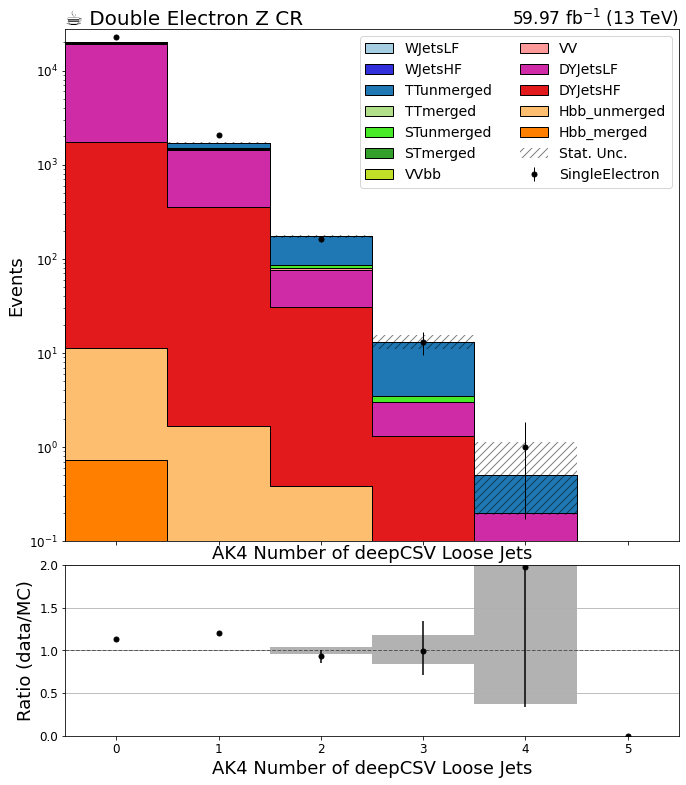

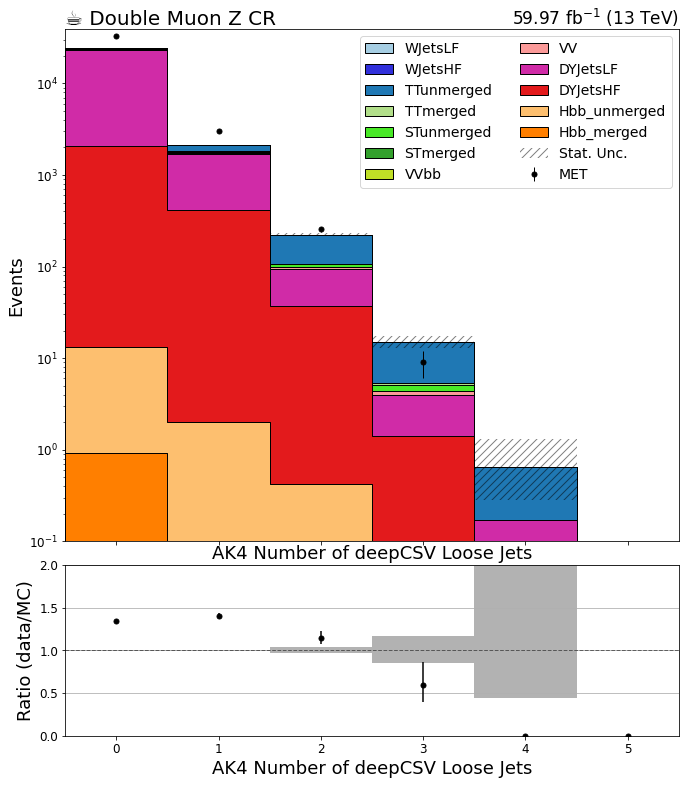

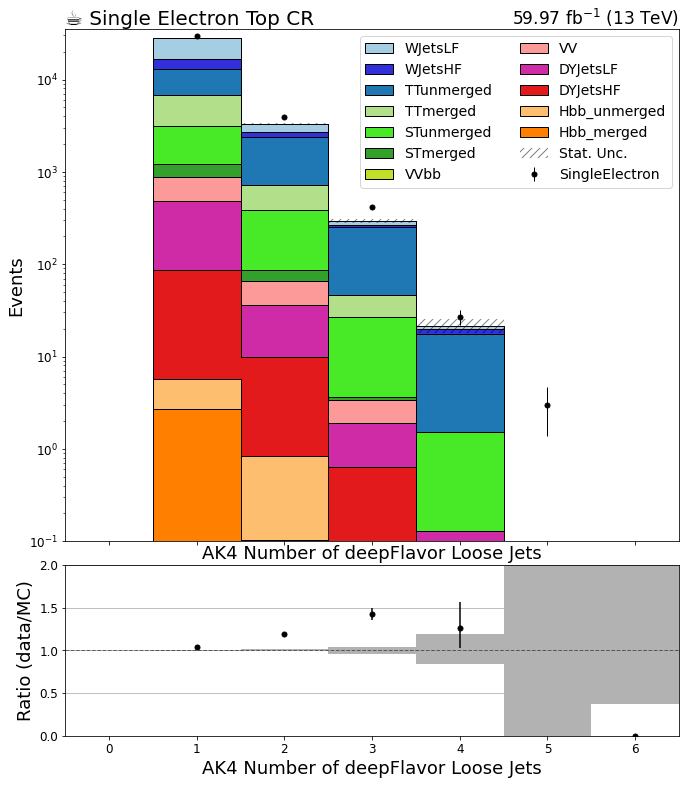

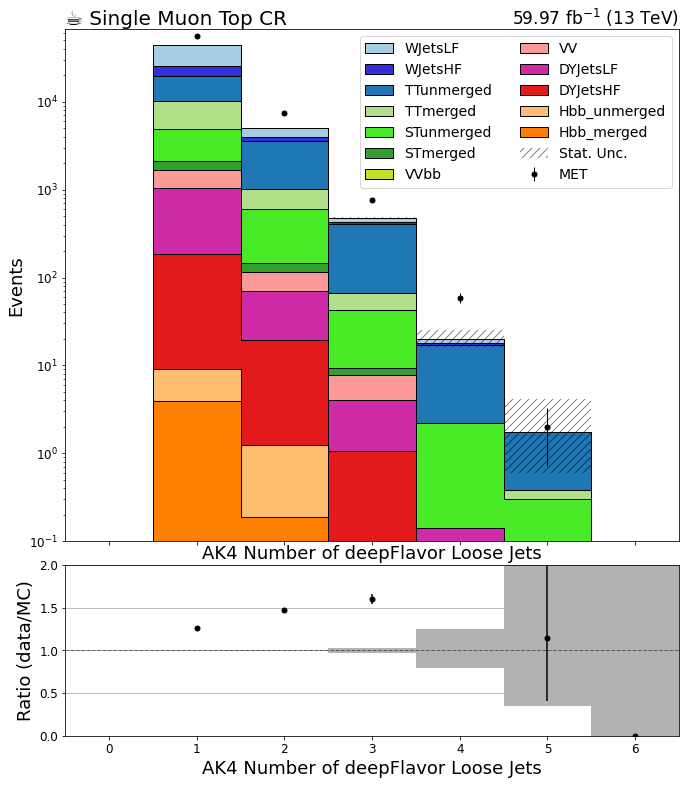

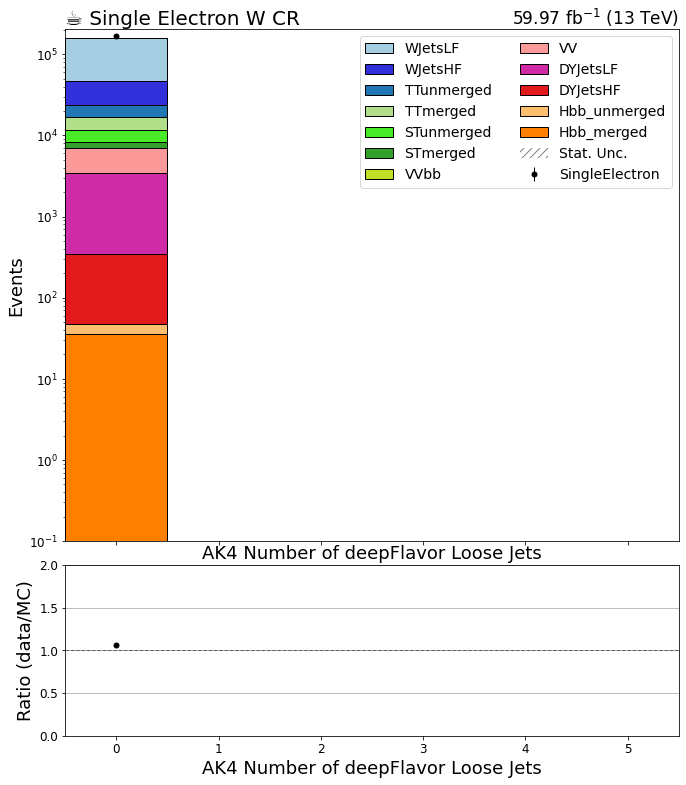

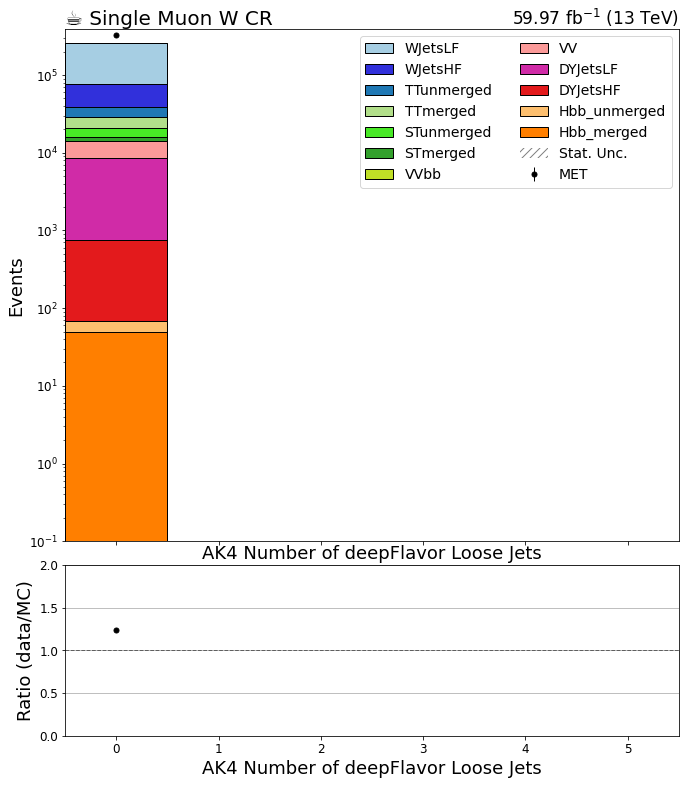

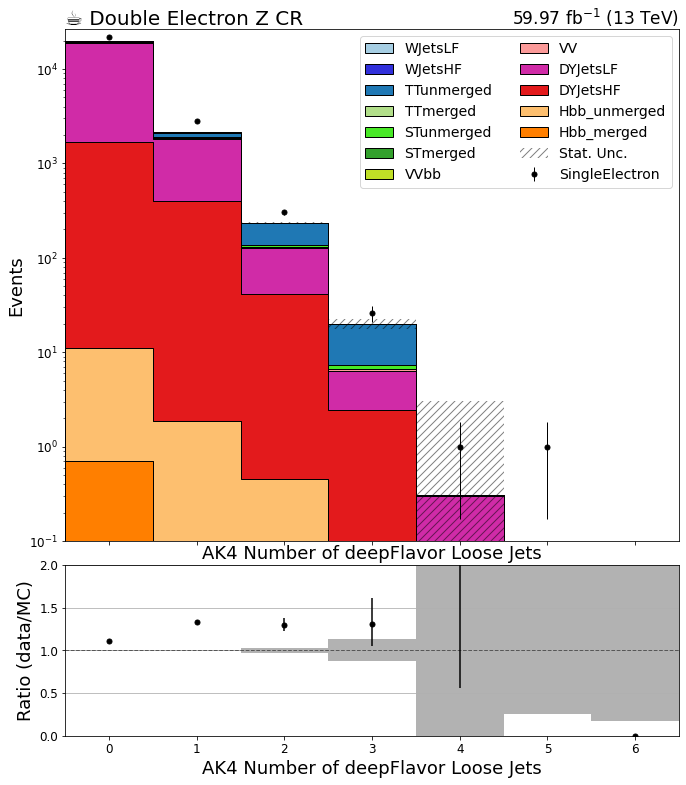

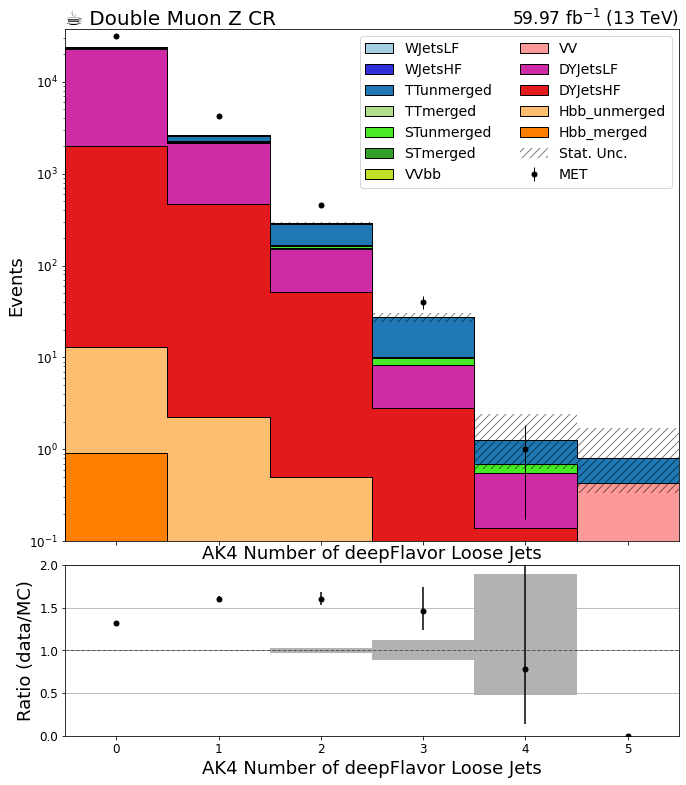

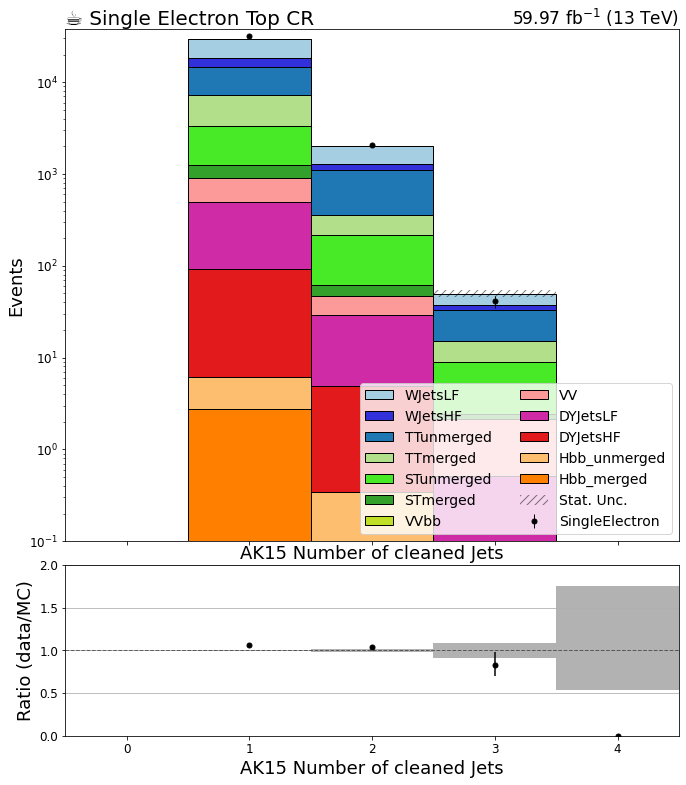

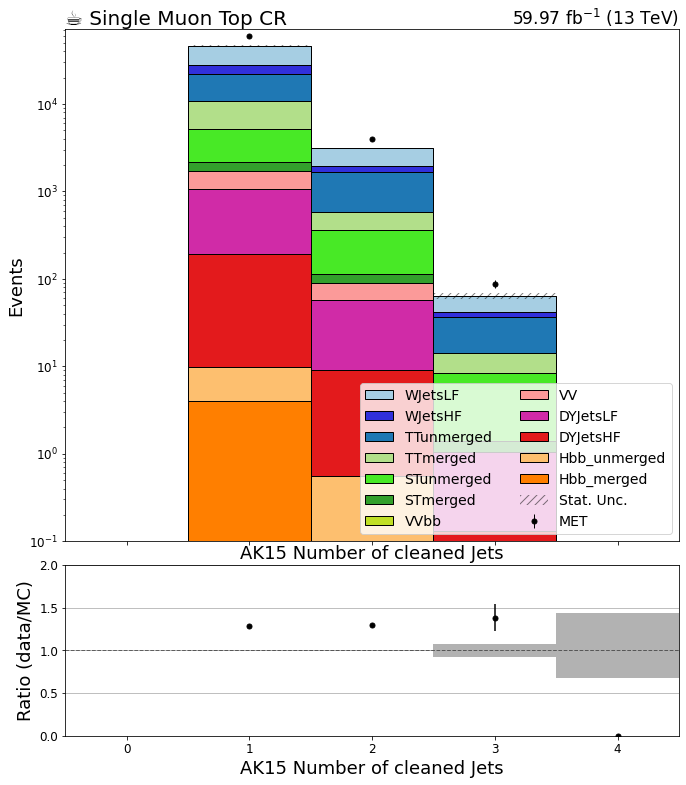

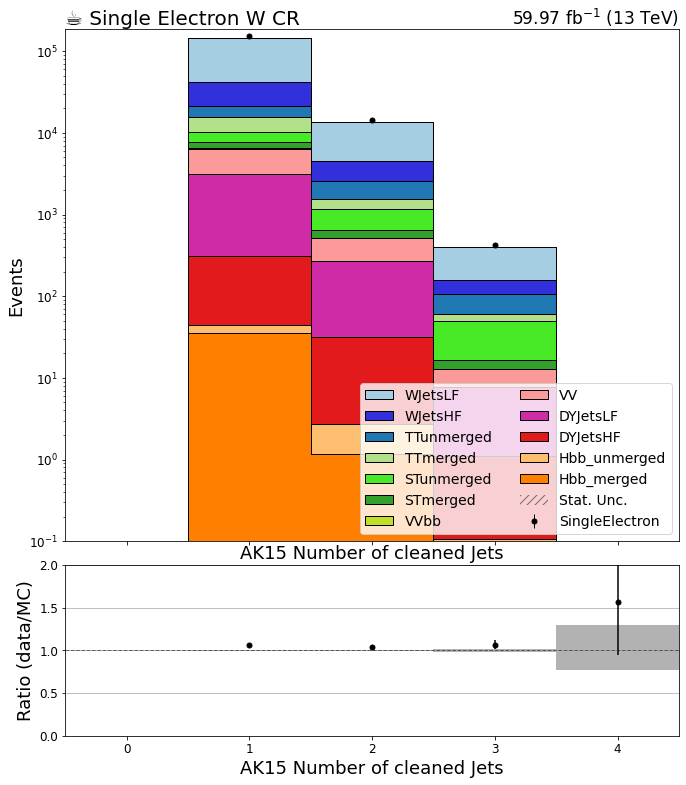

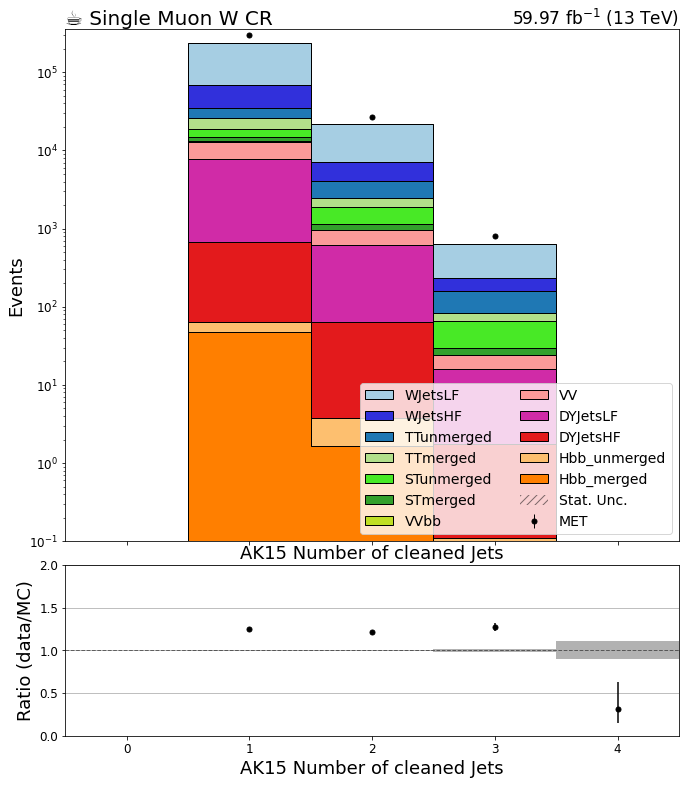

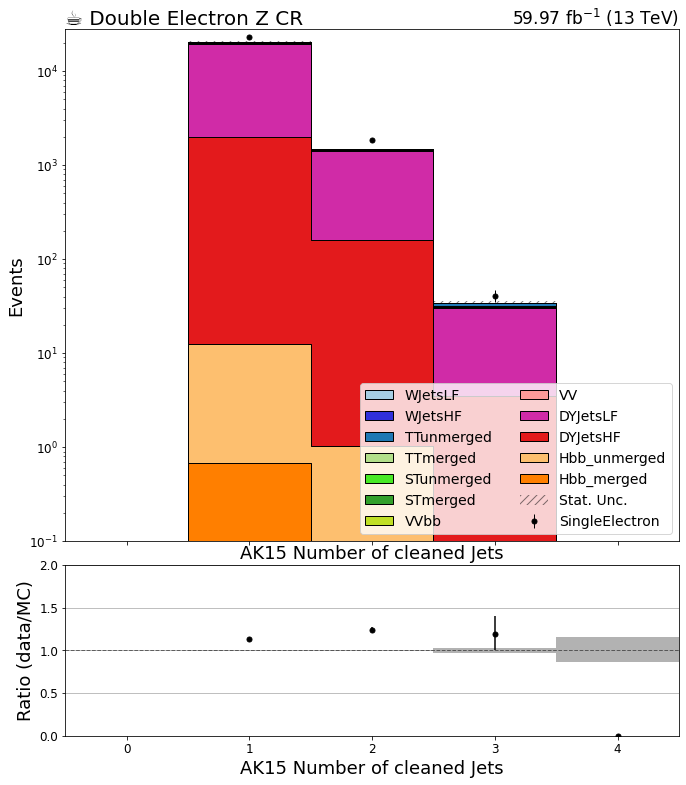

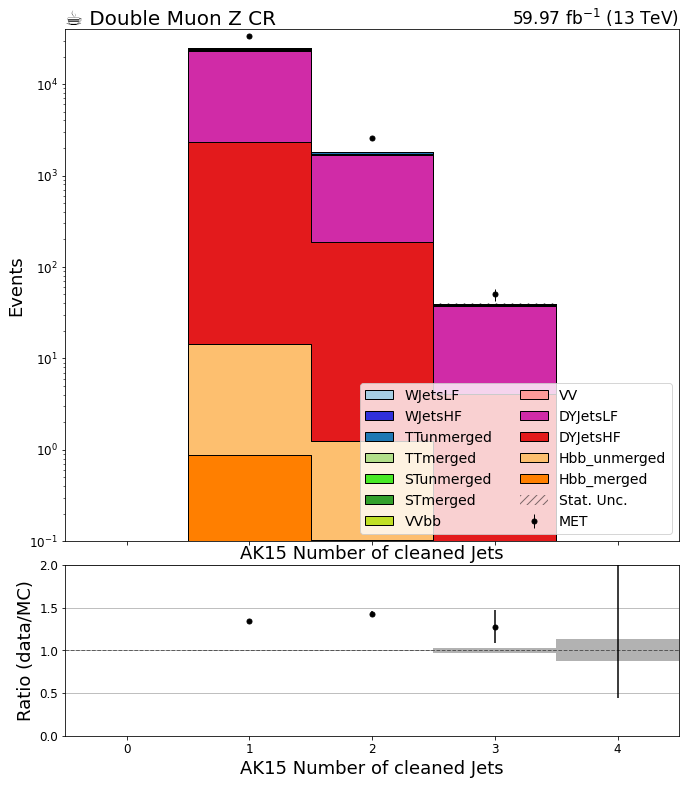

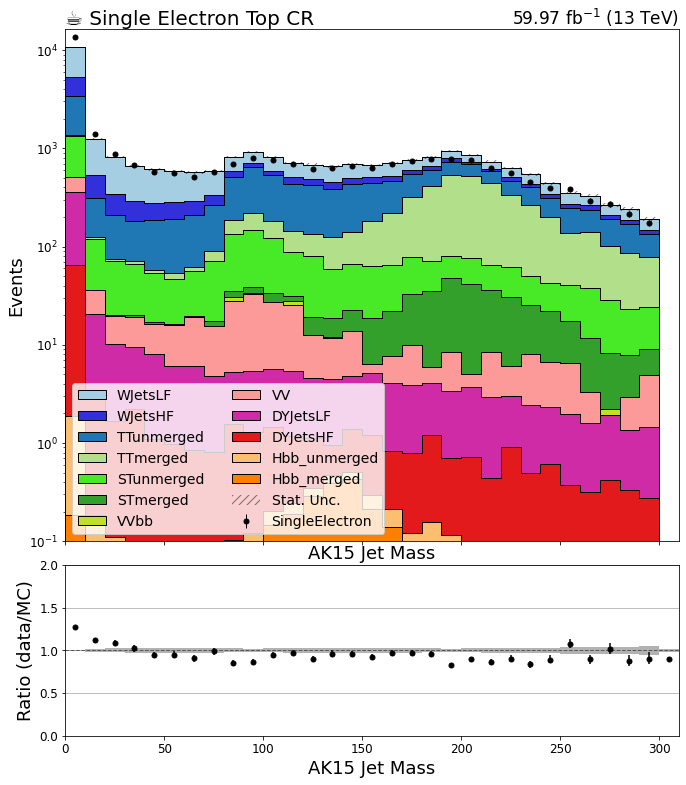

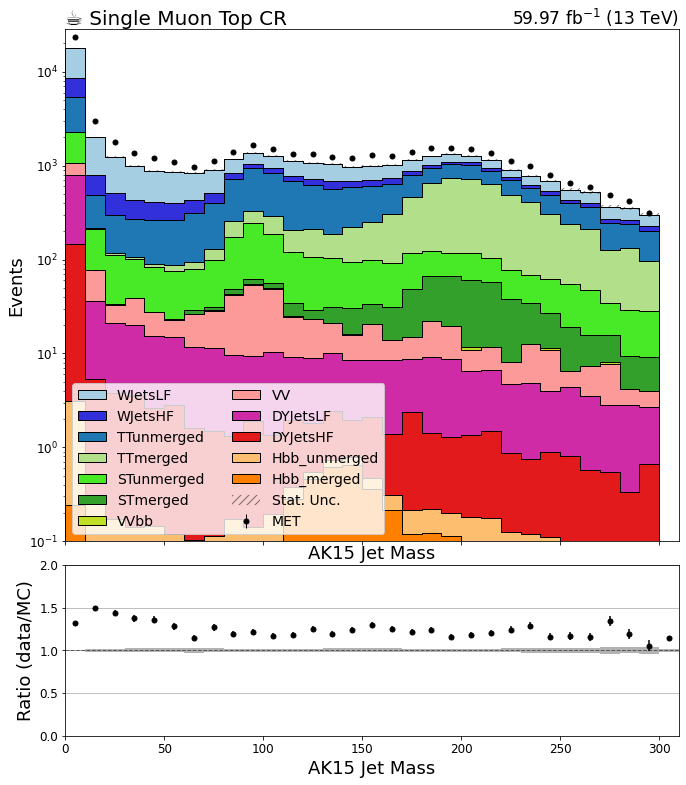

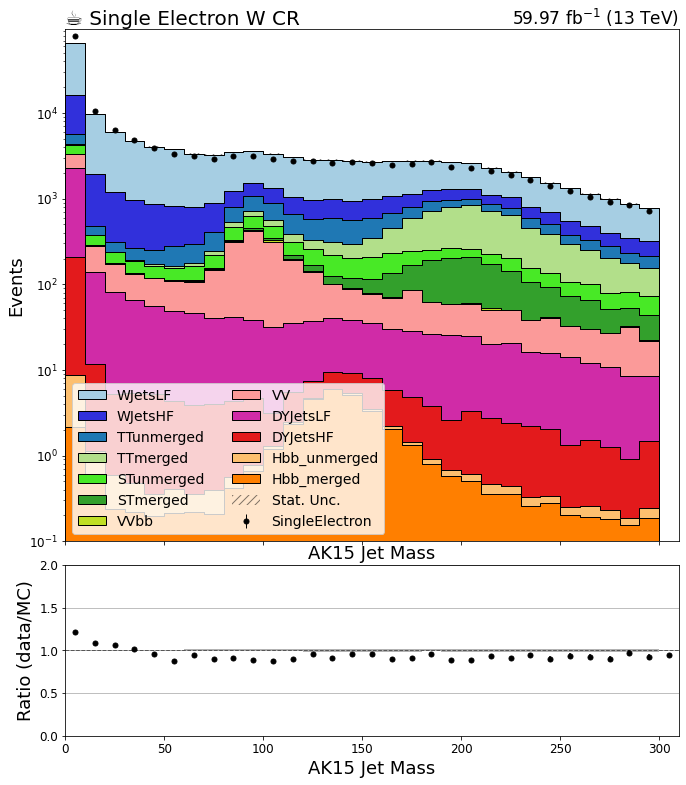

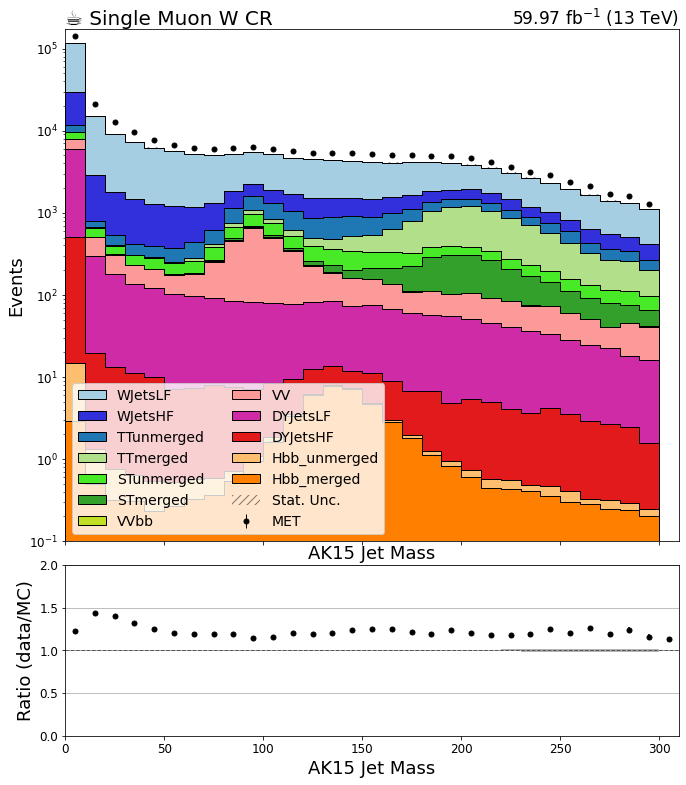

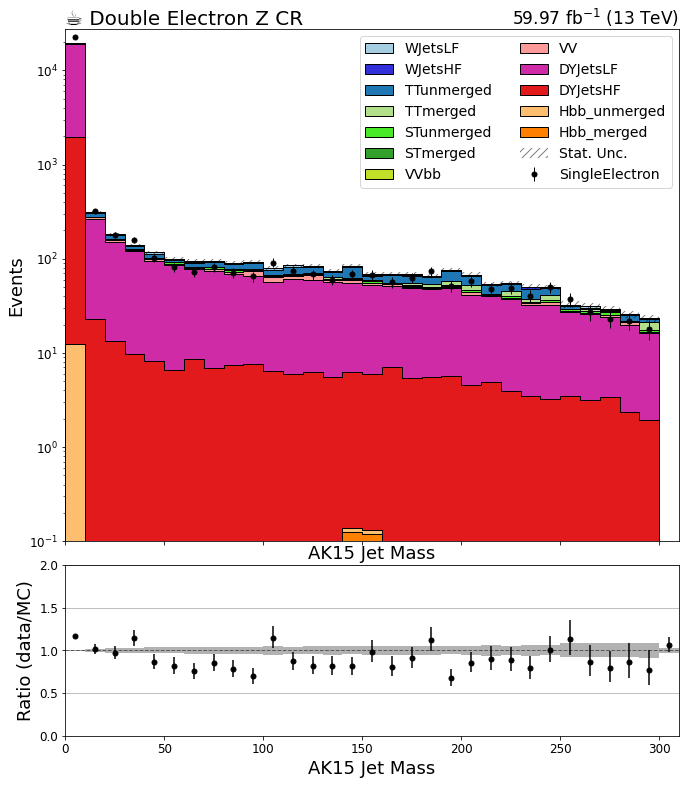

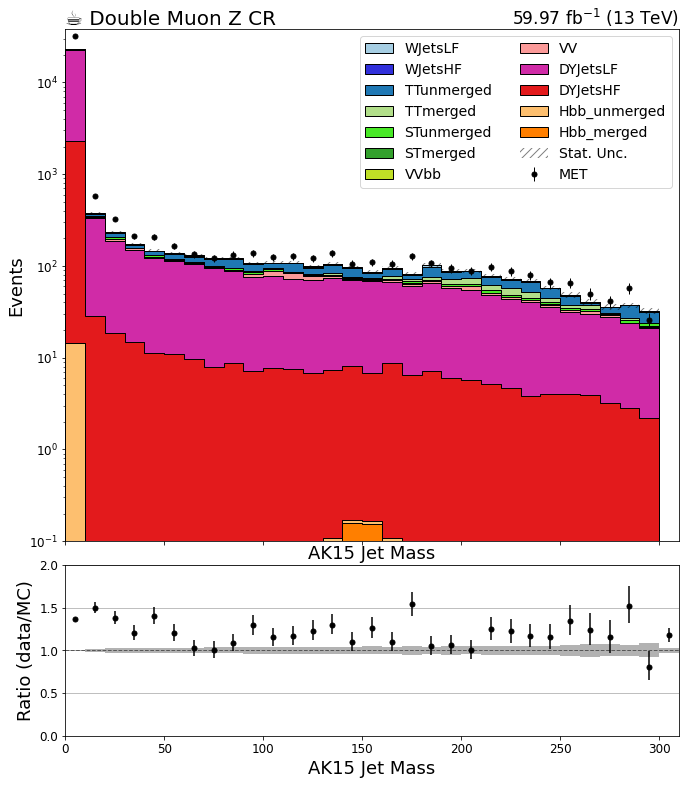

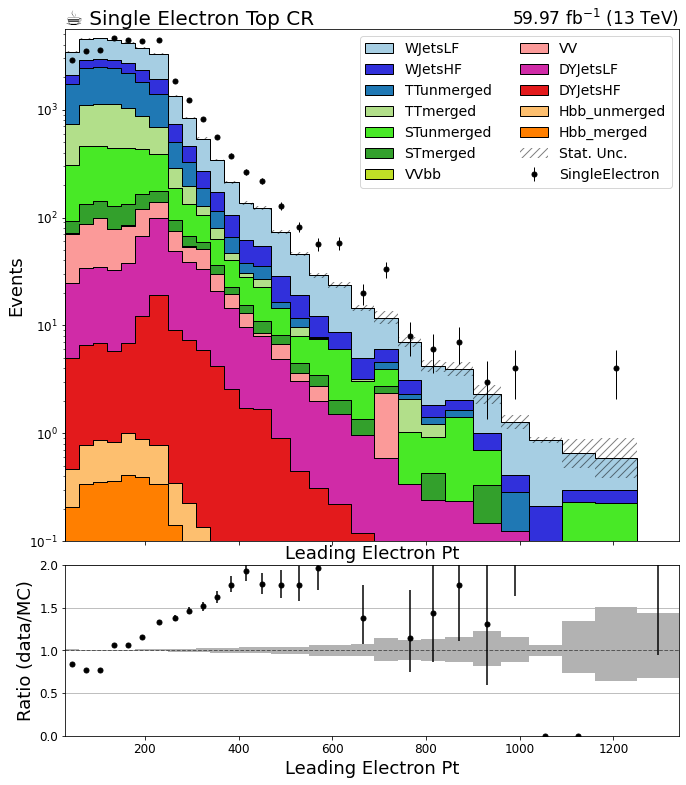

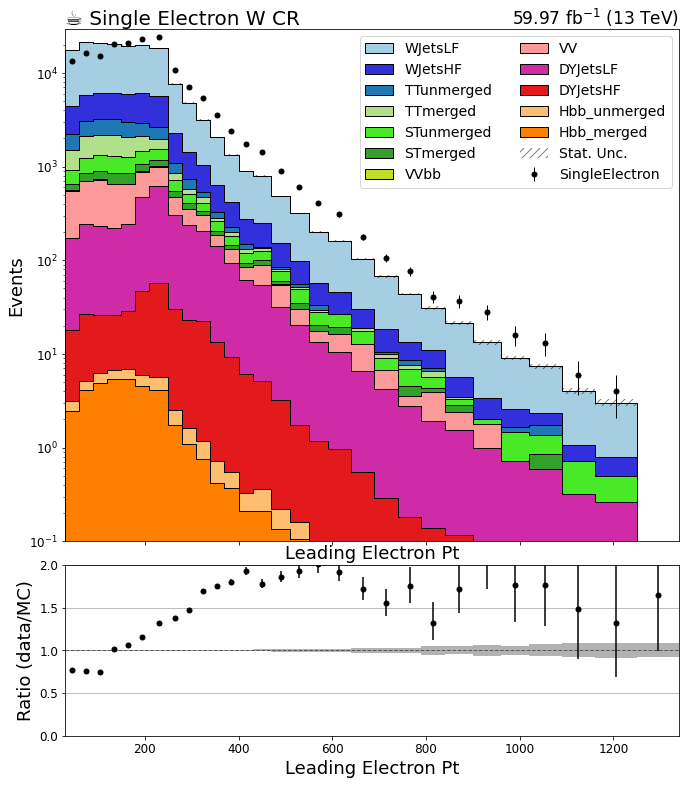

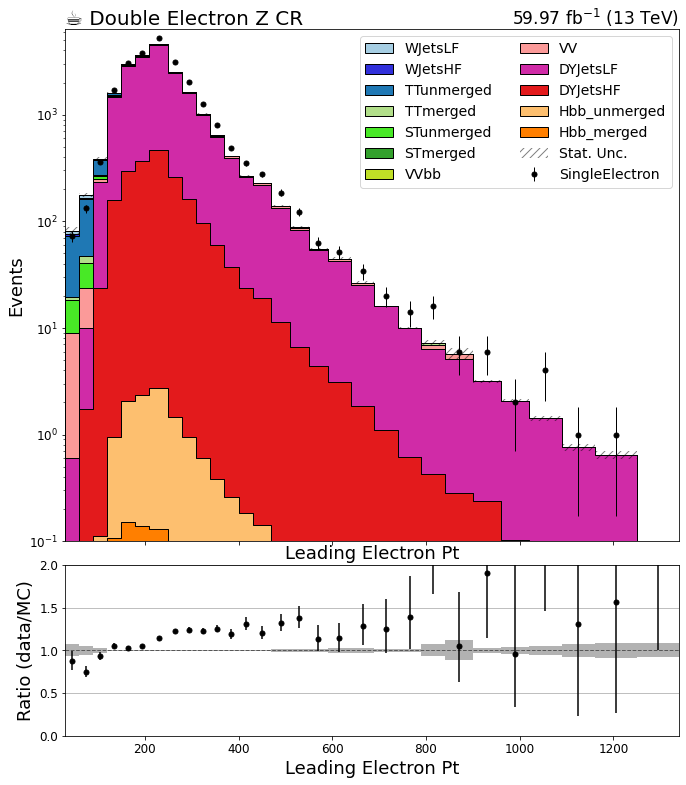

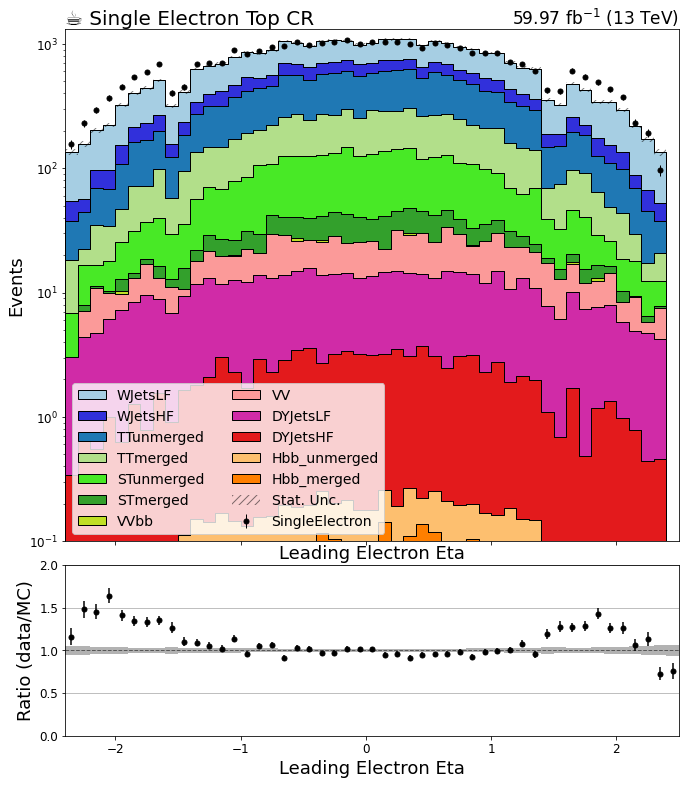

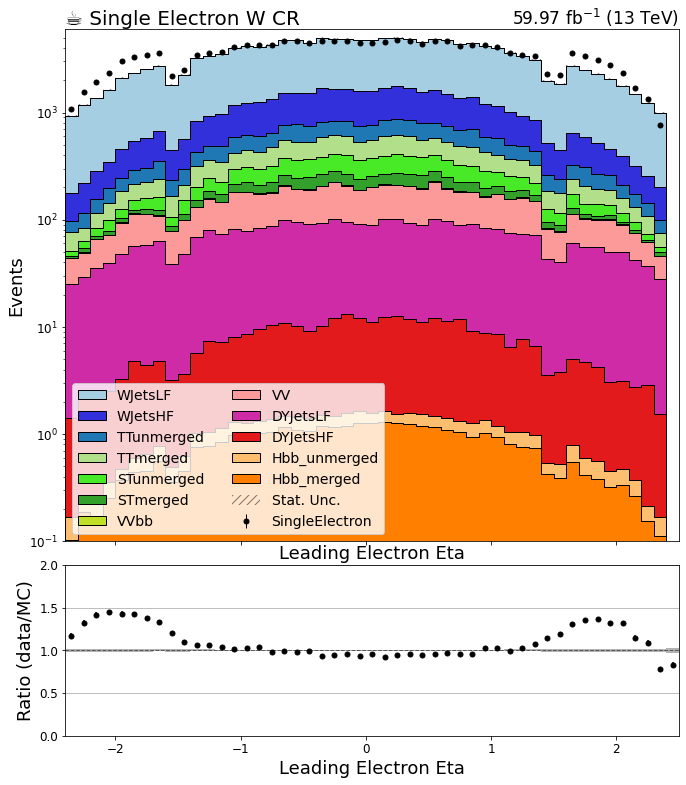

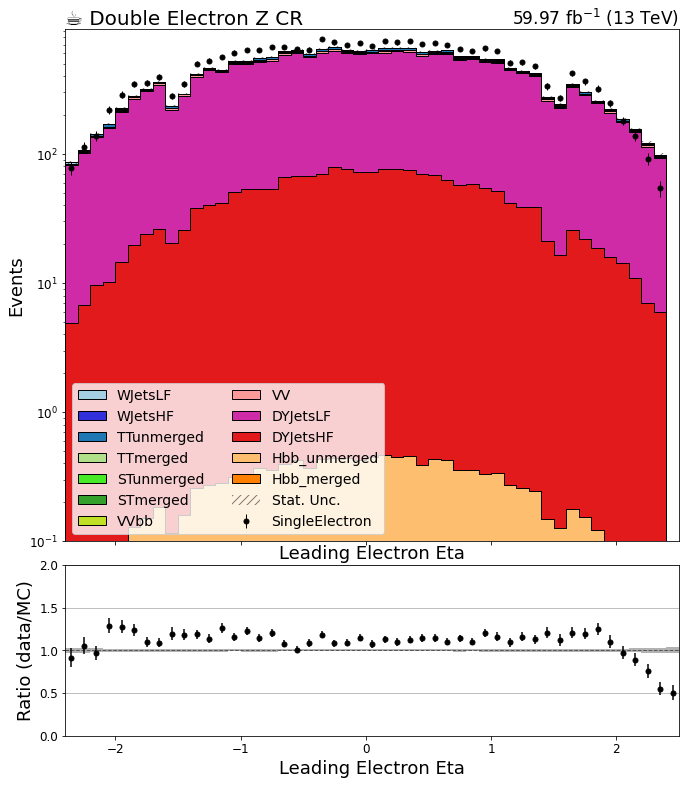

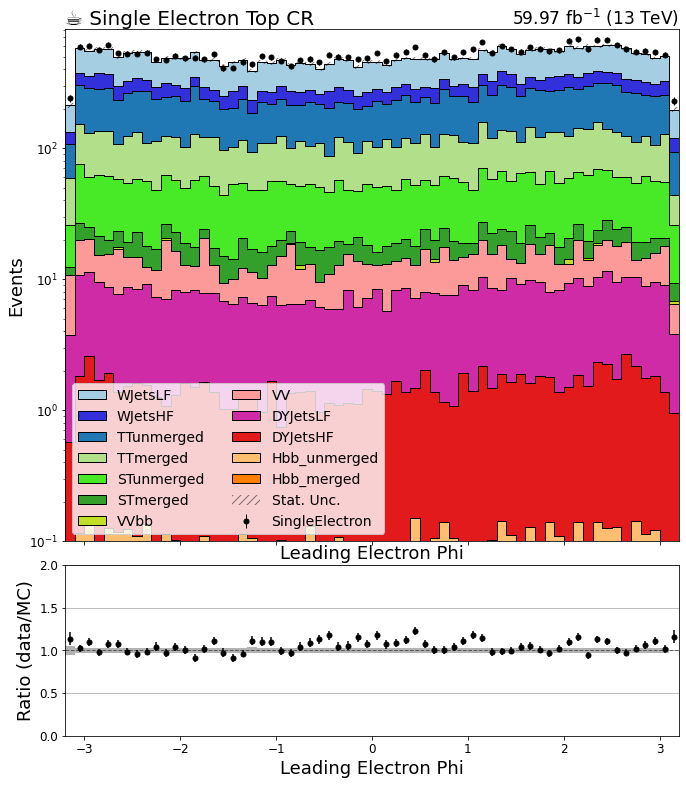

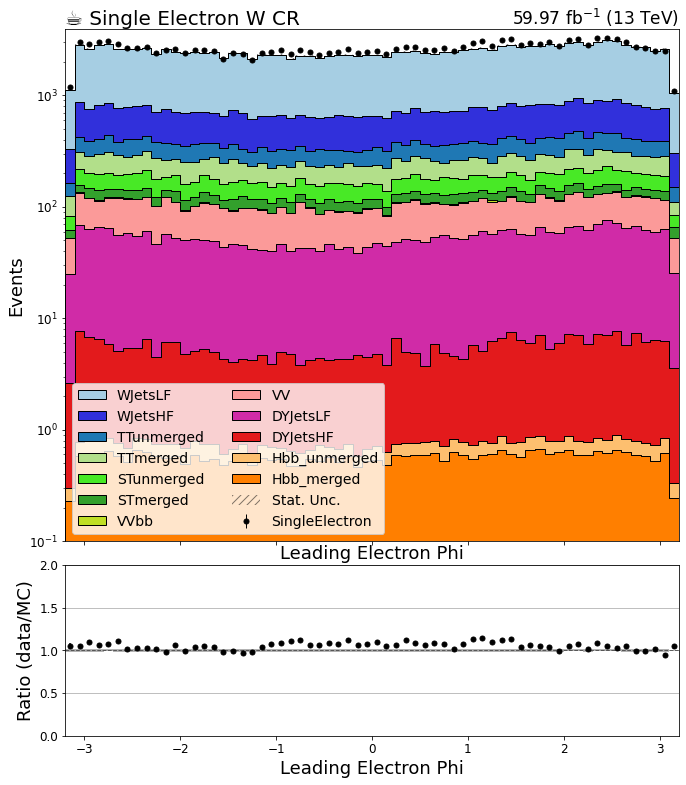

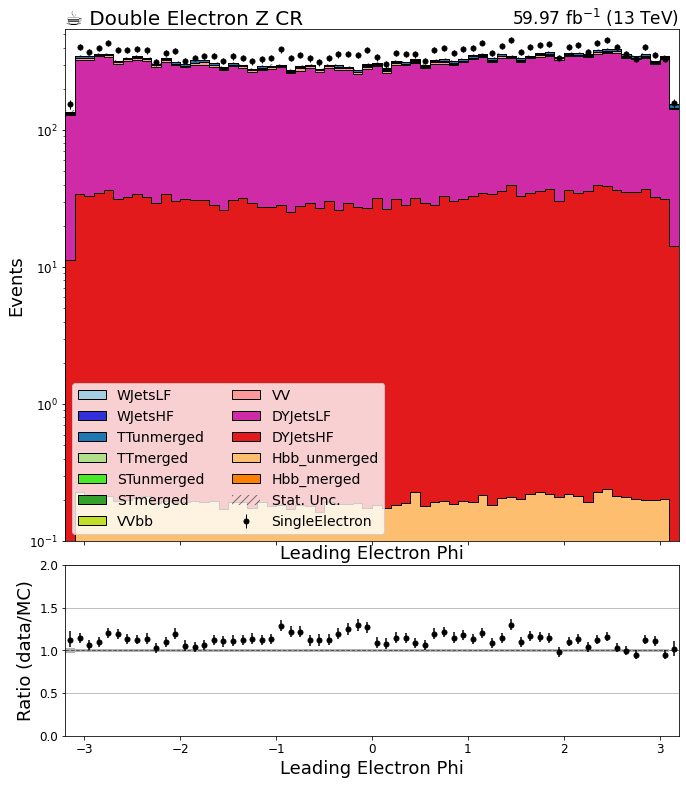

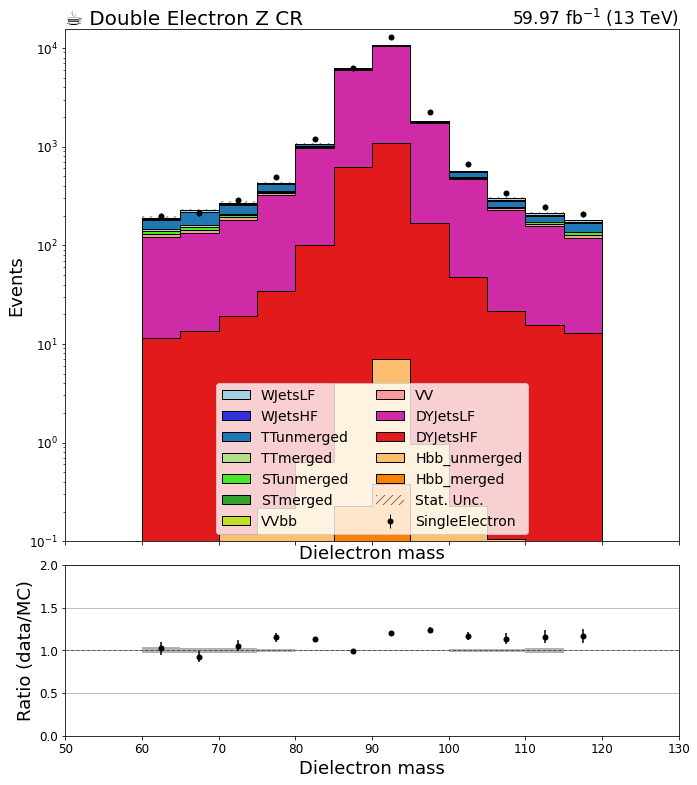

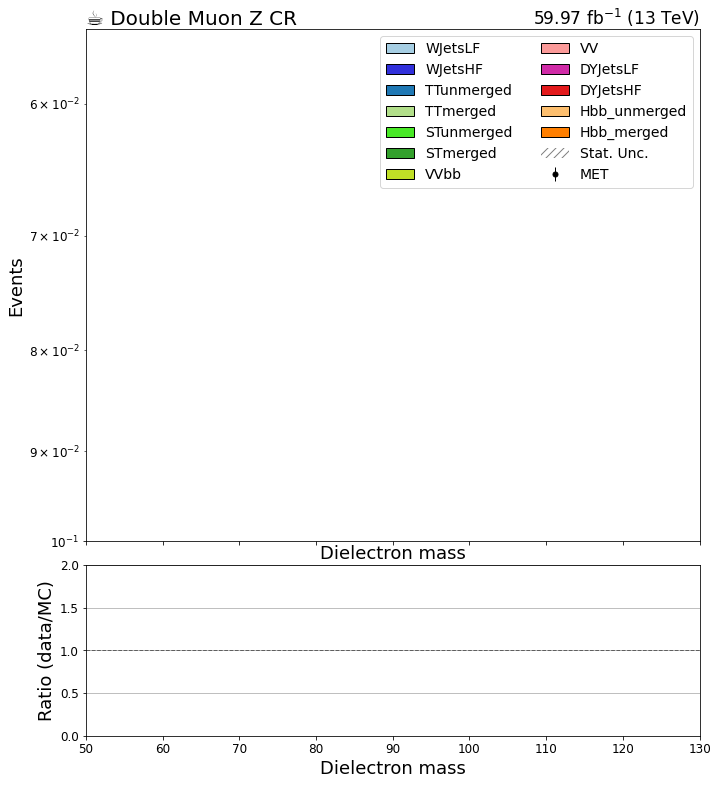

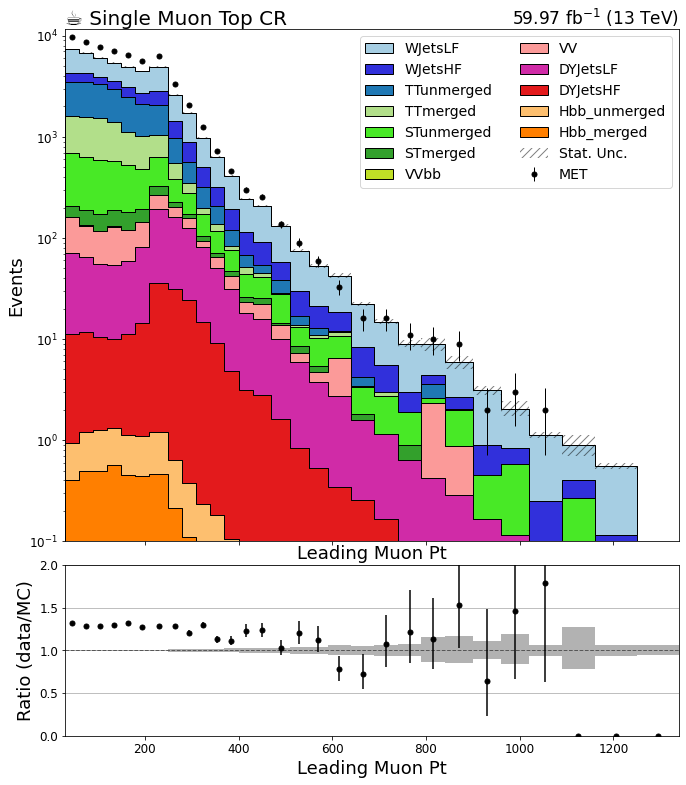

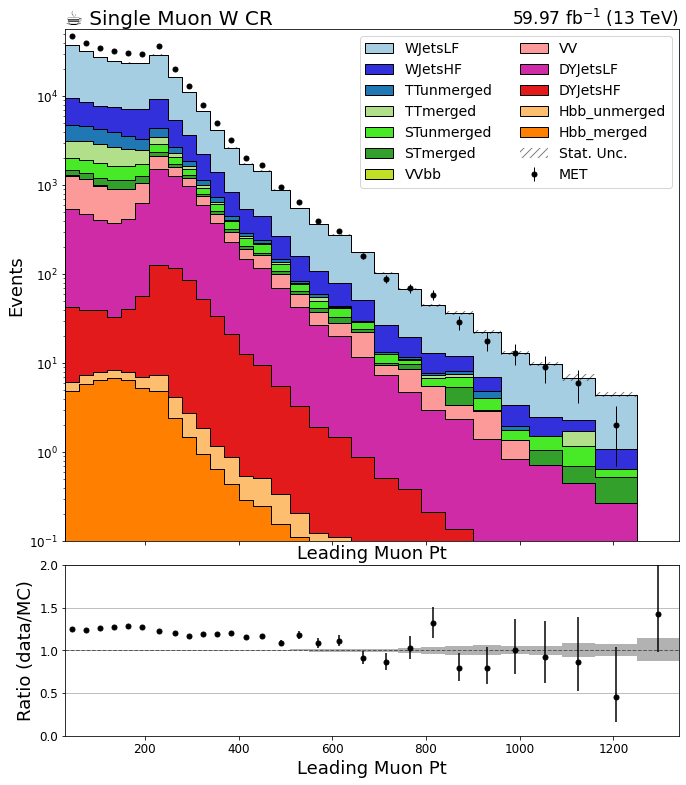

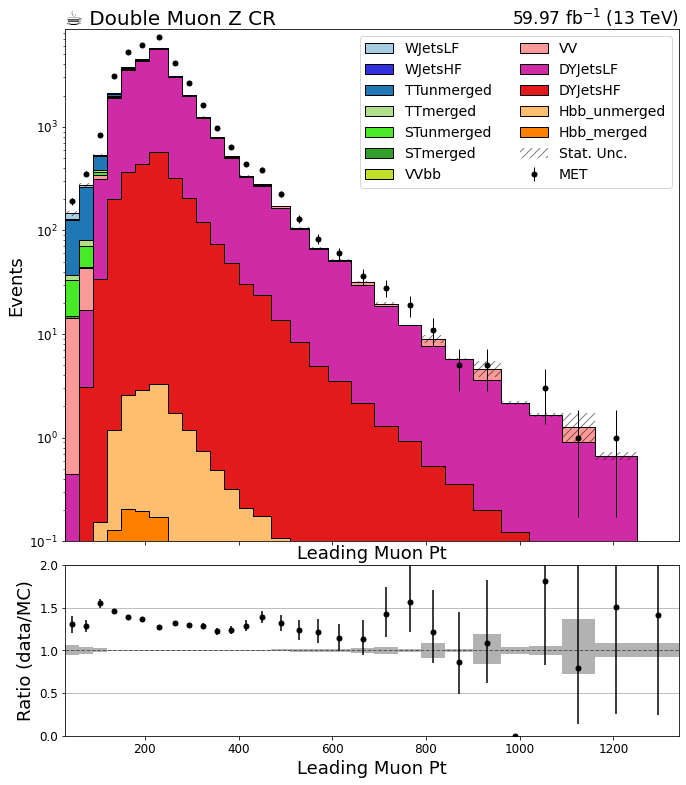

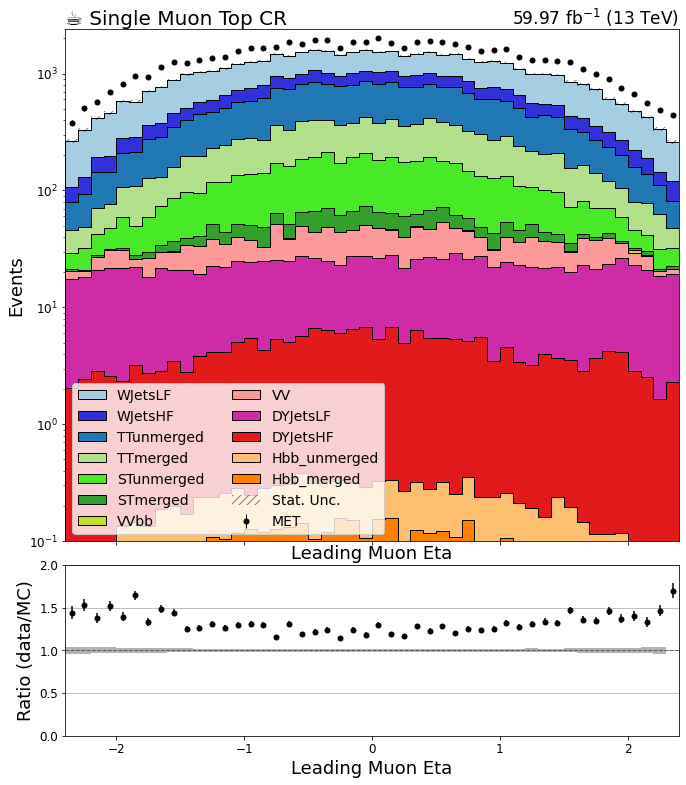

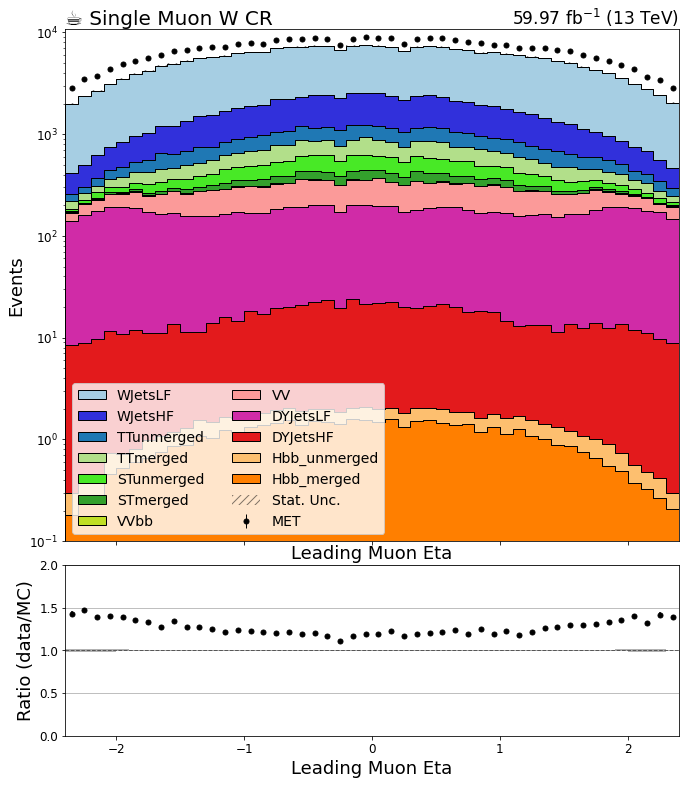

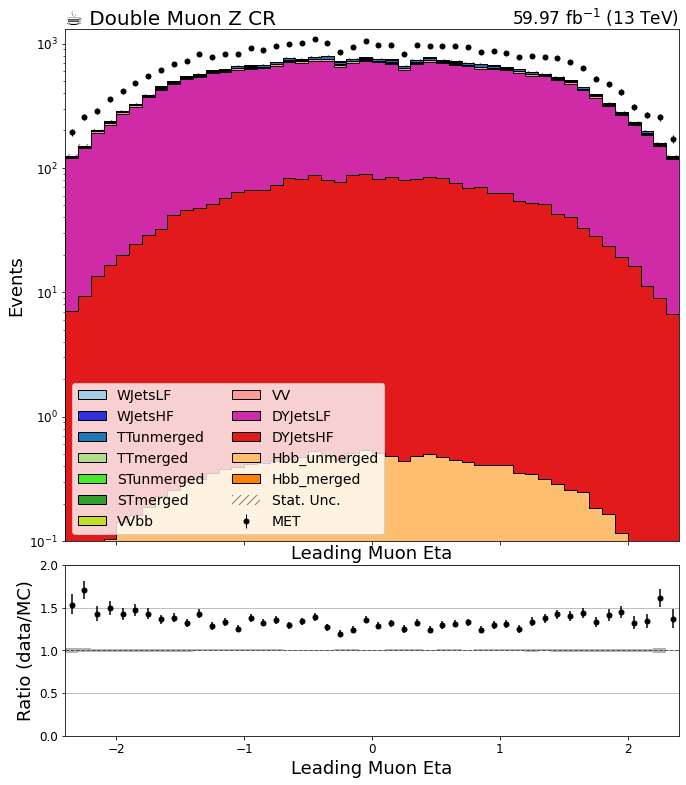

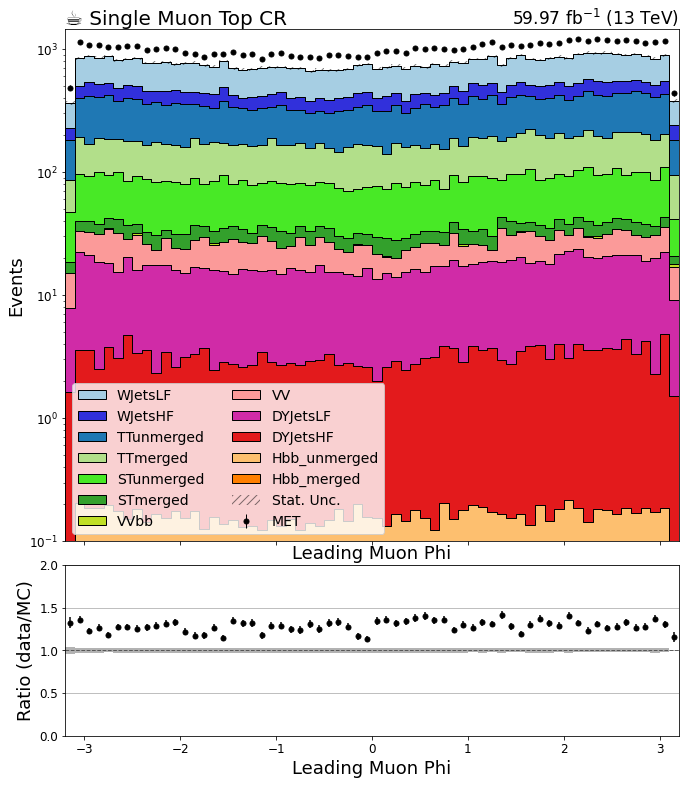

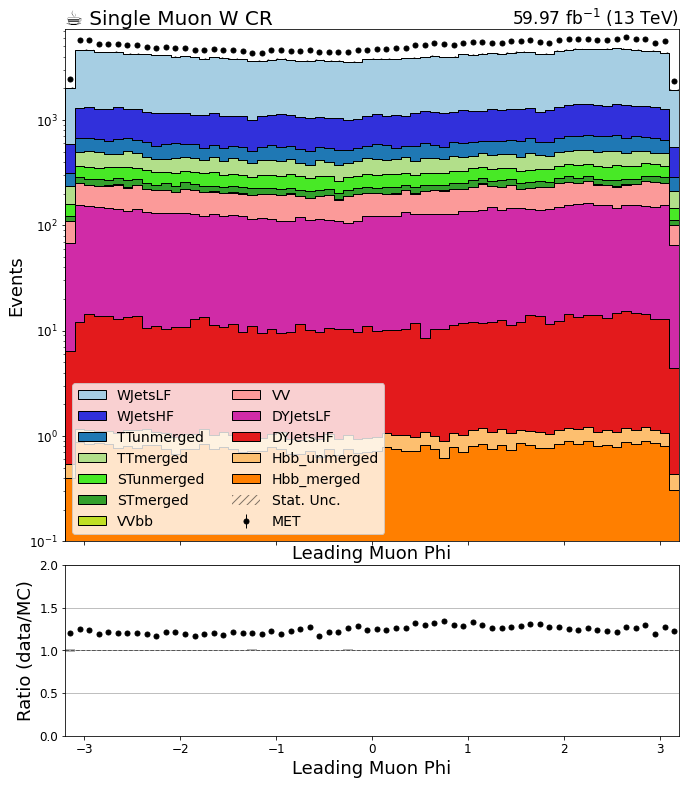

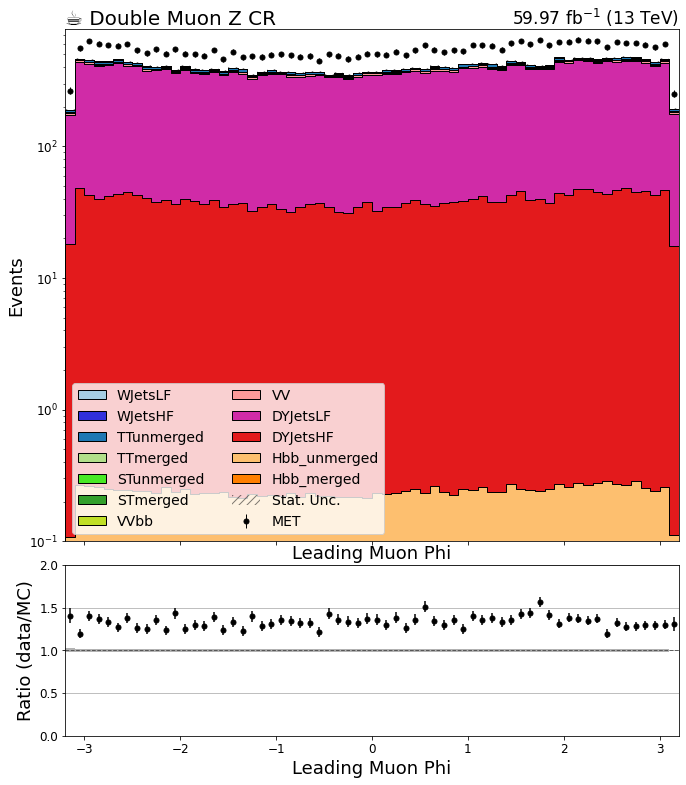

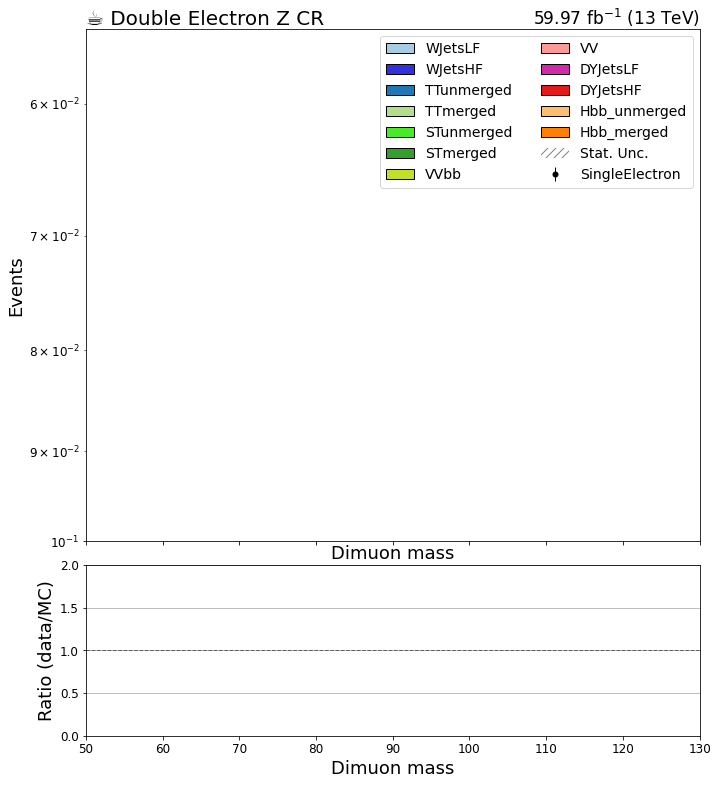

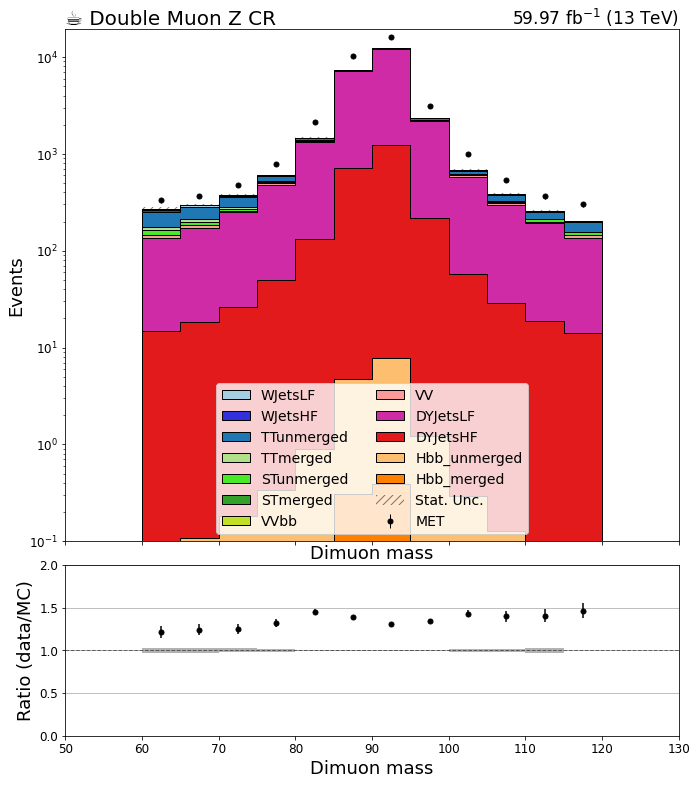

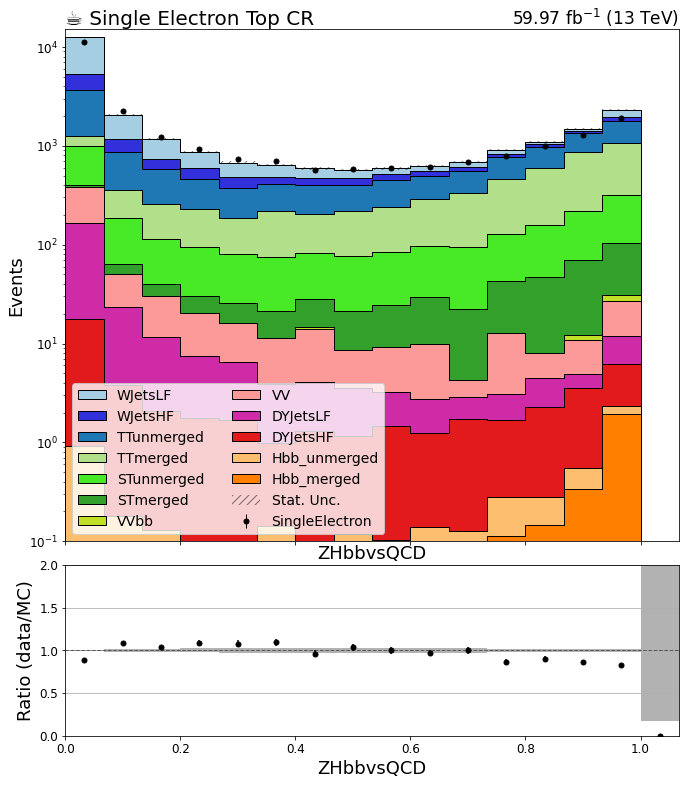

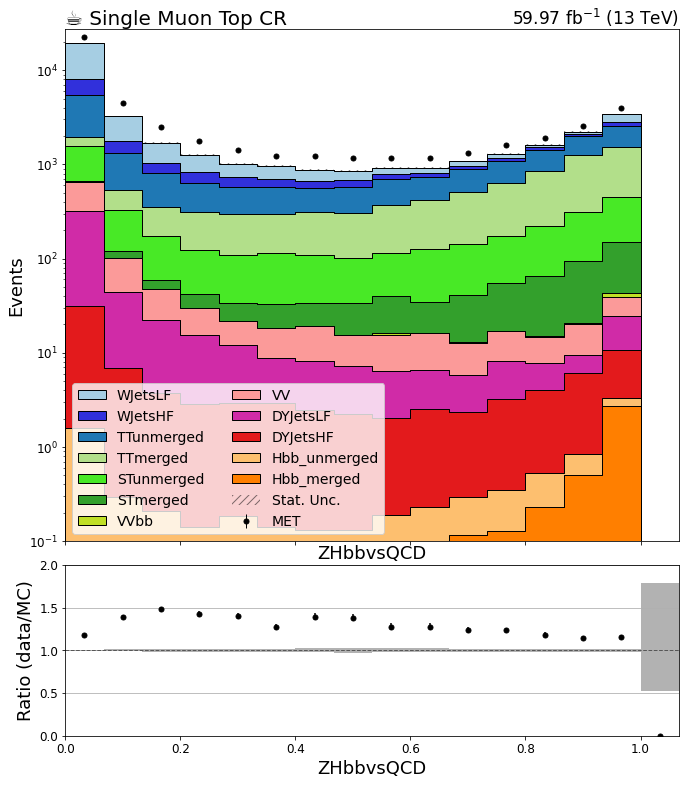

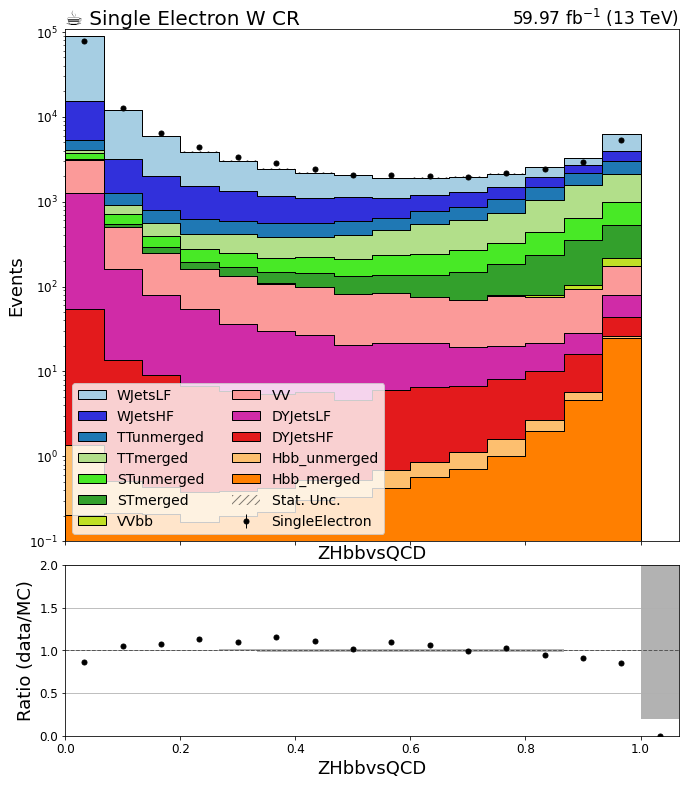

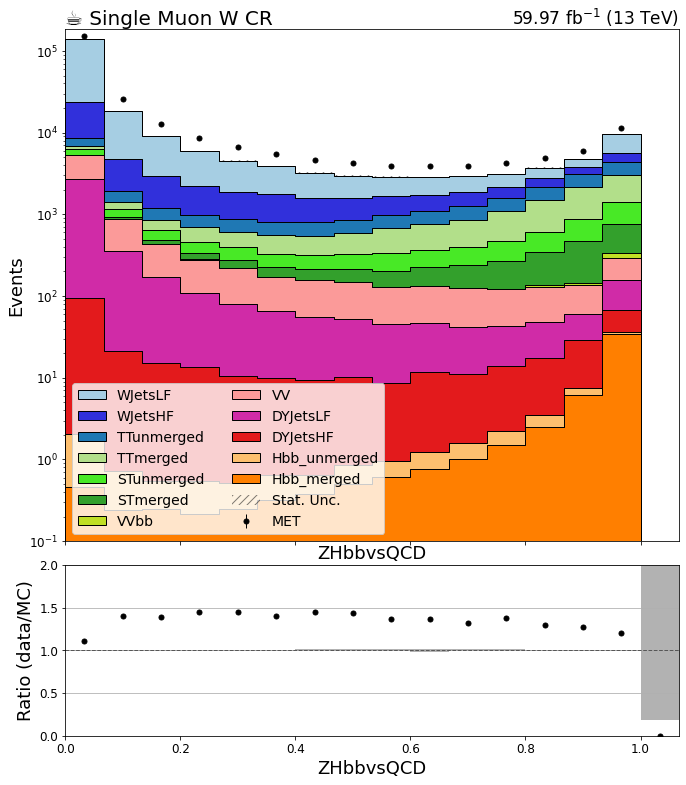

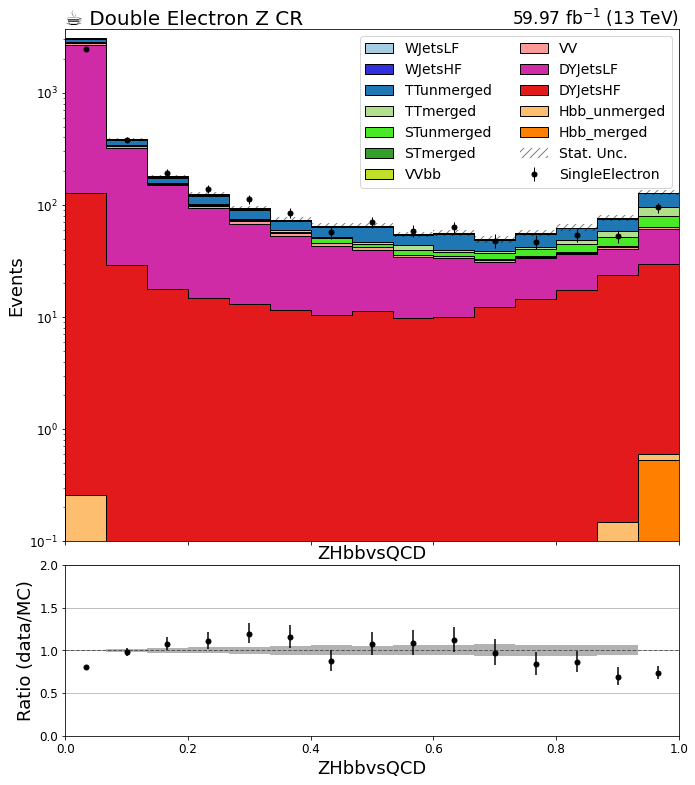

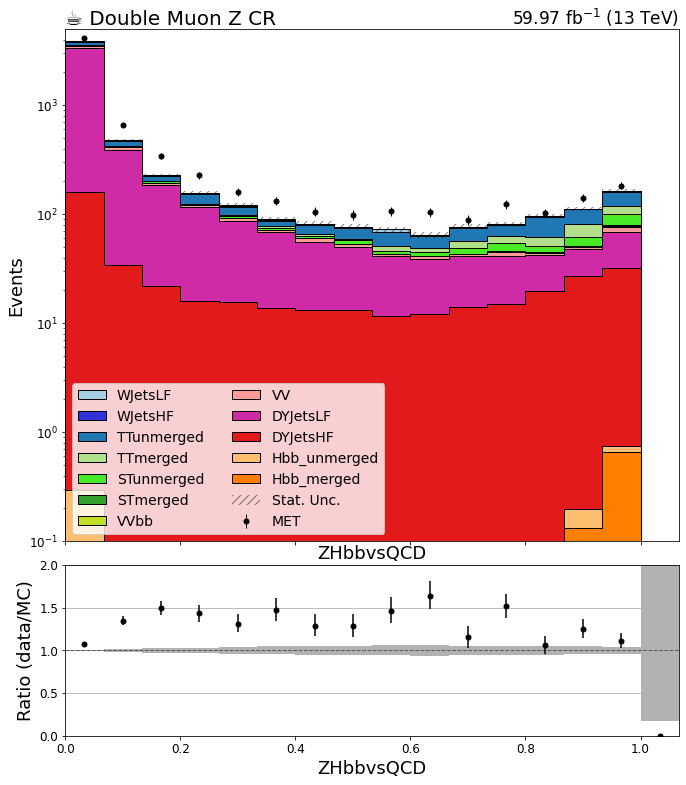

In [7]:
#http://colorbrewer2.org/#type=qualitative&scheme=Paired&n=6 : colors
from cycler import cycler


if not os.path.exists('stack'):
    os.makedirs('stack')
    
R = {}
R['sr'] = 'Signal Region'
R['wmcr'] = 'Single Muon W CR'
R['tmcr'] = 'Single Muon Top CR'
R['wecr'] = 'Single Electron W CR'
R['tecr'] = 'Single Electron Top CR'
R['zecr'] = 'Double Electron Z CR'
R['zmcr'] = 'Double Muon Z CR'
R['gcr'] = 'Single Photno CR'

sys = 'nominal'

for key in bkg_hists.keys():
    if key=='sumw': continue
    #if not (key == 'e1pt' or key == 'e1eta'): continue 
   
    for j in bkg_hists[key].identifiers('region'):
        
        #if not (str(j) == 'zmcr' or str(j) == 'zecr'): continue
        if 'mass' in str(j): continue
        if 'mono' in str(j): continue
        if str(j) == 'sr' or str(j) == 'gcr': continue
        #if 'ecr' in str(j): continue
        if str(j) == 'wmcr' or str(j) == 'tmcr' or str(j) == 'wecr' or str(j) == 'tecr':
            if key == 'dielemass' or key == 'dimumass': continue
        if str(j) == 'wmcr' or str(j) == 'tmcr' or str(j) == 'zmcr':
            if key == 'e1pt' or key == 'e1eta' or key == 'e1phi': continue
        if str(j) == 'wecr' or str(j) == 'tecr' or str(j) == 'zecr':
            if key == 'mu1pt' or key == 'mu1eta' or key == 'mu1phi': continue
            
        plt.rcParams.update({'figure.max_open_warning': 0,'font.size': 14, 'axes.titlesize': 18, 'axes.labelsize': 18, 'xtick.labelsize': 12, 'ytick.labelsize': 12})
        fill_opts = {'edgecolor': (0,0,0,0.3), 'alpha': 1}
        error_opts = {'label':'Stat. Unc.', 'hatch':'///', 'facecolor':'none', 'edgecolor':(0,0,0,.5), 'linewidth': 0}
        nostack_fill_opts = {'alpha': 0.2, 'label': '_nolabel_'}
        data_err_opts = {'linestyle':'None', 'marker': '.', 'markersize': 10., 'color':'k'}#, 'elinewidth': 1, 'emarker': '_'}
        #colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c']
        colors = ['#a6cee3', '#3130db', '#1f78b4', '#b2df8a', '#48e926', '#33a02c', '#c0df26',
                  '#fb9a99', '#d02ba7', '#e31a1c', '#fdbf6f', '#ff7f00', '#cab2d6', '#c64bc4',
                  '#6a3d9a', '#a9ce26', '#ffff99', '#b15928', '#edcc43']


        fig, (ax, rax) = plt.subplots(2, 1, figsize=(11,13), gridspec_kw={"height_ratios": (3, 1)}, sharex=True)
        fig.subplots_adjust(hspace=.07)
        ax.set_prop_cycle(cycler(color=colors))
        

        plot.plot1d(data_hists[key].integrate('systematic',sys).integrate('region',j)[data[str(j).split('_')[0]]],            
                overlay="process",
                ax=ax,
                clear=False,
                error_opts=data_err_opts
                   )

        plot.plot1d(bkg_hists[key].integrate('systematic',sys).integrate('region',j),
                overlay="process",
                ax=ax,
                clear=False,
                stack=True,
                fill_opts=fill_opts,
                error_opts=error_opts
                   )
        
        plot.plotratio(data_hists[key].integrate('systematic',sys).integrate('region',j).integrate('process',data[str(j).split('_')[0]]), 
                   bkg_hists[key].integrate('systematic',sys).integrate('region',j).sum('process'),
                   ax=rax,
                   overflow='over',
                   error_opts=data_err_opts,
                   denom_fill_opts={},
                   guide_opts={},
                   unc='num'
                   )
        
        rax.set_ylabel('Ratio (data/MC)')
        rax.set_ylim(0.0,2.0)
        rax.grid(axis='y')
        
        ax._get_lines.prop_cycler = ax._get_patches_for_fill.prop_cycler
        args = {'linestyle':'--', 'linewidth': 5}
        ax.autoscale(axis='x', tight=True)
        ax.set_yscale('log')
        if(key=='dielemass' or key=='dimumass'): ax.set_xlim(50, 130)
        ax.set_ylim(.1, None)
        leg = ax.legend(ncol=2, loc='best')
        
        coffee = plt.text(0., 1., u"☕ "+R[str(j).split('_')[0]], fontsize=20, horizontalalignment='left', verticalalignment='bottom', transform=ax.transAxes)
        lumi = plt.text(1., 1., r"59.97 fb$^{-1}$ (13 TeV)", fontsize=17, horizontalalignment='right', verticalalignment='bottom', transform=ax.transAxes)
        plot_path = os.path.abspath('stack') 
        plot_name = 'stack_'+key+'_'+R[str(j).split('_')[0]]+'.png'
        #fig.savefig(os.path.join(plot_path, plot_name))

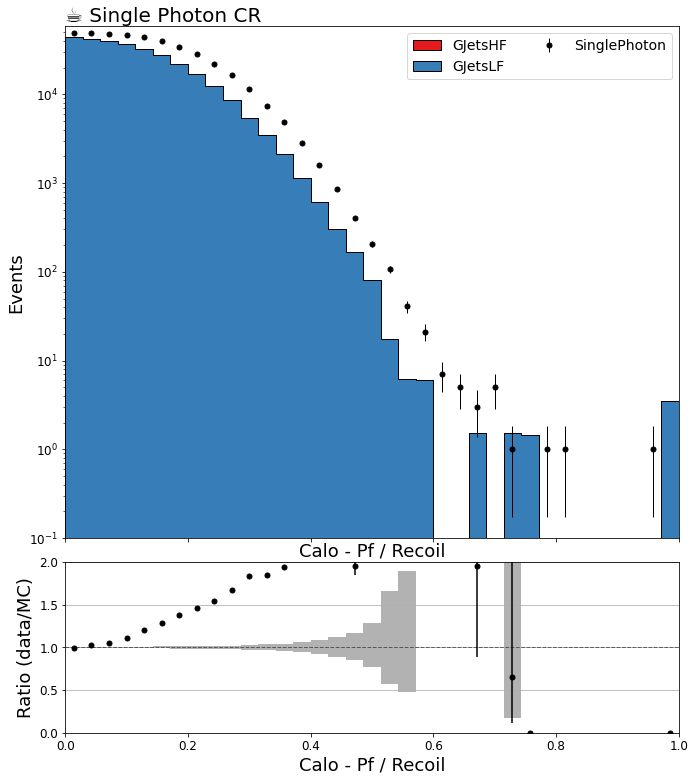

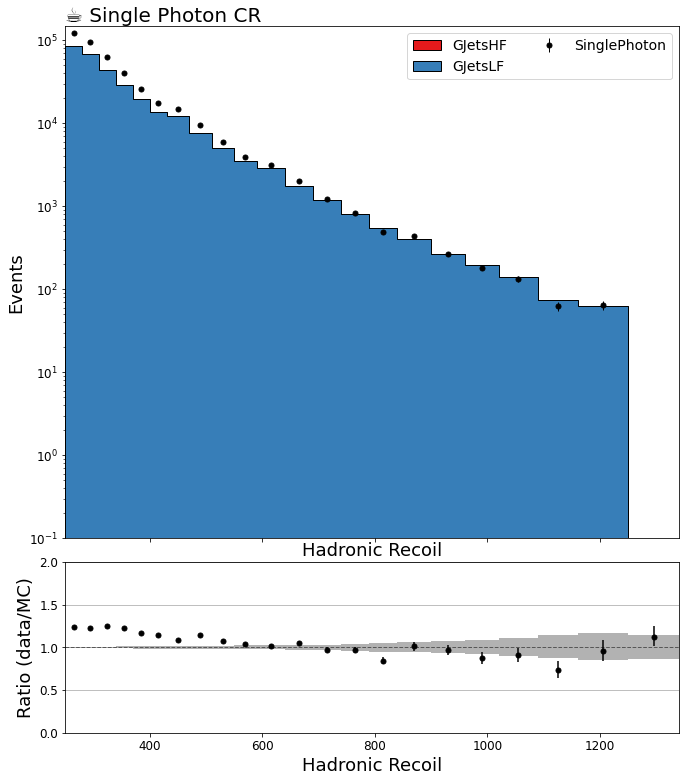

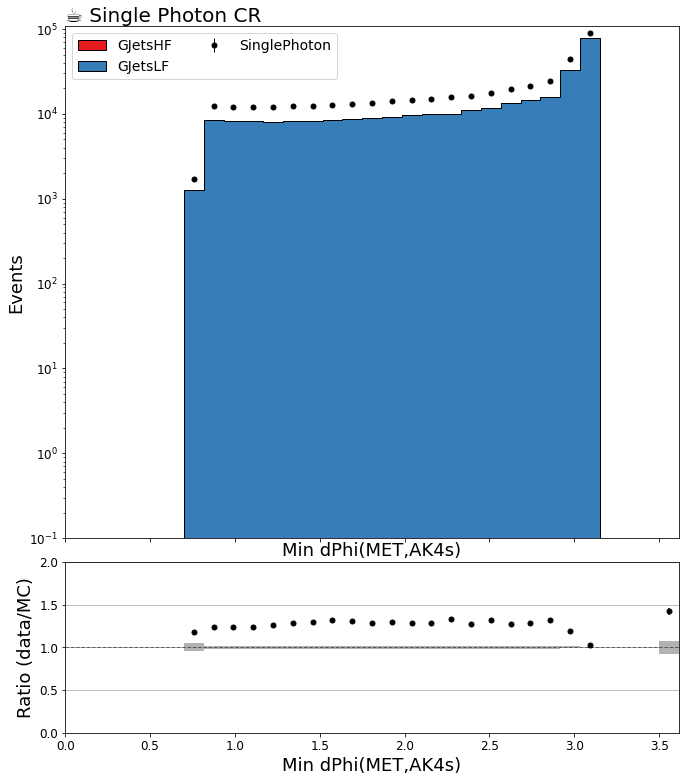

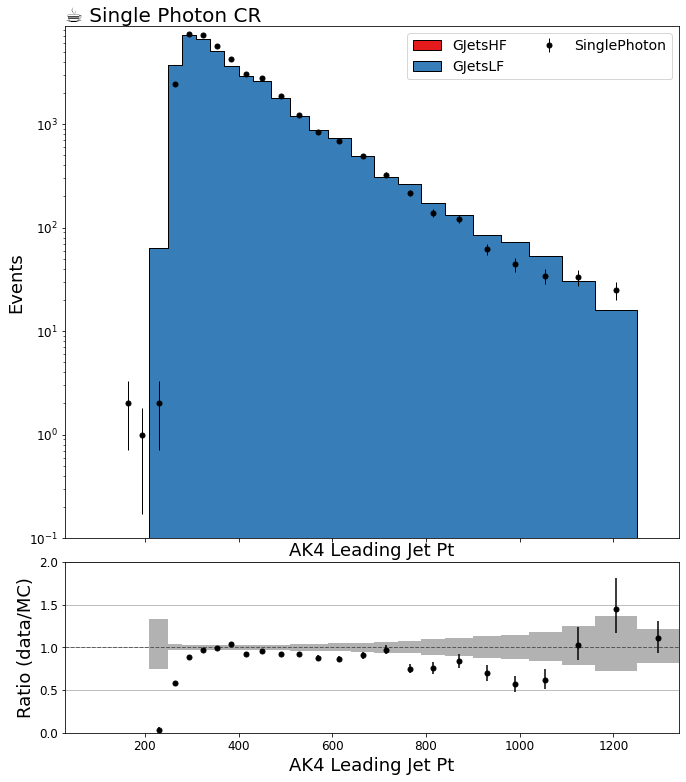

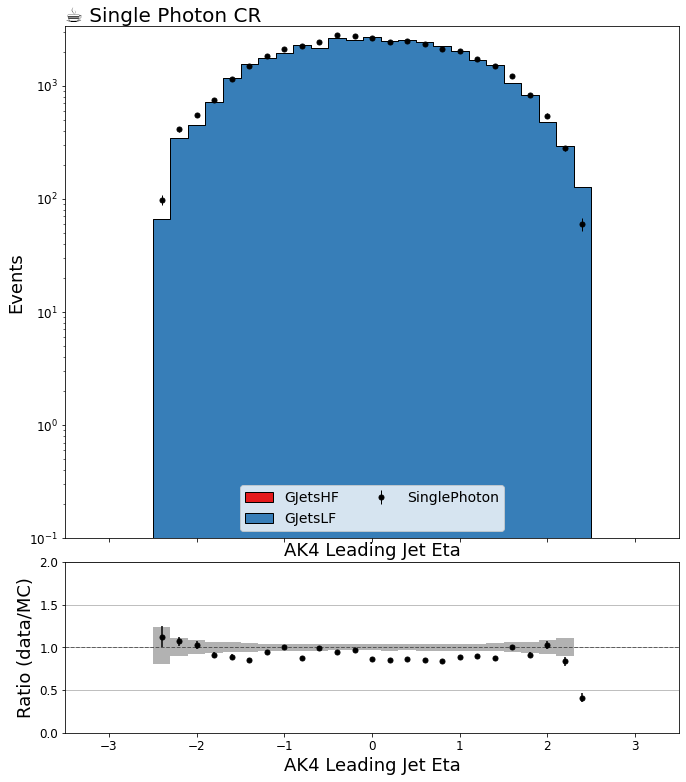

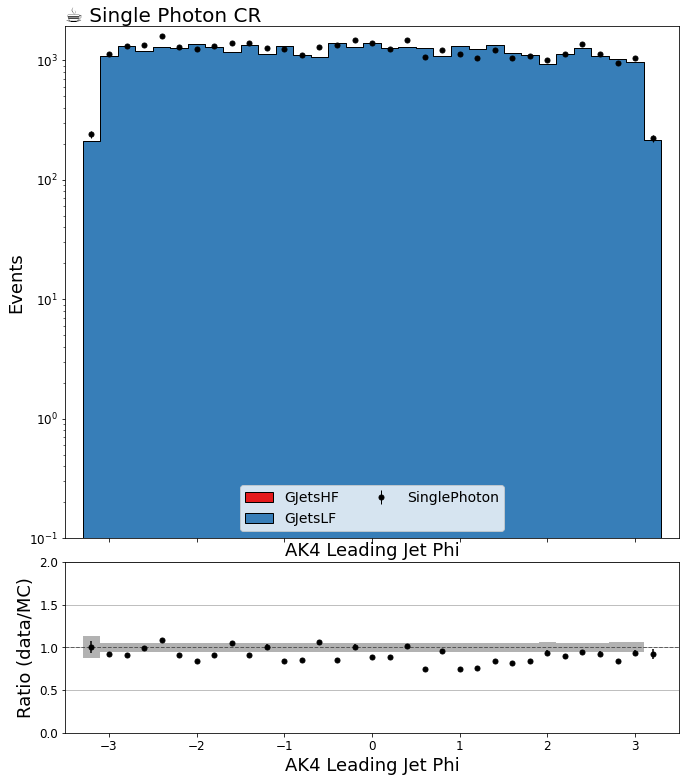

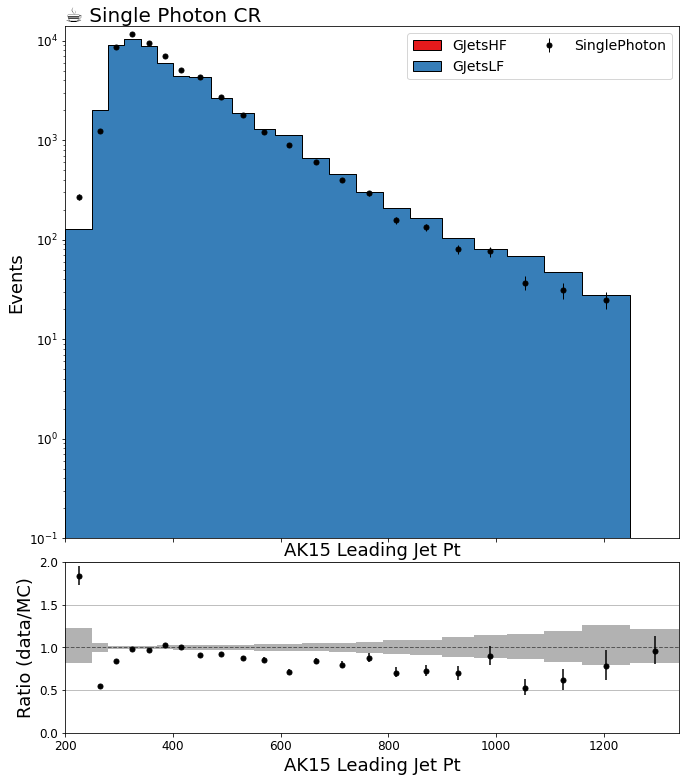

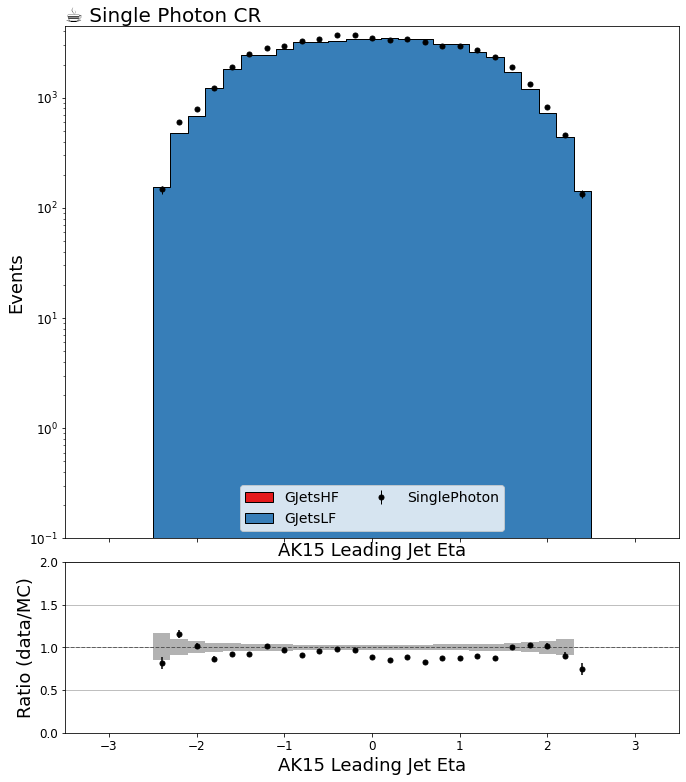

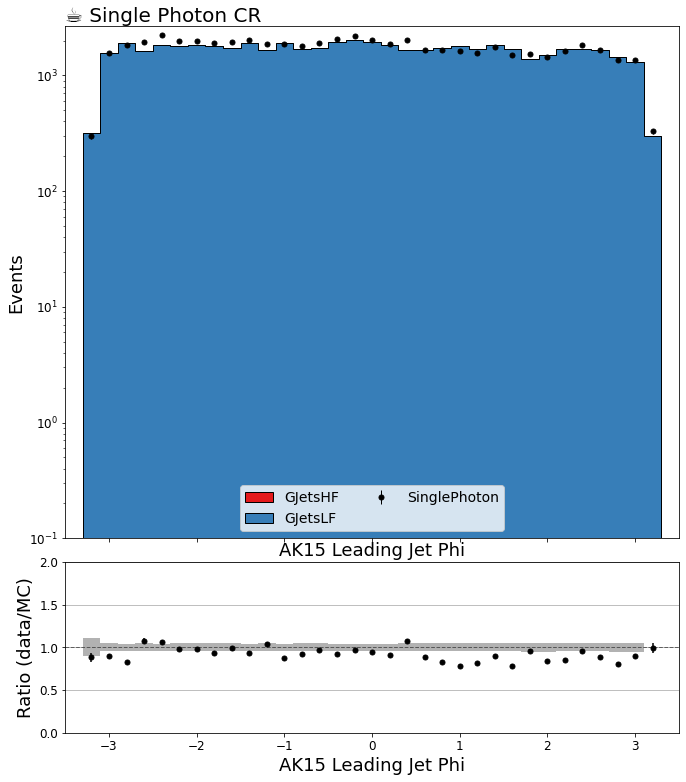

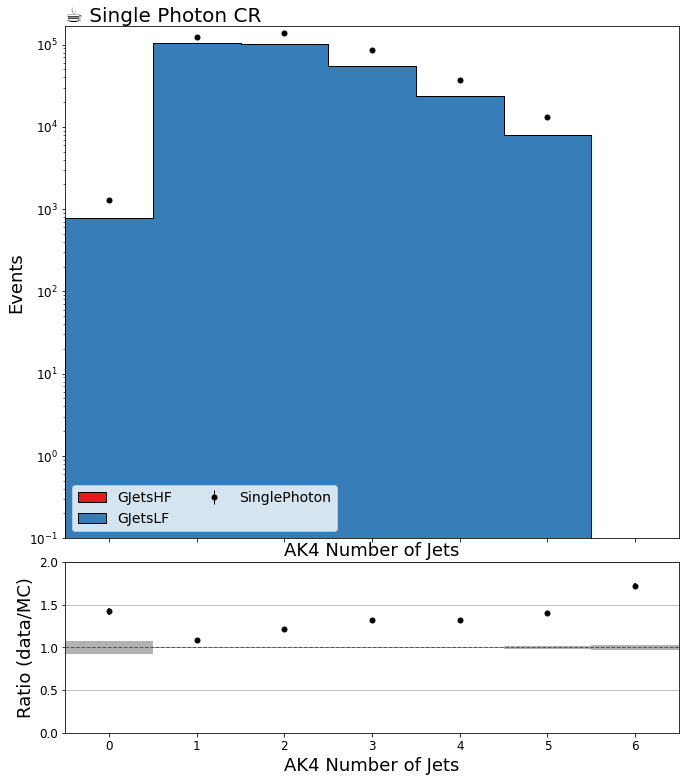

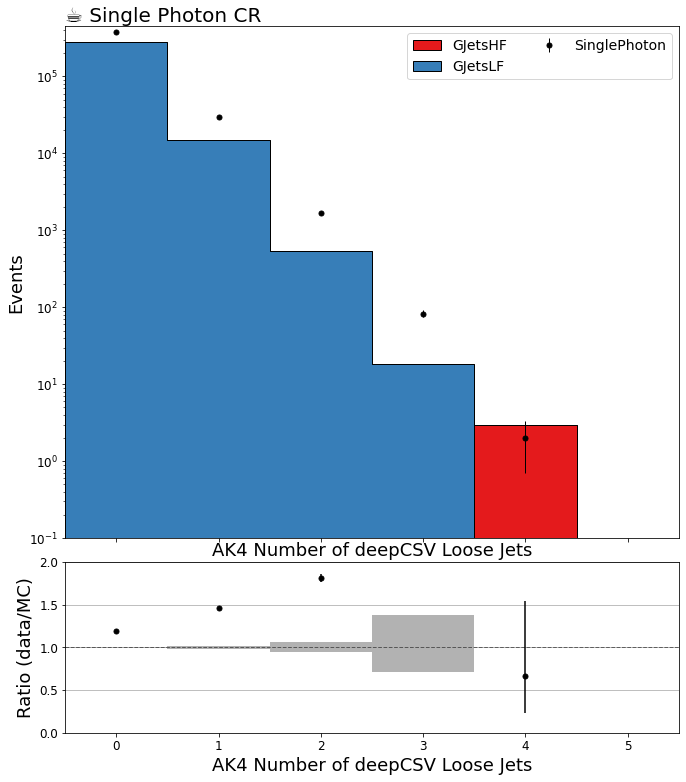

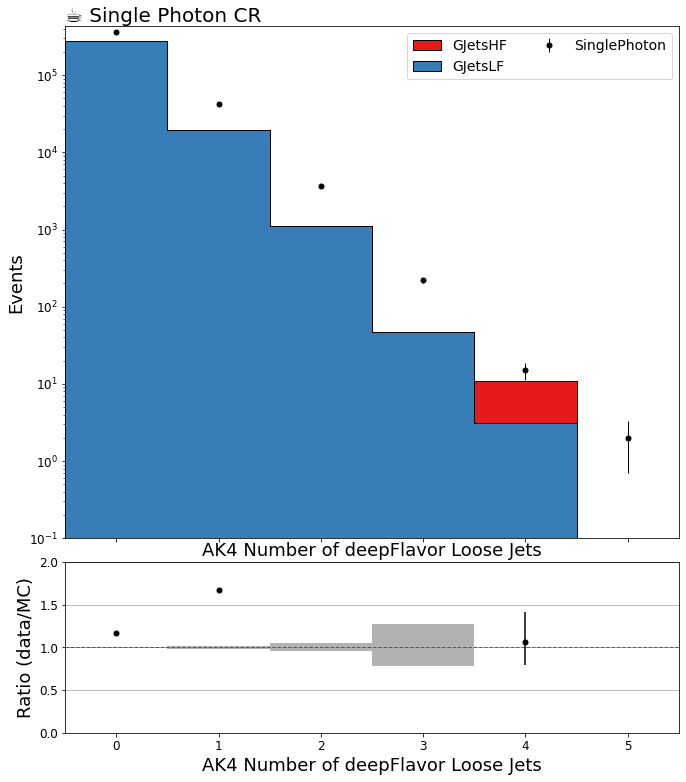

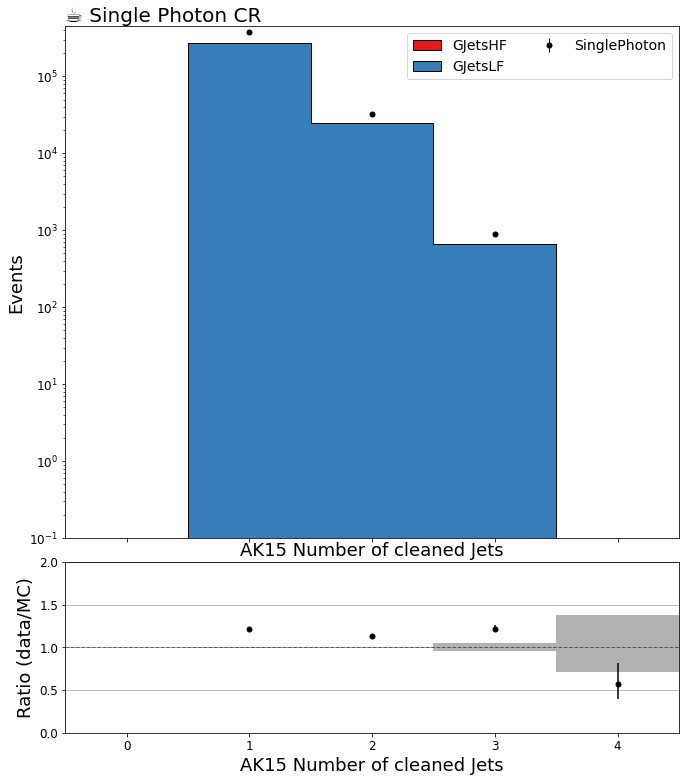

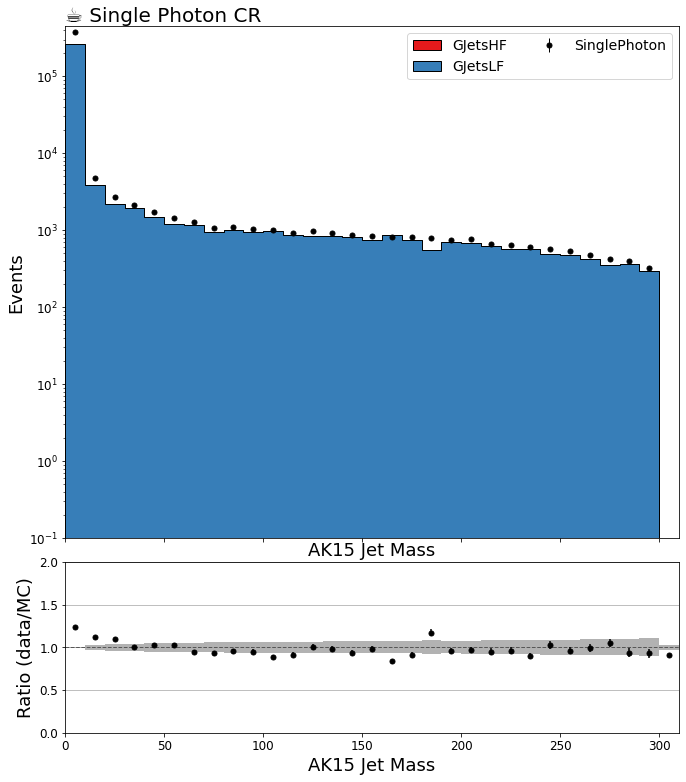

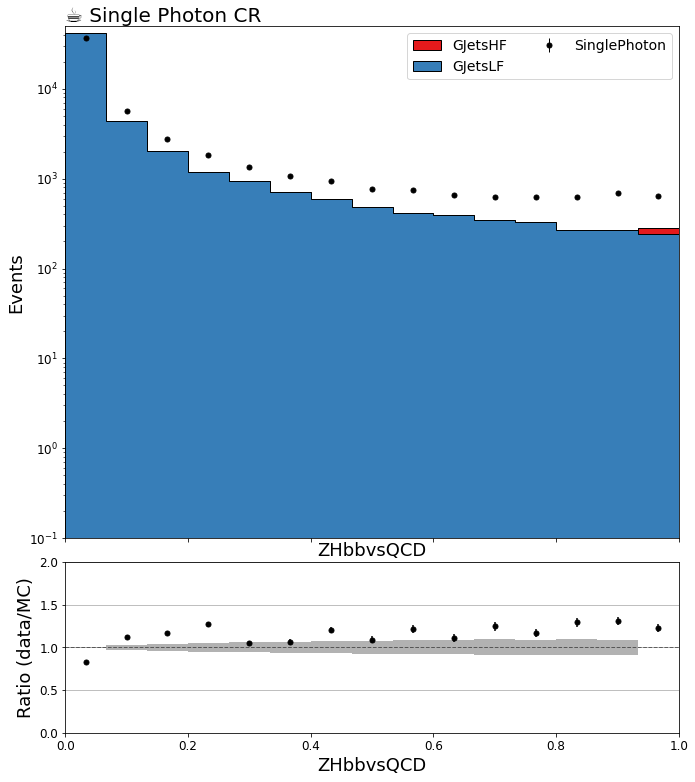

In [9]:
#### Gamma CR ####

#http://colorbrewer2.org/#type=qualitative&scheme=Paired&n=6 : colors
from cycler import cycler


if not os.path.exists('unstack'):
    os.makedirs('unstack')
    
R = {}
R['sr'] = 'Signal Region'
R['wmcr'] = 'Single Muon W CR'
R['tmcr'] = 'Single Muon Top CR'
R['wecr'] = 'Single Electron W CR'
R['tecr'] = 'Single Electron Top CR'
R['zecr'] = 'Double Electron Z CR'
R['zmcr'] = 'Double Muon Z CR'
R['gcr'] = 'Single Photon CR'

sys = 'nominal'

for key in bkg_hists.keys():
    if key=='sumw': continue
    if key == 'e1pt' or key == 'e1eta' or key == 'mu1pt' or key == 'mu1eta': continue
    if key == 'e1phi' or key == 'mu1phi' or key == 'dielemass' or key == 'dimumass': continue

    
    for j in bkg_hists[key].identifiers('region'):
        
        if not str(j) == 'gcr': continue
        #if 'mass' in str(j): continue
        #if 'mono' in str(j): continue
        #if not str(j) == 'gcr': continue
        #if str(j) == 'sr' or str(j) == 'gcr': continue
        #if str(j) == 'wmcr' or str(j) == 'tmcr' or str(j) == 'wecr' or str(j) == 'tecr':
        #    if key == 'dielemass' or key == 'dimumass': continue
            
        plt.rcParams.update({'figure.max_open_warning': 0,'font.size': 14, 'axes.titlesize': 18, 'axes.labelsize': 18, 'xtick.labelsize': 12, 'ytick.labelsize': 12})
        fill_opts = {'edgecolor': (0,0,0,0.3), 'alpha': 1}
        error_opts = {'label':'Stat. Unc.', 'hatch':'///', 'facecolor':'none', 'edgecolor':(0,0,0,.5), 'linewidth': 0}
        nostack_fill_opts = {'alpha': 0.2, 'label': '_nolabel_'}
        data_err_opts = {'linestyle':'None', 'marker': '.', 'markersize': 10., 'color':'k'}#, 'elinewidth': 1, 'emarker': '_'}
        colors = ['#e41a1c', '#377eb8']
        #colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c']
        #colors = ['#a6cee3', '#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854', '#ffd92f']


        fig, (ax, rax) = plt.subplots(2, 1, figsize=(11,13), gridspec_kw={"height_ratios": (3, 1)}, sharex=True)
        fig.subplots_adjust(hspace=.07)
        ax.set_prop_cycle(cycler(color=colors))
        

        plot.plot1d(data_hists[key].integrate('systematic',sys).integrate('region',j)[data[str(j)]],            
                overlay="process",
                ax=ax,
                clear=False,
                error_opts=data_err_opts
                   )

        plot.plot1d(bkg_hists[key].integrate('systematic',sys).integrate('region',j),
                overlay="process",
                ax=ax,
                clear=False,
                stack=False,
                fill_opts=fill_opts,
                error_opts=error_opts
                   )
        
        plot.plotratio(data_hists[key].integrate('systematic',sys).integrate('region',j).integrate('process',data[str(j)]), 
                   bkg_hists[key].integrate('systematic',sys).integrate('region',j).sum('process'),
                   ax=rax,
                   overflow='over',
                   error_opts=data_err_opts,
                   denom_fill_opts={},
                   guide_opts={},
                   unc='num'
                   )
        
        rax.set_ylabel('Ratio (data/MC)')
        rax.set_ylim(0.0,2.0)
        rax.grid(axis='y')
        
        ax._get_lines.prop_cycler = ax._get_patches_for_fill.prop_cycler
        args = {'linestyle':'--', 'linewidth': 5}
        ax.autoscale(axis='x', tight=True)
        ax.set_yscale('log')
        if(key=='dielemass' or key=='dimumass'): ax.set_xlim(50, 130)
        ax.set_ylim(.1, None)
        leg = ax.legend(ncol=2, loc='best')
        
        coffee = plt.text(0., 1., u"☕ "+R[str(j)], fontsize=20, horizontalalignment='left', verticalalignment='bottom', transform=ax.transAxes)
        plot_path = os.path.abspath('unstack')
        plot_name = 'unstack'+key+'_'+R[str(j)]+'.png'
        #fig.savefig(os.path.join(plot_path, plot_name))

In [ ]:
#http://colorbrewer2.org/#type=qualitative&scheme=Paired&n=6 : colors
from cycler import cycler


if not os.path.exists('unstack'):
    os.makedirs('unstack')
    
R = {}
R['sr'] = 'Signal Region'
R['wmcr'] = 'Single Muon W CR'
R['tmcr'] = 'Single Muon Top CR'
R['wecr'] = 'Single Electron W CR'
R['tecr'] = 'Single Electron Top CR'
R['zecr'] = 'Double Electron Z CR'
R['zmcr'] = 'Double Muon Z CR'
R['gcr'] = 'Single Photon CR'

sys = 'nominal'

for key in bkg_hists.keys():
    #if key=='sumw': continue
    if not key == 'fjmass': continue

    
    for j in bkg_hists[key].identifiers('region'):
        
        #if not str(j) == 'gcr': continue
        if 'mass' in str(j): continue
        if 'mono' in str(j): continue
        if str(j) == 'gcr': continue
        #if not str(j) == 'gcr': continue
        #if str(j) == 'sr' or str(j) == 'gcr': continue
        #if str(j) == 'wmcr' or str(j) == 'tmcr' or str(j) == 'wecr' or str(j) == 'tecr':
        #    if key == 'dielemass' or key == 'dimumass': continue
            
        plt.rcParams.update({'figure.max_open_warning': 0,'font.size': 14, 'axes.titlesize': 18, 'axes.labelsize': 18, 'xtick.labelsize': 12, 'ytick.labelsize': 12})
        fill_opts = {'edgecolor': (0,0,0,0.3), 'alpha': 1}
        error_opts = {'label':'Stat. Unc.', 'hatch':'///', 'facecolor':'none', 'edgecolor':(0,0,0,.5), 'linewidth': 0}
        nostack_fill_opts = {'alpha': 0.2, 'label': '_nolabel_'}
        data_err_opts = {'linestyle':'None', 'marker': '.', 'markersize': 10., 'color':'k'}#, 'elinewidth': 1, 'emarker': '_'}
        colors = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3']
        #colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c']
        #colors = ['#a6cee3', '#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854', '#ffd92f']

        fig, ax = plt.subplots(1, 1, figsize=(10,10))
        fig.subplots_adjust(hspace=.07)
        ax.set_prop_cycle(cycler(color=colors))

        plot.plot1d(bkg_hists[key].integrate('systematic',sys).integrate('region',j),
                overlay="process",
                ax=ax,
                clear=False,
                stack=False,
                   )

        ax._get_lines.prop_cycler = ax._get_patches_for_fill.prop_cycler
        args = {'linestyle':'--', 'linewidth': 5}
        ax.autoscale(axis='x', tight=True)
        ax.set_yscale('log')
        if(key=='dielemass' or key=='dimumass'): ax.set_xlim(50, 130)
        ax.set_ylim(.1, None)
        leg = ax.legend(ncol=2, loc='best')
        
        coffee = plt.text(0., 1., u"☕ "+R[str(j)], fontsize=20, horizontalalignment='left', verticalalignment='bottom', transform=ax.transAxes)
        plot_path = os.path.abspath('unstack')
        plot_name = 'unstack'+key+'_'+R[str(j)]+'.png'
        #fig.savefig(os.path.join(plot_path, plot_name))